## Simple Univariate Model

After collecting the data, I want to get baseline results by seeing how much predictive power previous levels of HPI have on predicting future HPI.

I will train and assess a variety of models separately for each city, including simple AR, ARMA, ARIMA, and Facebook's prophet algorithm.

#### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import os
import time
import fred_msa
import ts_functions
import datetime as dt
from datetime import date
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import pacf

import warnings
warnings.filterwarnings('ignore')

C:\Users\tgule\Anaconda3\envs\capstone-jlab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\tgule\Anaconda3\envs\capstone-jlab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


#### Ingesting Data

In [2]:
hpi = pd.read_csv('..\\working-data\\hpi-data.csv')
hpi = hpi.query("year <= 2019")
hpi.date = pd.to_datetime(hpi.date)
#hpi = hpi.set_index(['city', 'msa_state', 'date'])

#### Examine Stationarity

#### Examine Full and Partial Autocorrelation

In [11]:
ac_vals = []
pac_vals = []
for x in range (1, 21):
    ac_vals.append(hpi.groupby(['city'])['hpi'].apply(pd.Series.autocorr, lag=x).mean())
    pac_vals.append(hpi.groupby(['city'])['hpi'].apply(pacf, nlags=x).mean()[-1])

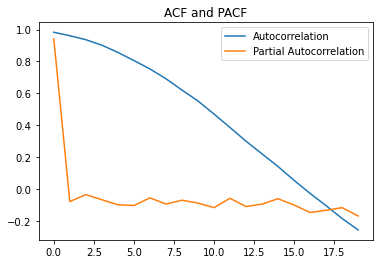

In [13]:
plt.plot(ac_vals, label='Autocorrelation')
plt.plot(pac_vals, label='Partial Autocorrelation')
plt.title('ACF and PACF')
plt.legend()
plt.show()

**As expected, we see a steep decline in partial autocorrelation (correlation of error) and a gradual, semi-linear decline in autocorrelation. This implies that we can test higher orders of $p$ in our ARIMA model, but should limit ourselves to low $q$.** 

**For this problem, I will test $p \in [1,4]$, $d \in [0,2]$ and $q \in [0,1]$**

#### Run  Modeling - Statistical Methods

In [37]:
arima_results = pd.DataFrame()

for city in hpi.city.unique():
    for p in range(1,5):
        for d in range(1,3):
            for q in range(0, 2):

                func_result = ts_functions.ARIMA_pred(hpi, city, (p,d,q), trend='n')
                func_result['city'] = city
                func_result['p'] = p
                func_result['d'] = d
                func_result['q'] = q
                arima_results = pd.concat([arima_results, func_result])

In [43]:
arima_results.to_csv('../model-results/arima_results.csv')

#### Evaluate Results

This evaluation measures four things:
1. win rate - the proportion of times the prediction beats the naive assumption $x_{t+k} = x_t \forall k$, measured across prediction periods 1-4
2. error - the average MSE across prediction periods 1-4
3. improvement - the average MSE improvement over the naive assumption across periods 1-4
4. AIC - Akike's Information Criterion, a complexity-penalized measure of goodness of fit

In [38]:
win, error, improvement, AIC = ts_functions.evaluate_model(arima_results, method='square')

In [39]:
pd.concat([win.to_frame('win'), error.to_frame('mse'), improvement.to_frame('improvement'), AIC], axis=1).style.background_gradient(cmap = 'YlGnBu')

**Based on analysis of these four evaluation metrics, it seems that the optimal combination is (2, 2, 0).**

#### Visualizing Results

In [40]:
best_model = arima_results.query("p==3 & d==1 & q==0")

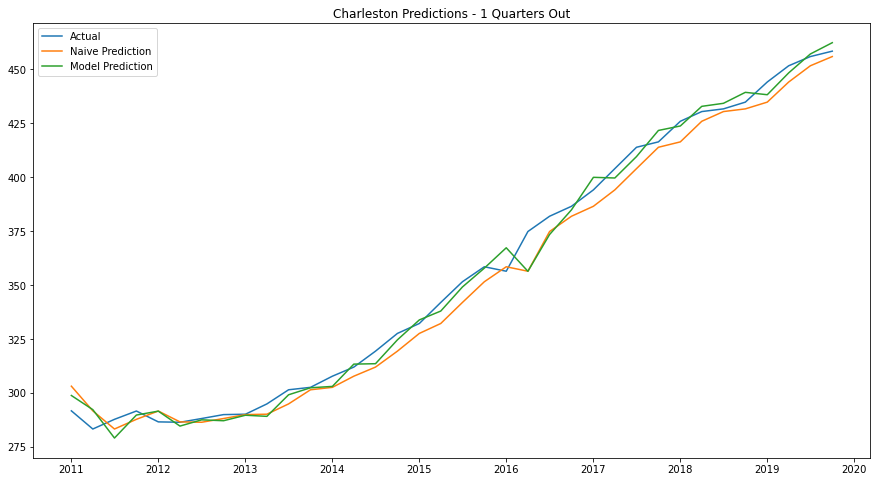

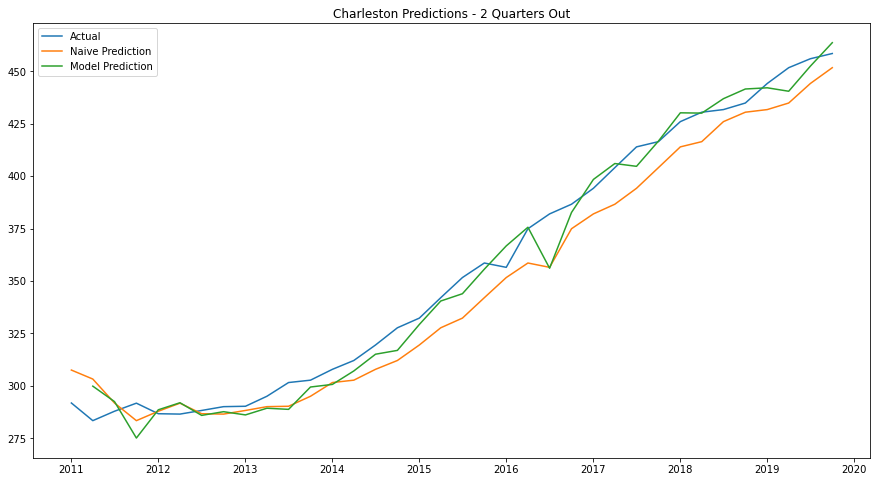

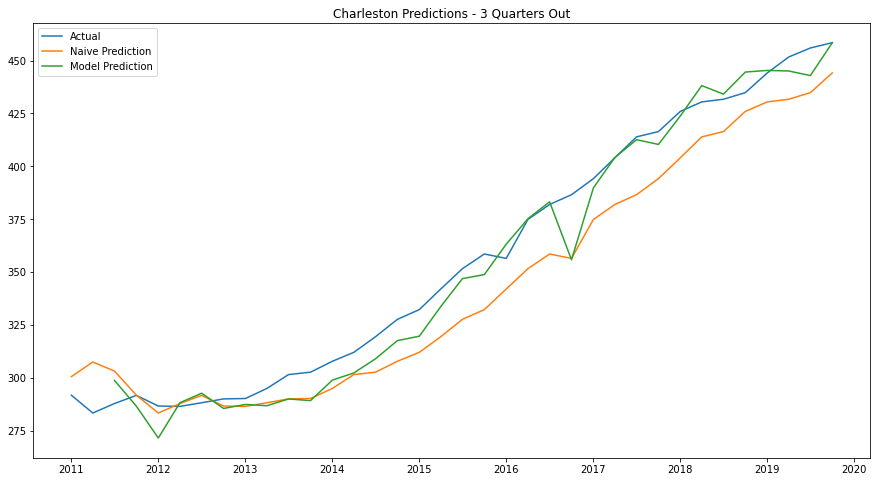

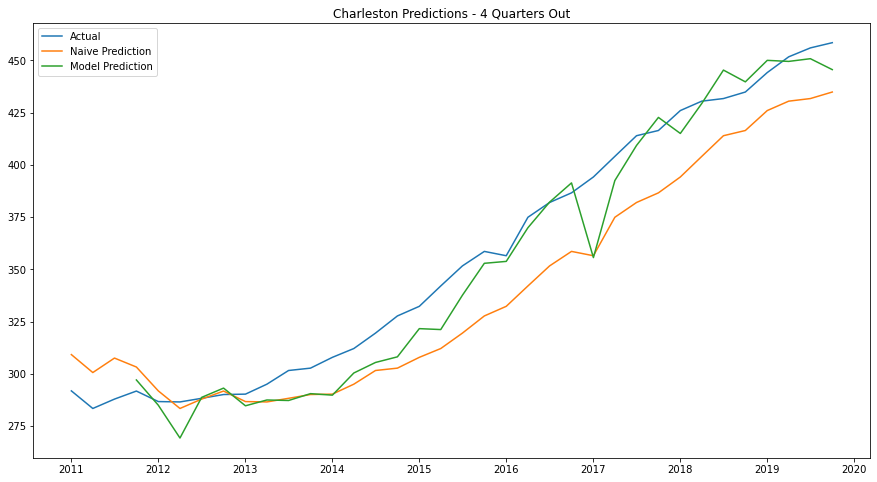

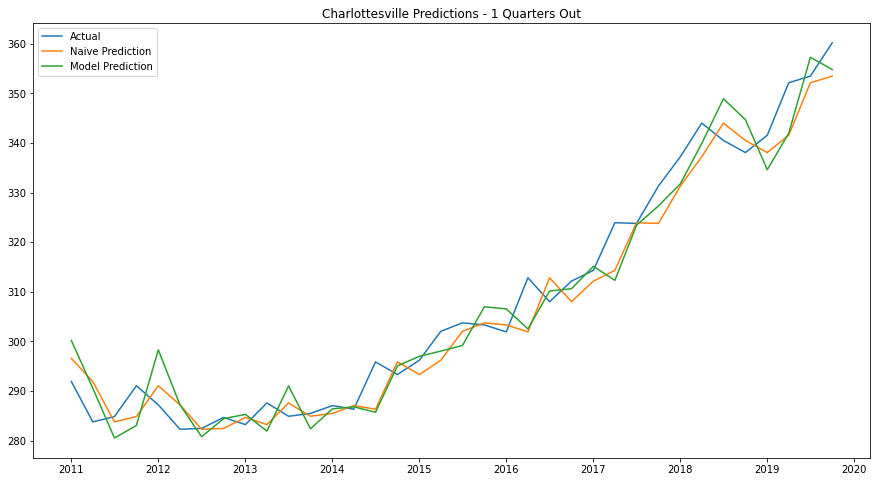

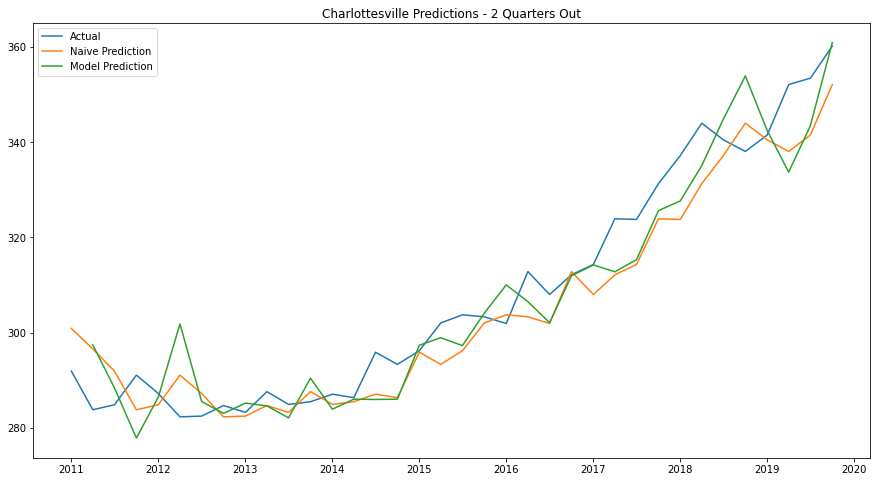

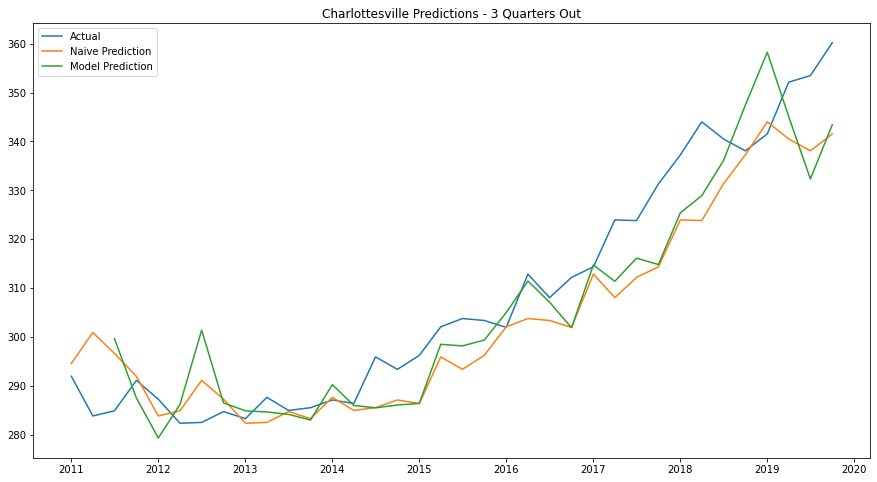

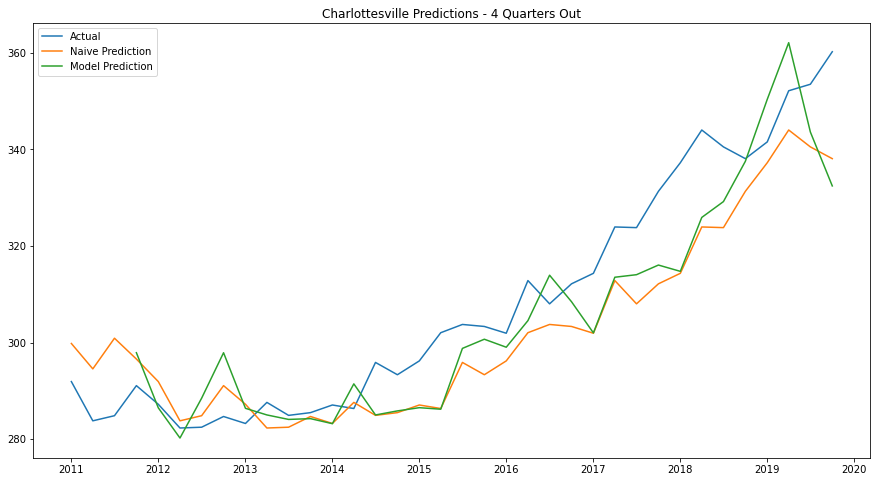

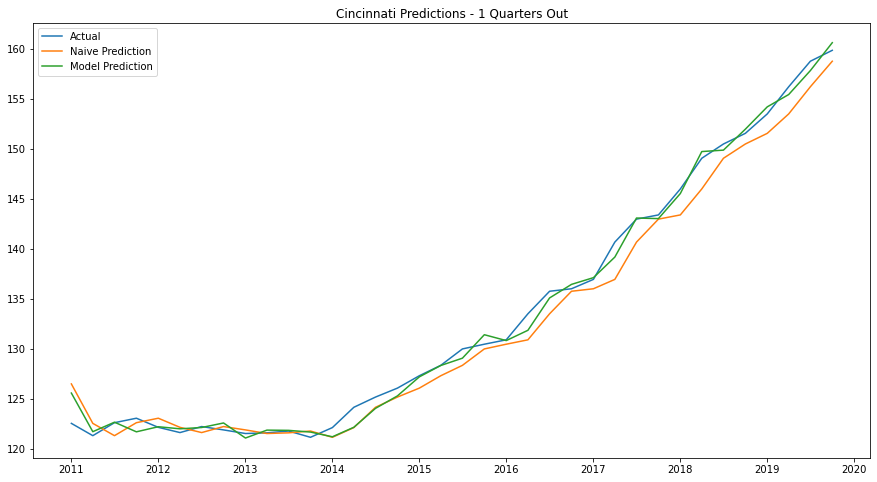

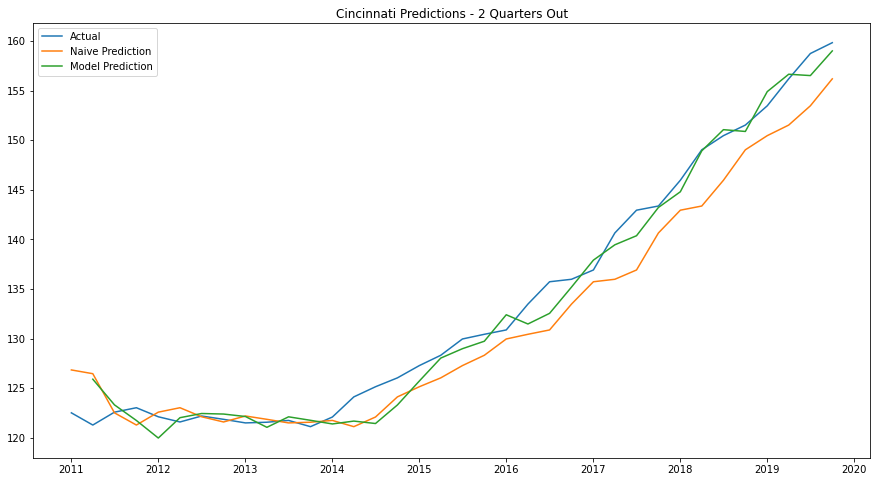

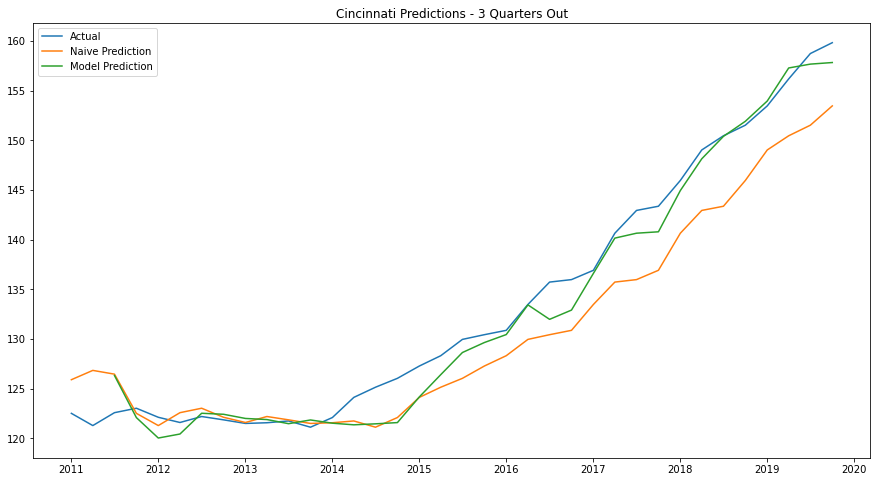

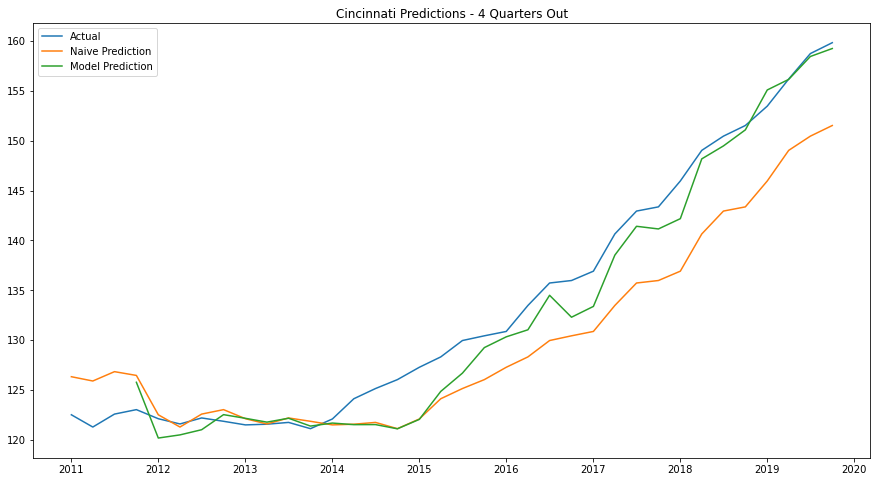

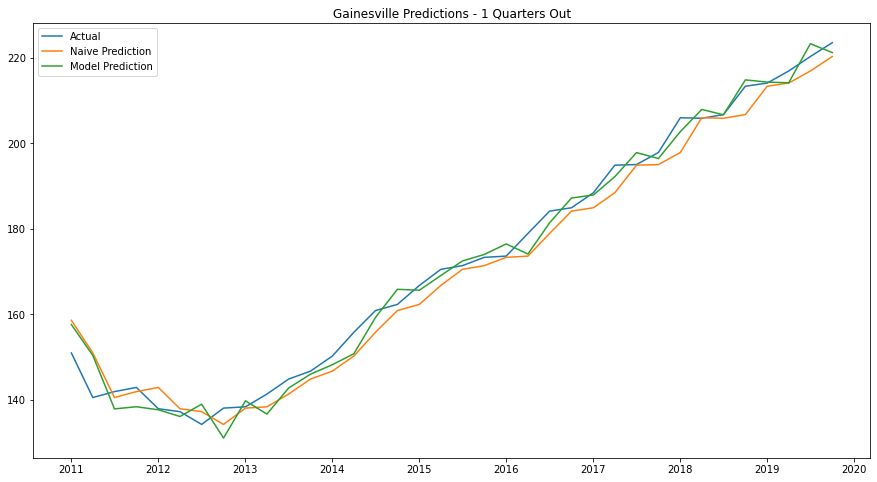

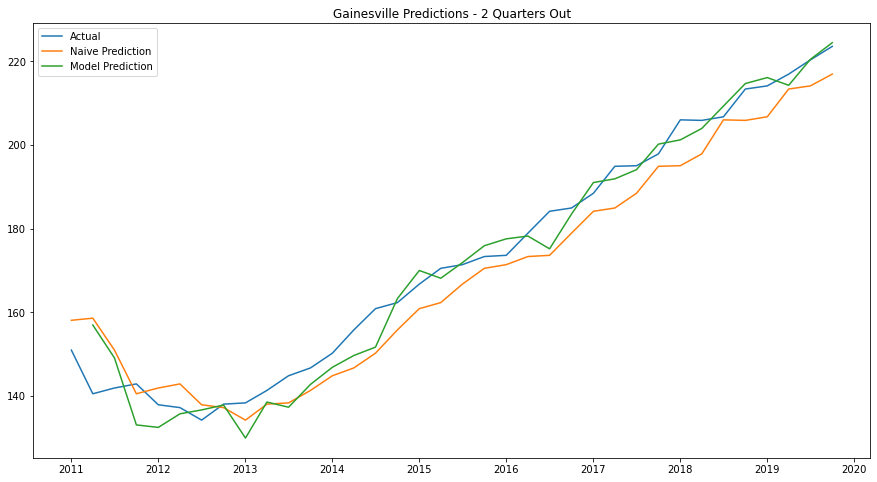

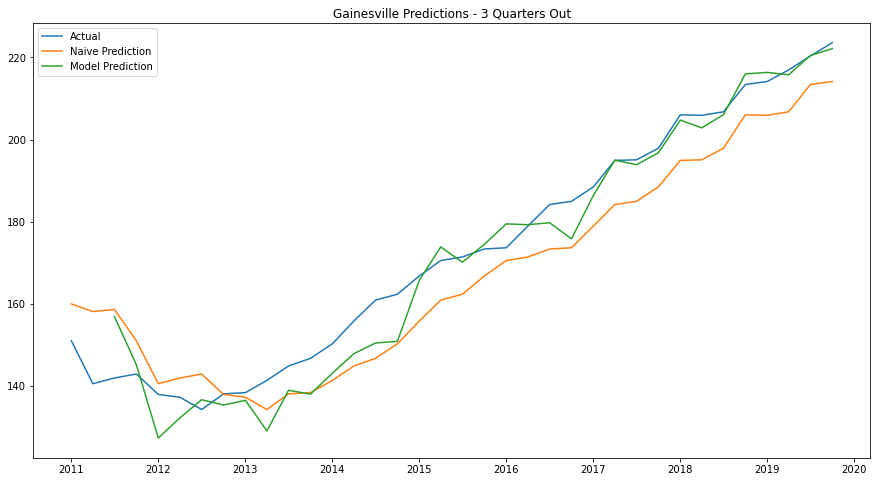

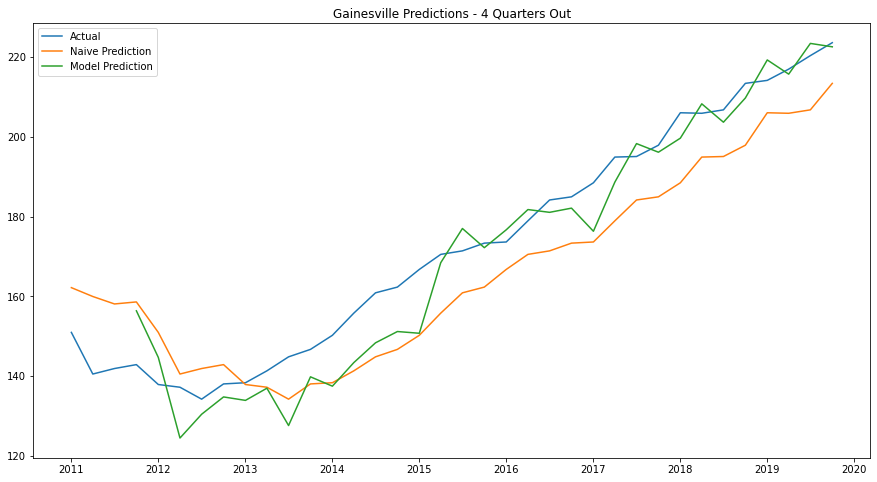

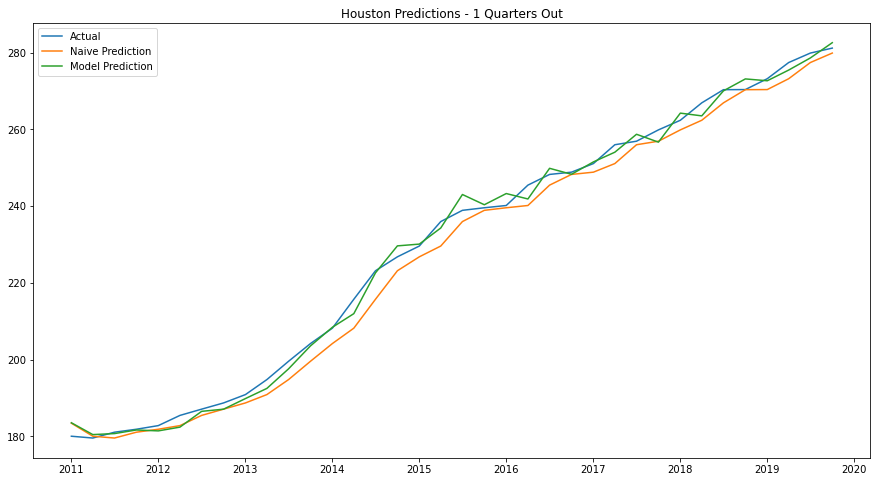

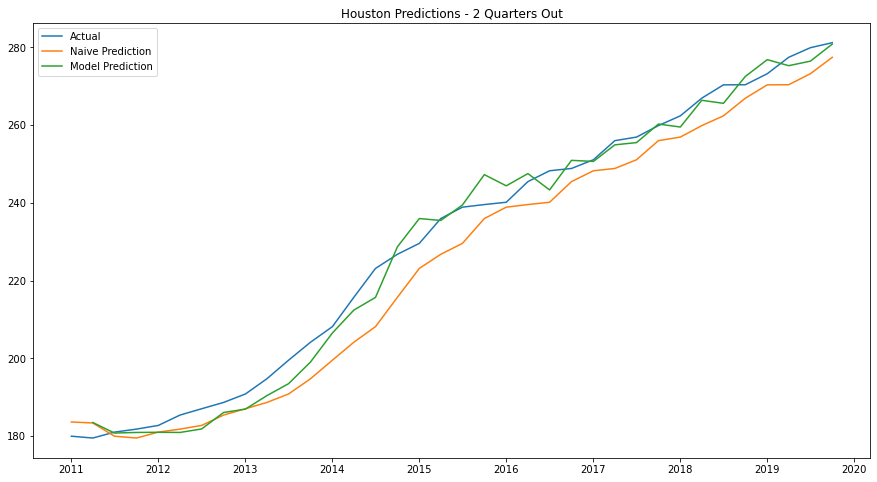

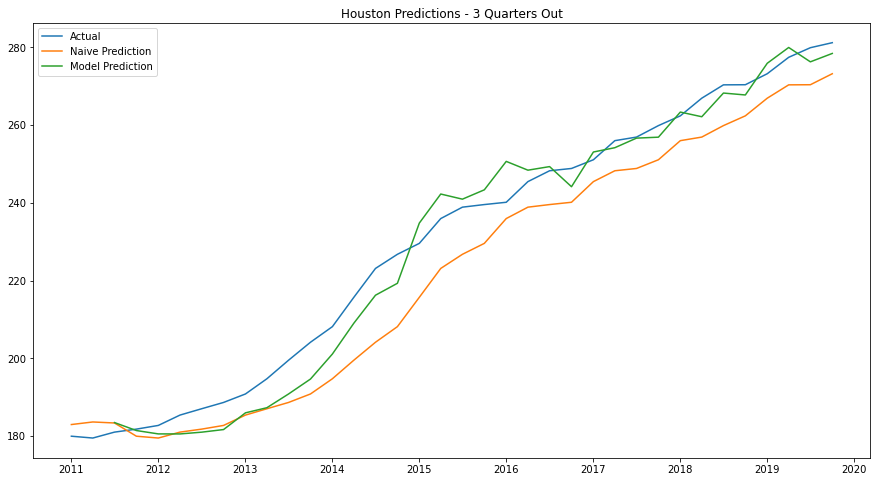

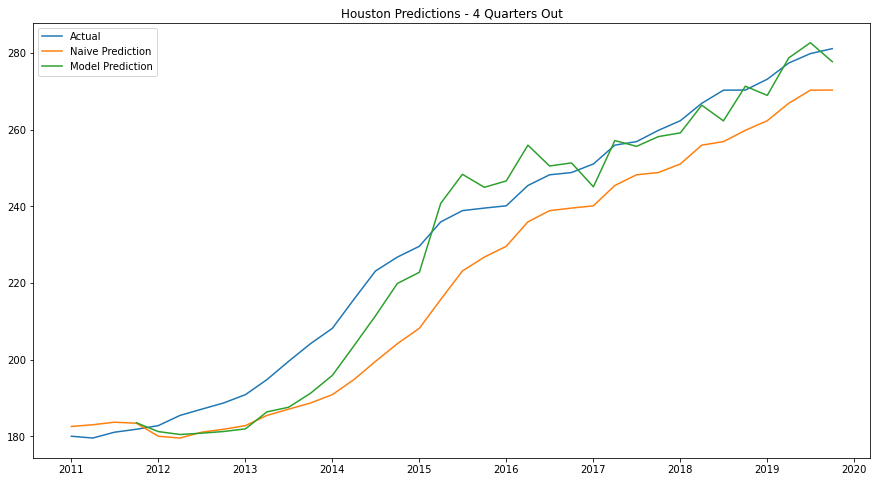

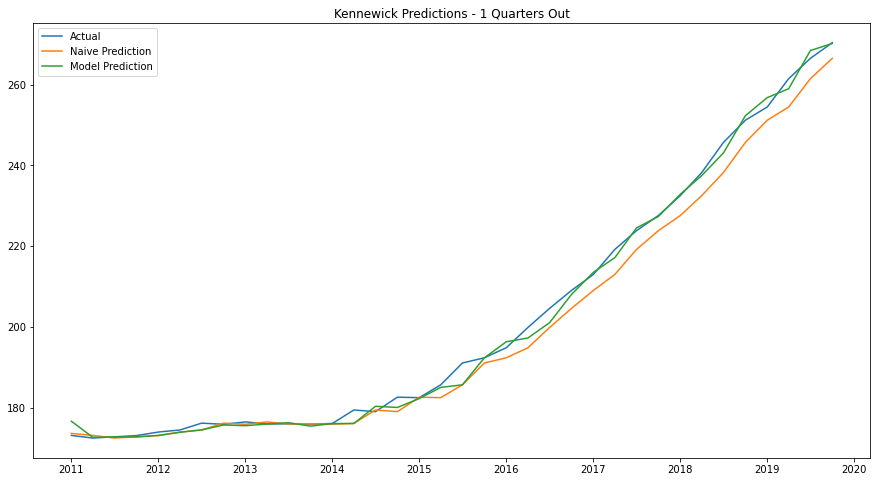

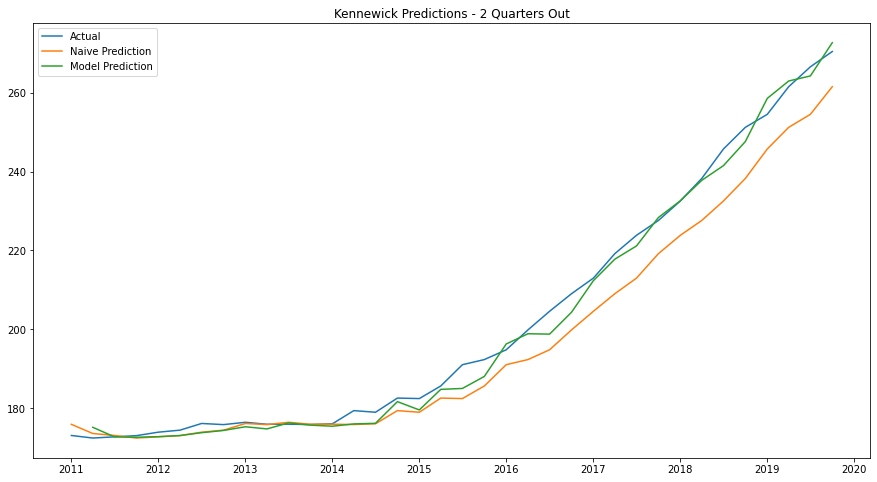

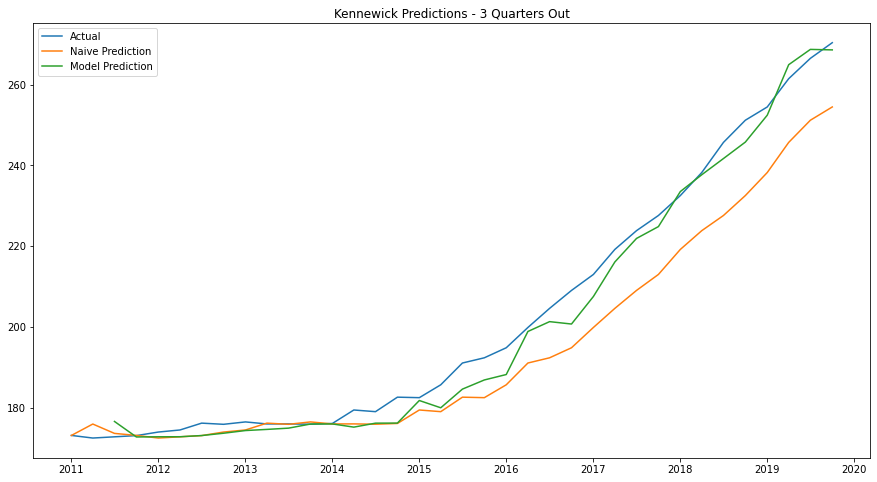

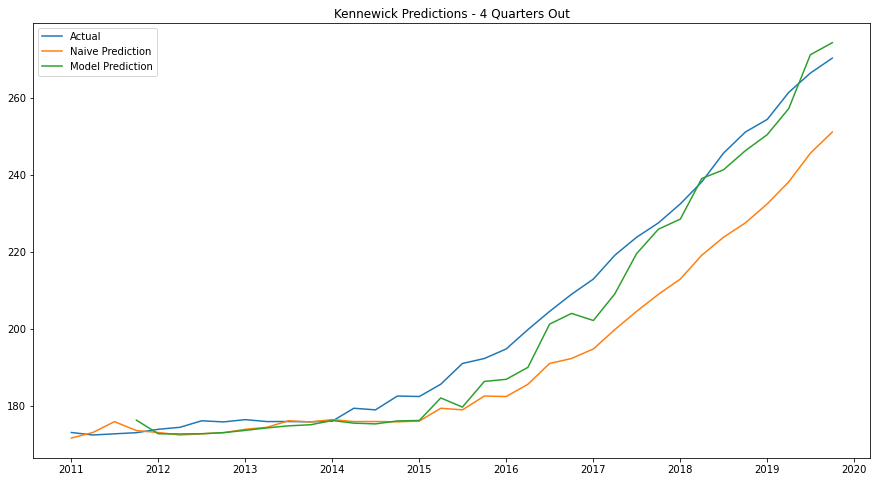

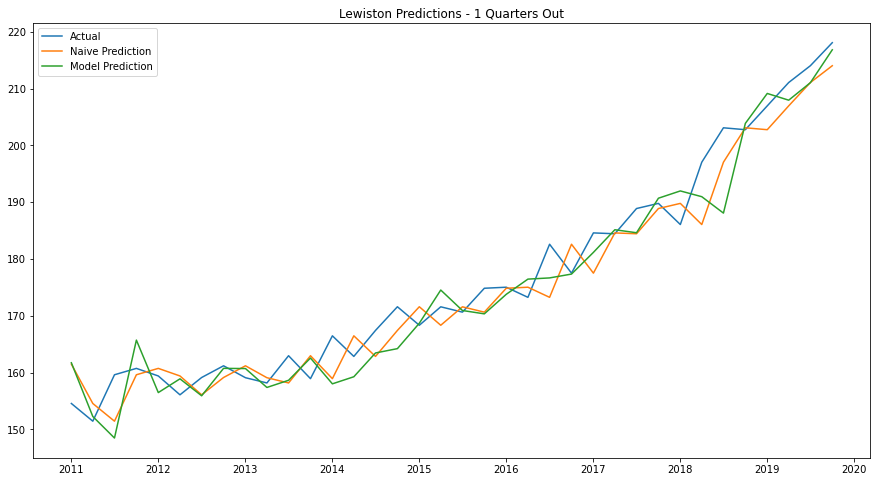

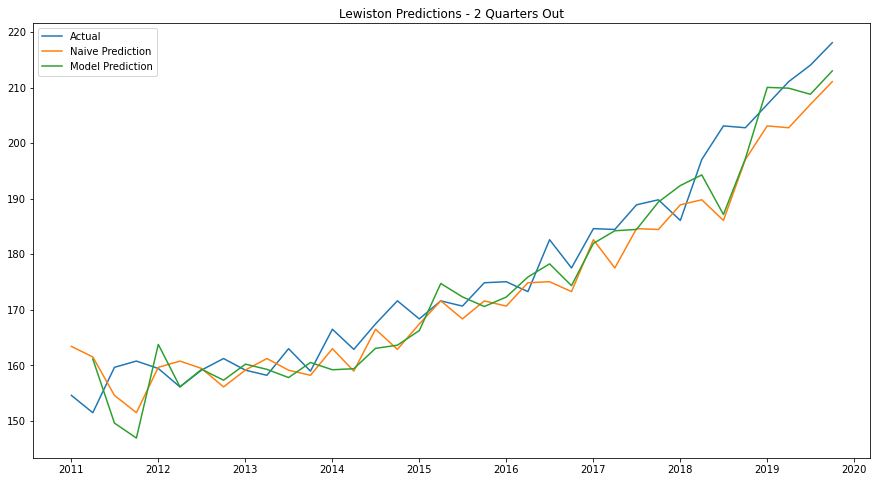

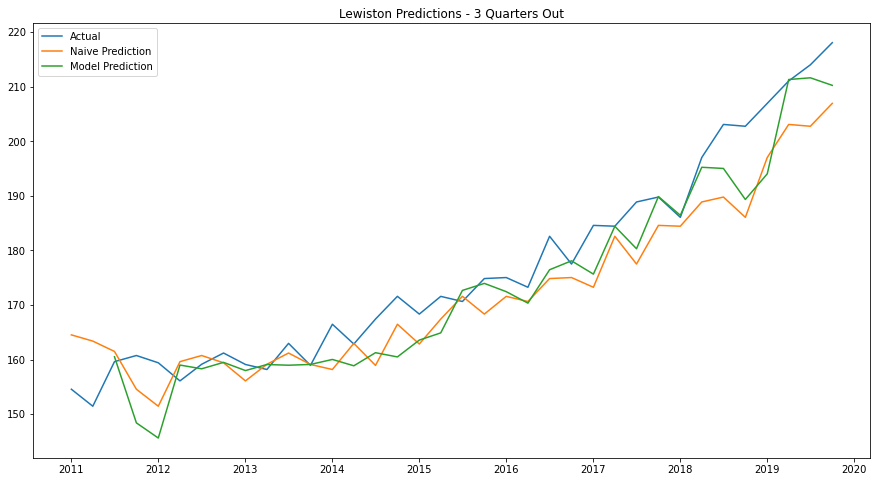

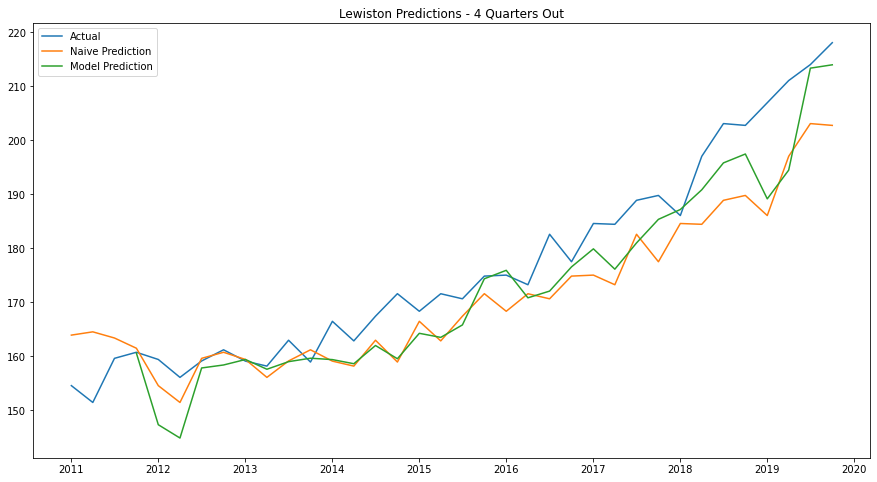

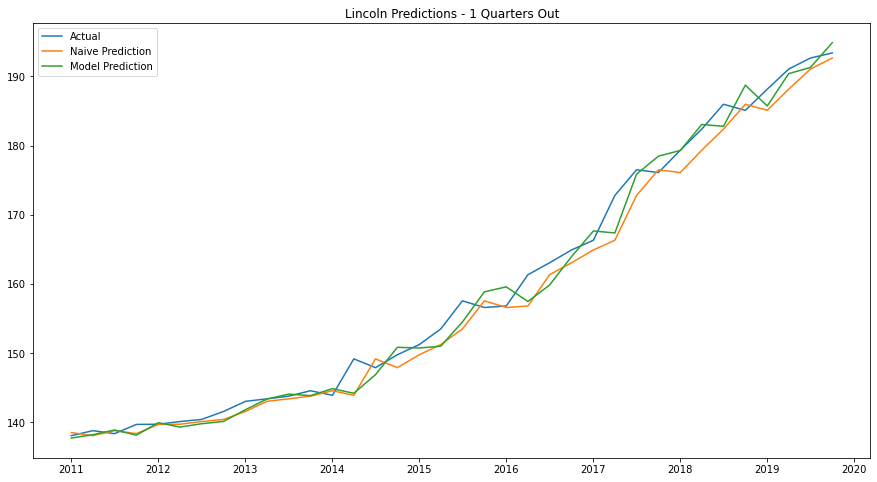

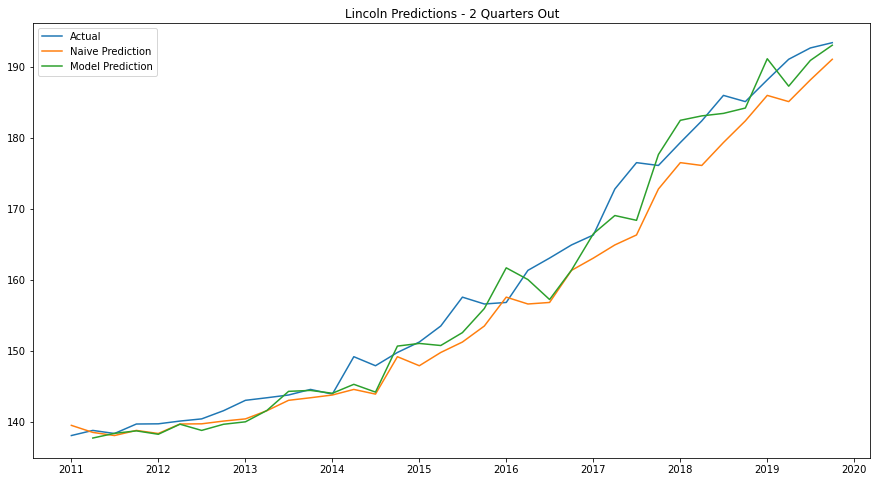

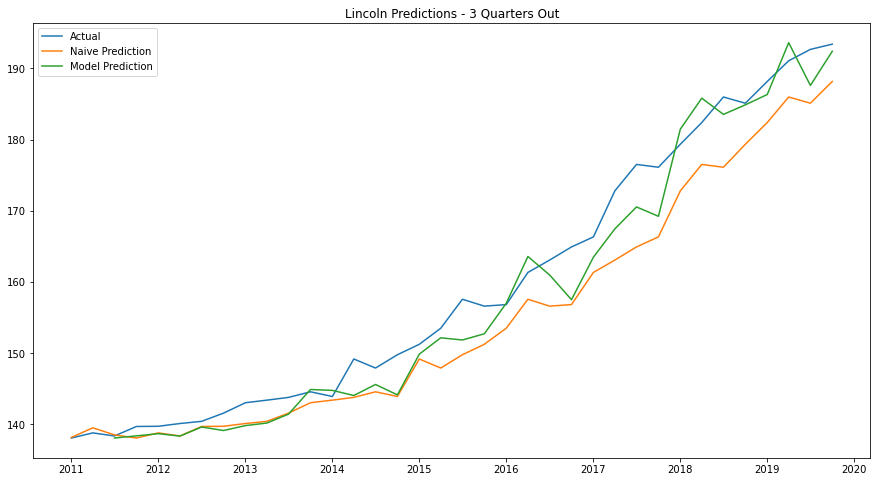

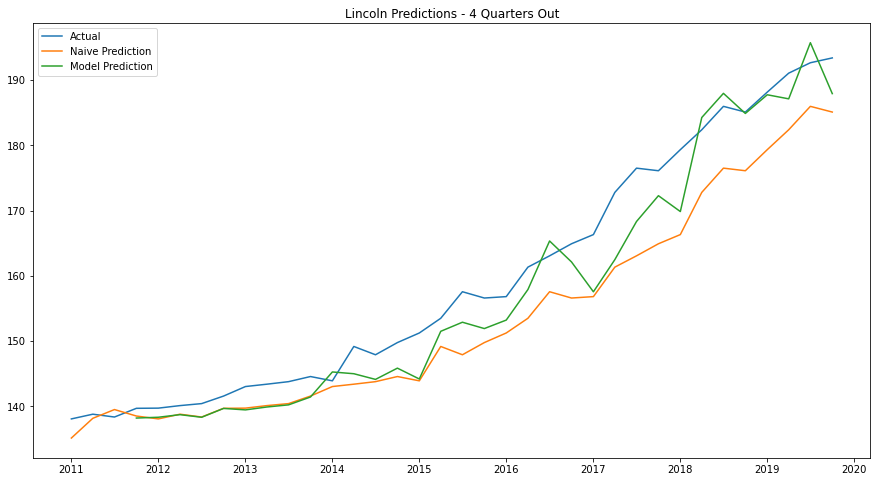

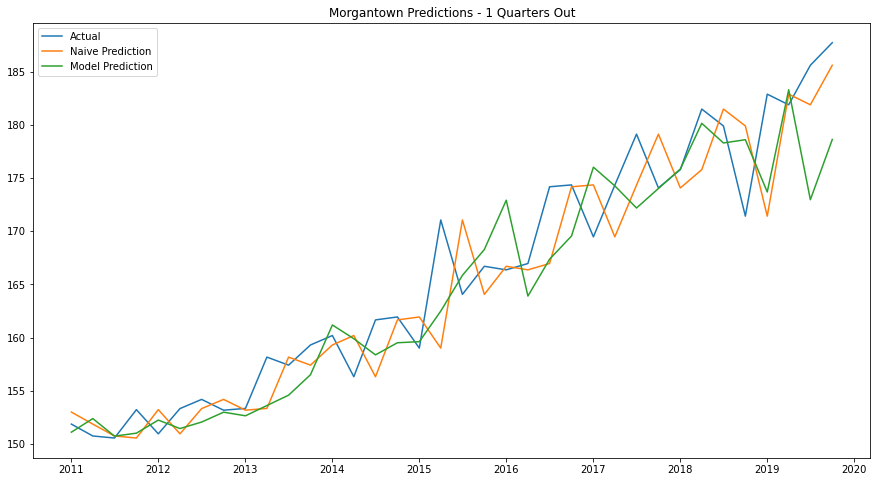

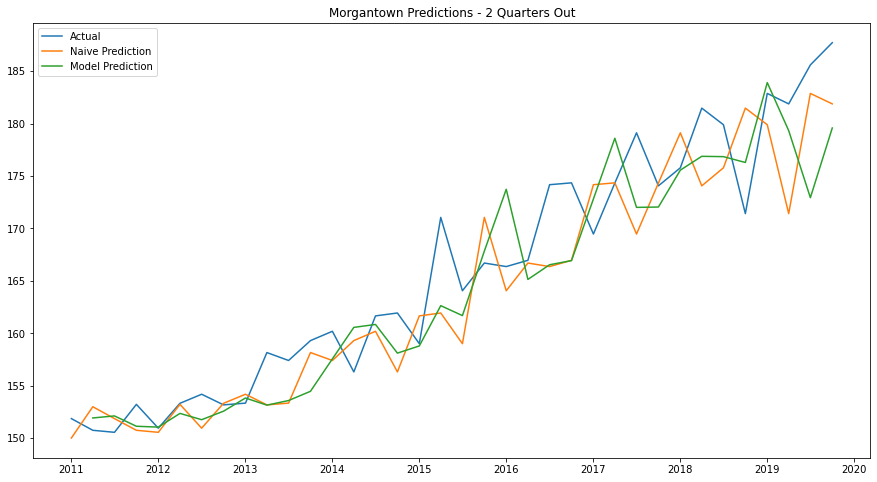

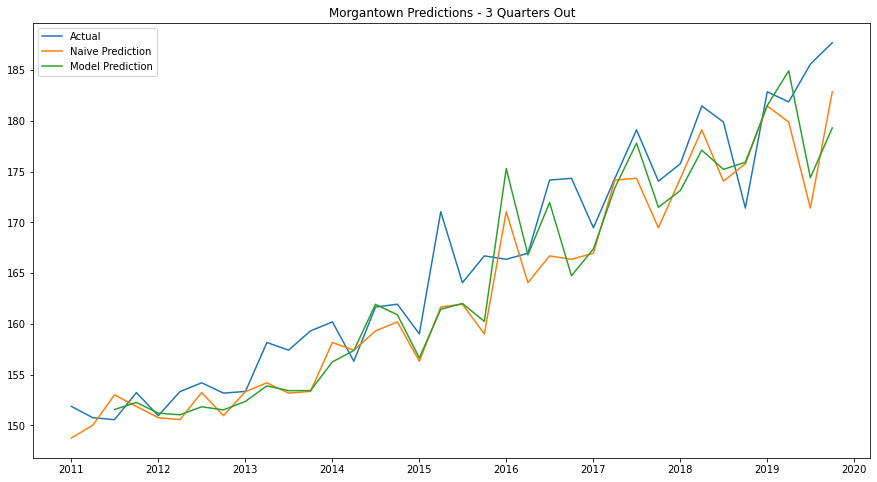

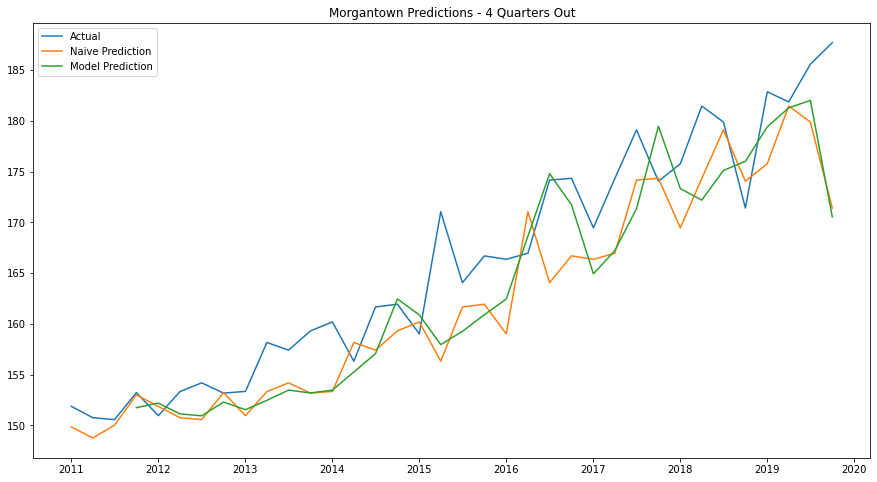

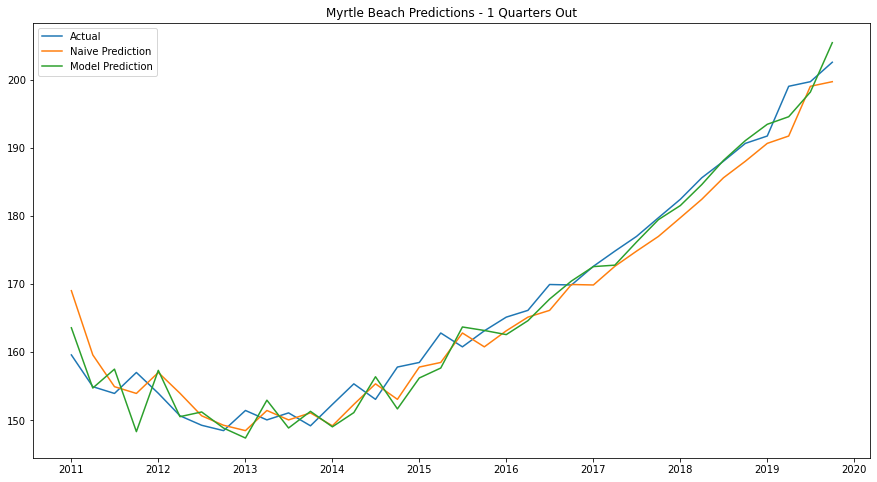

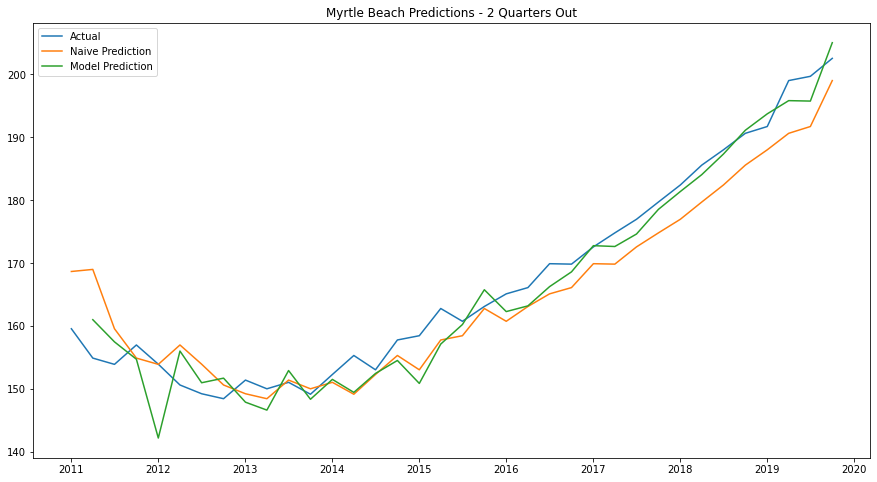

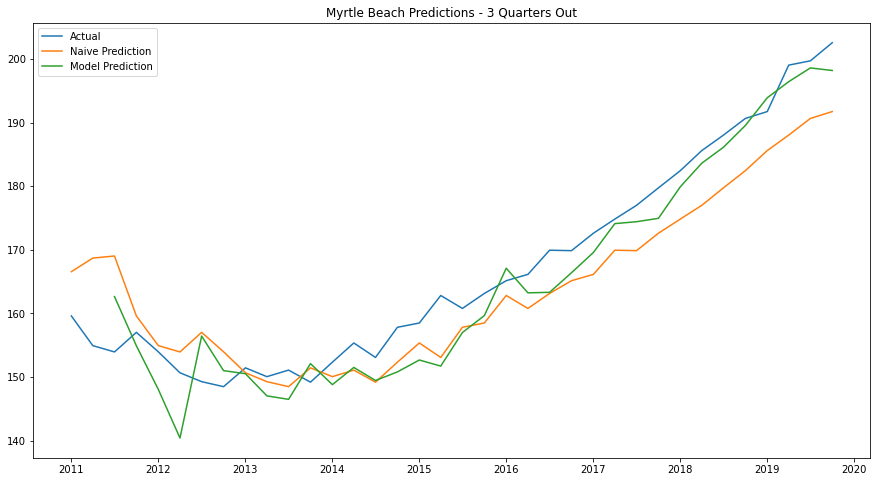

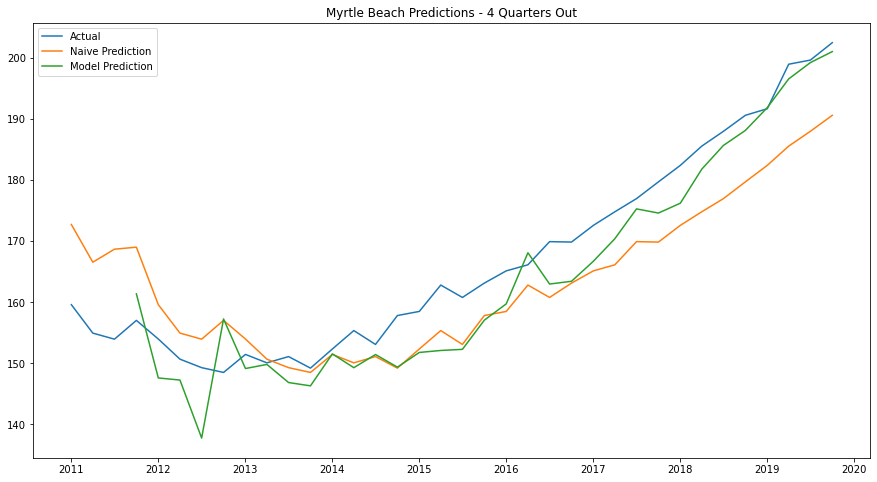

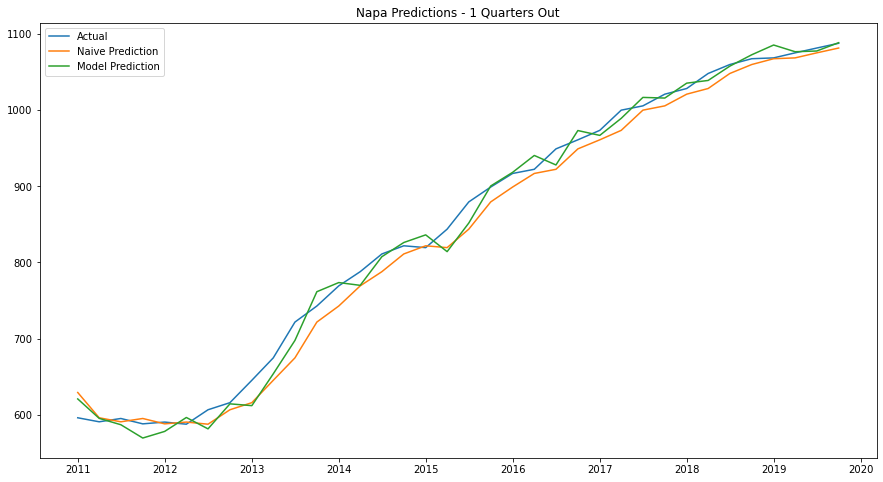

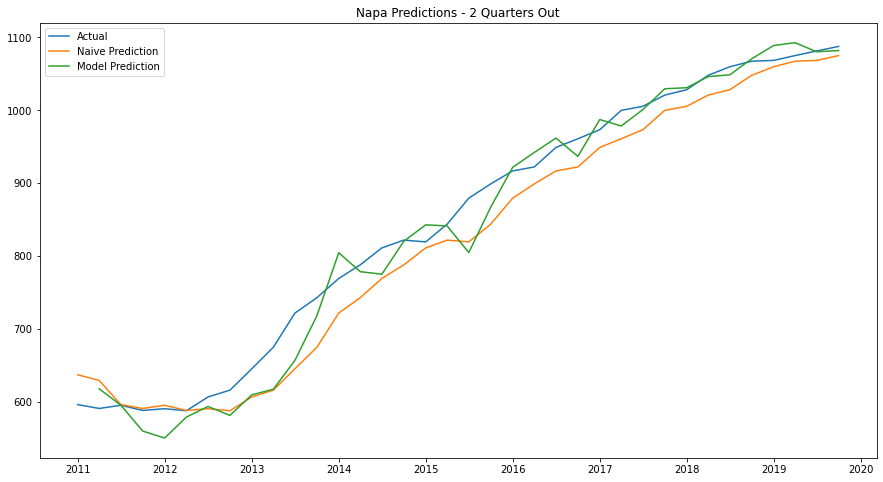

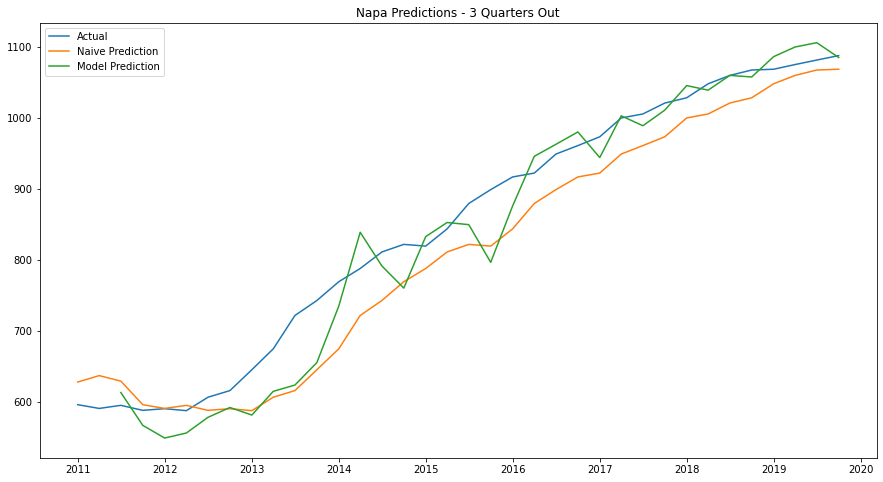

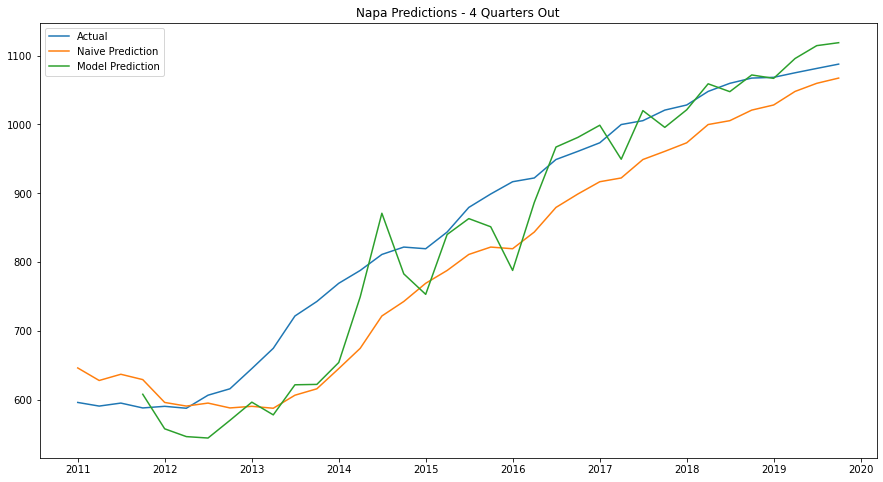

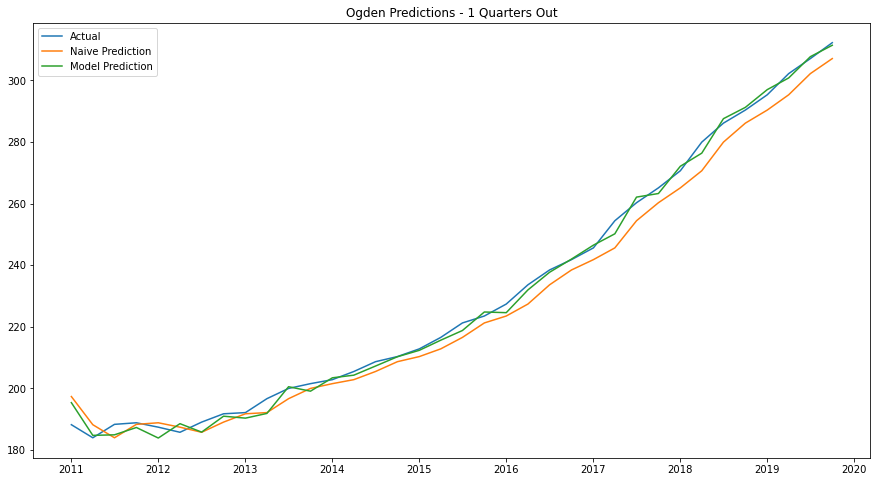

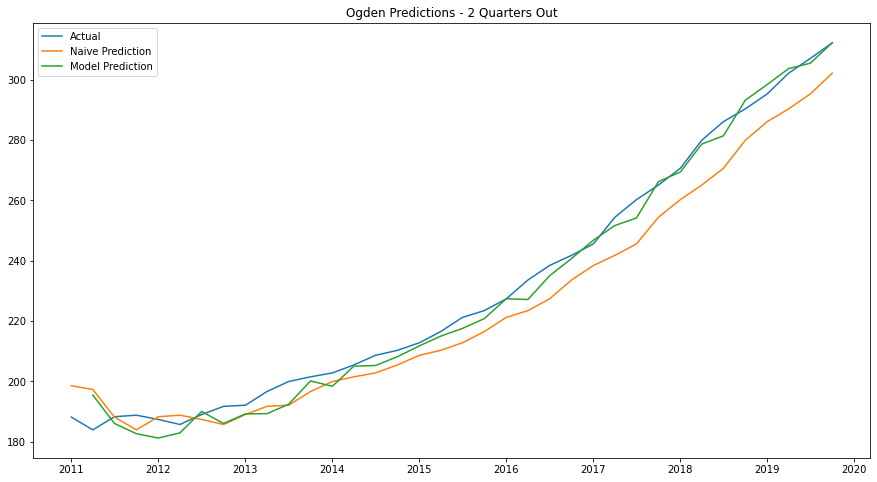

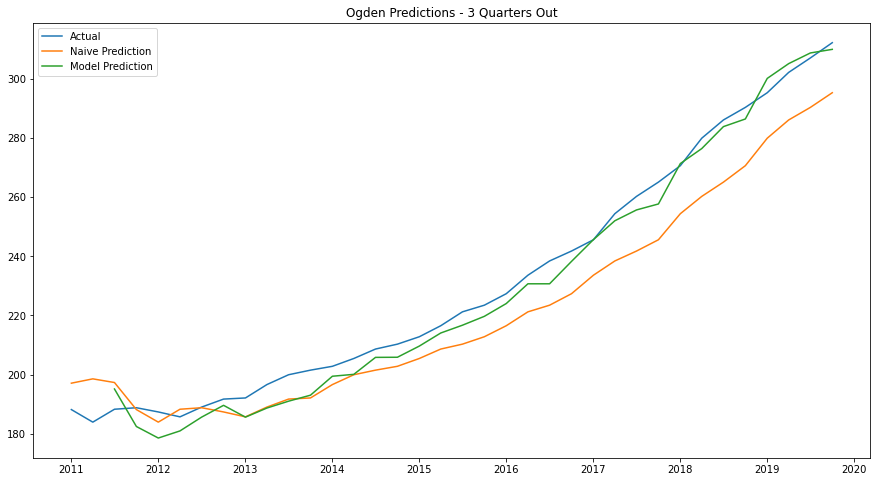

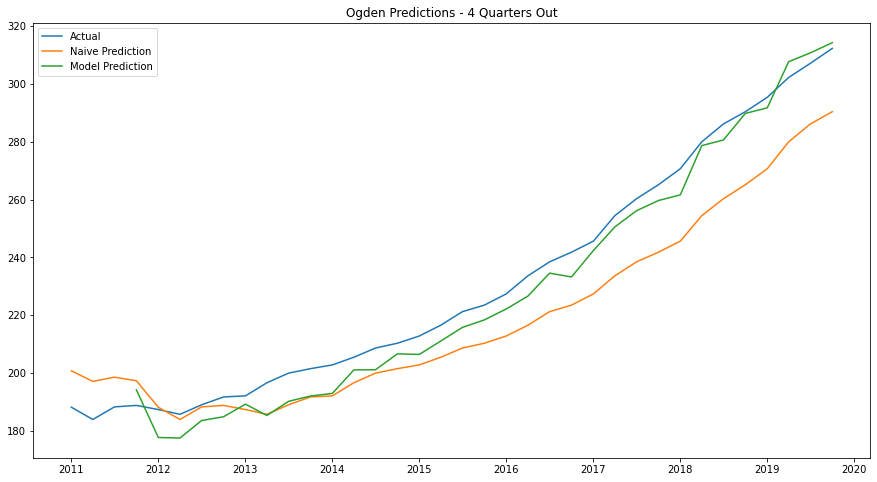

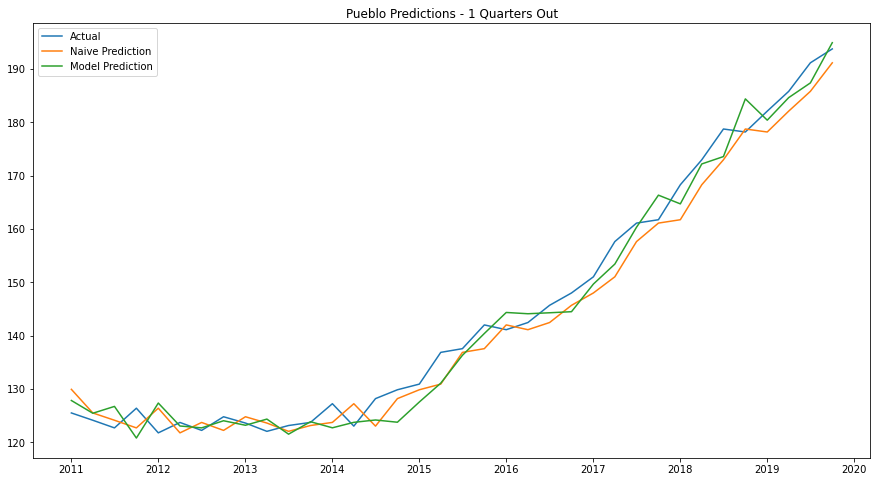

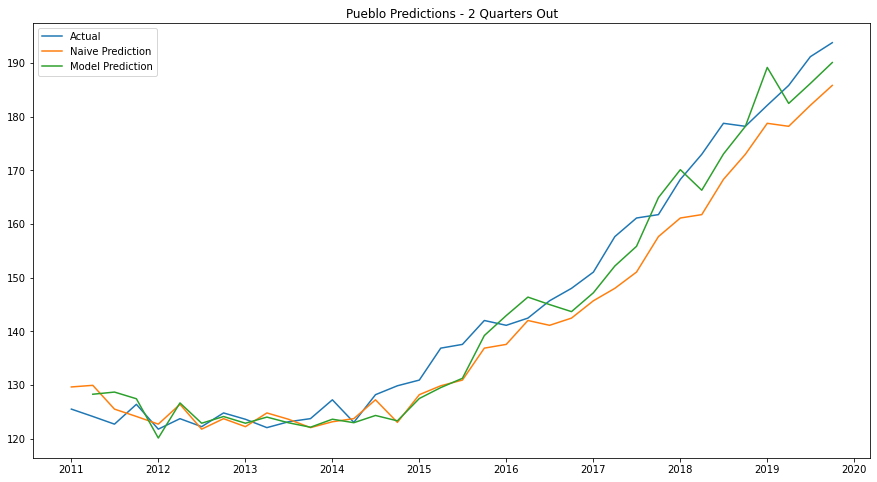

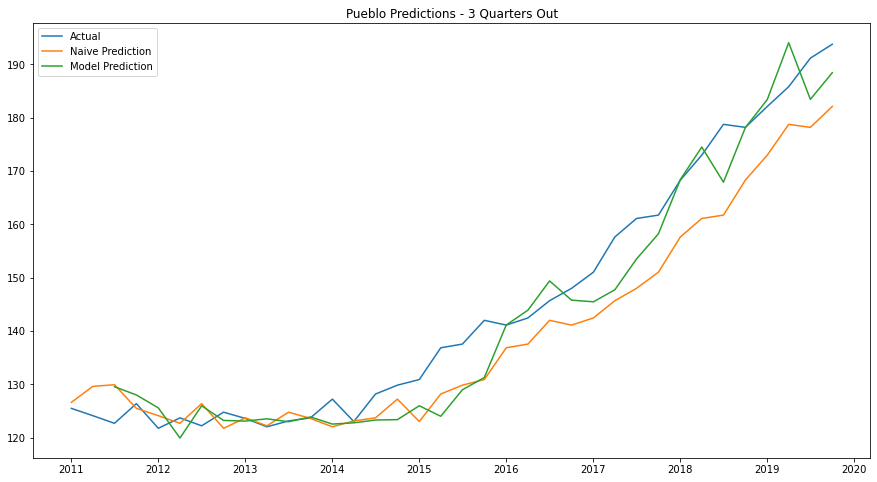

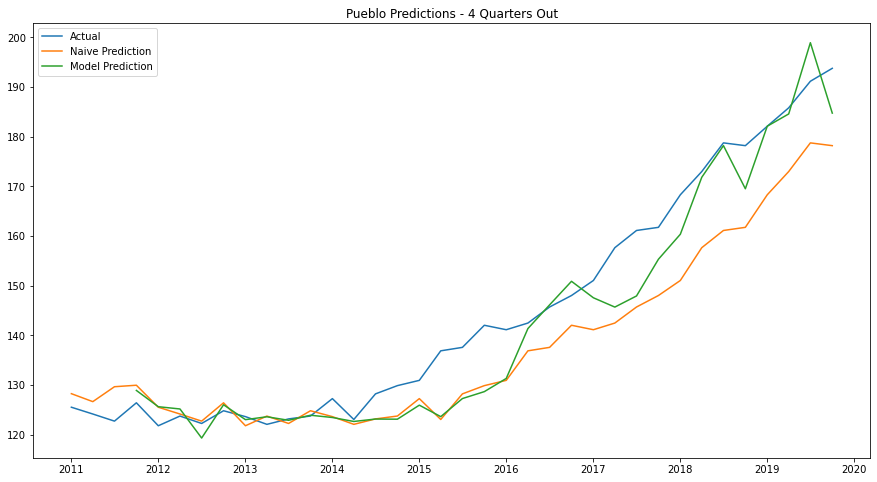

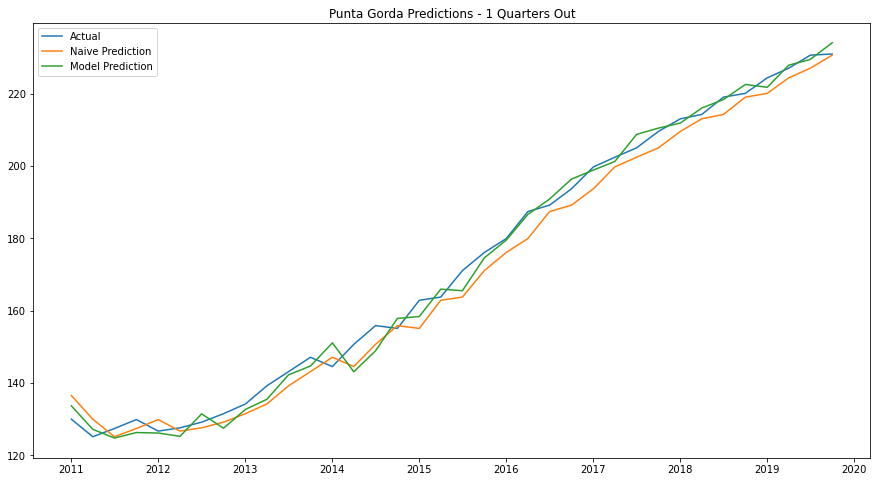

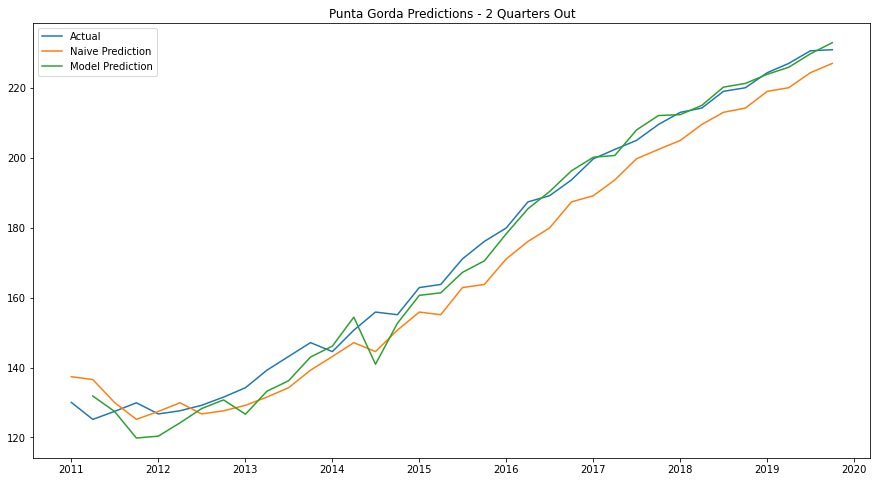

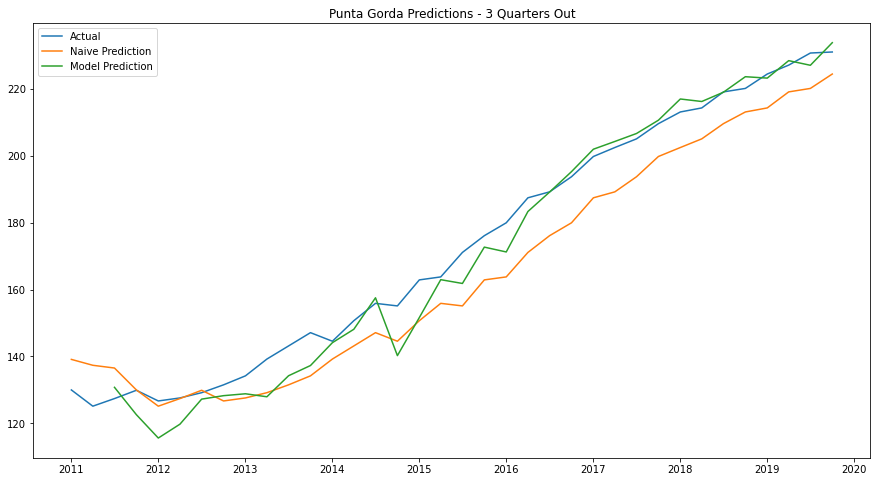

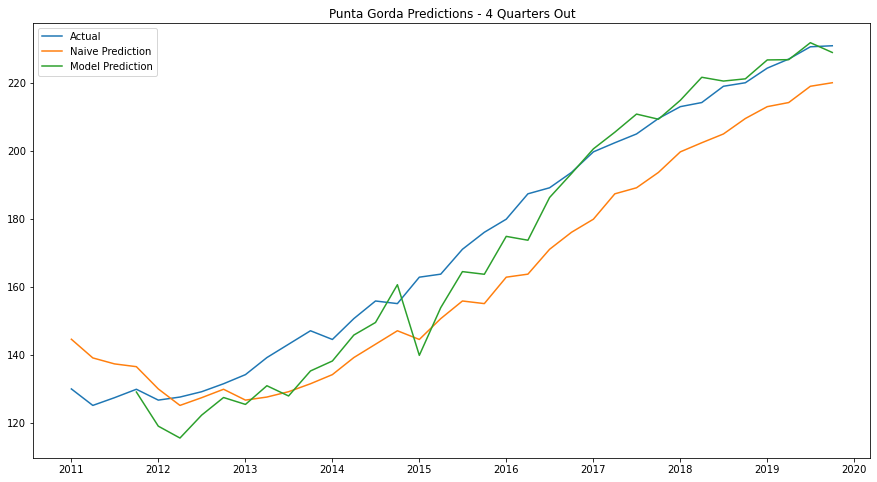

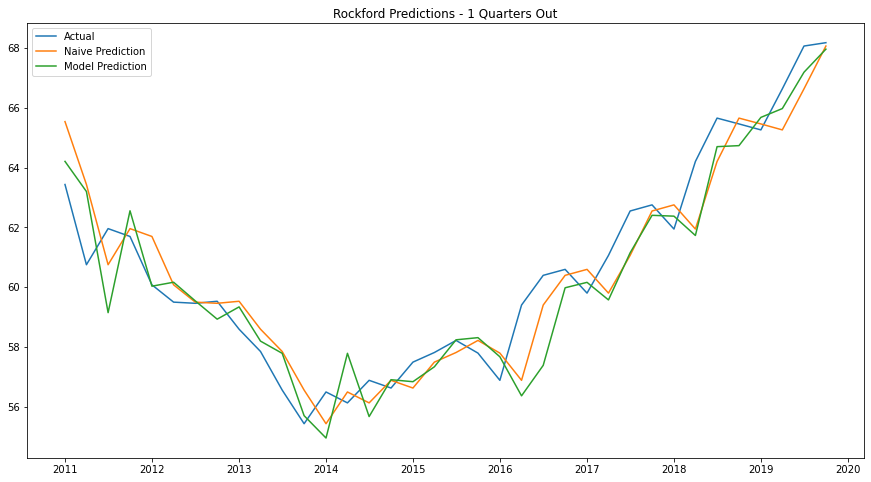

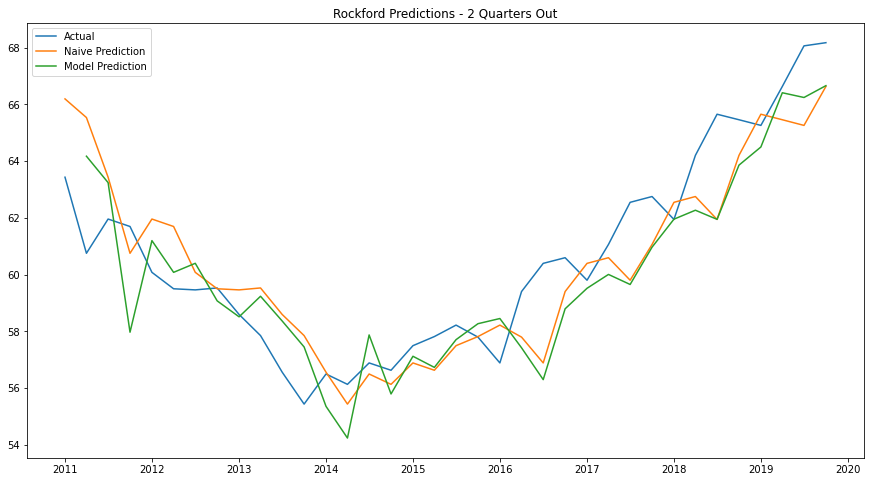

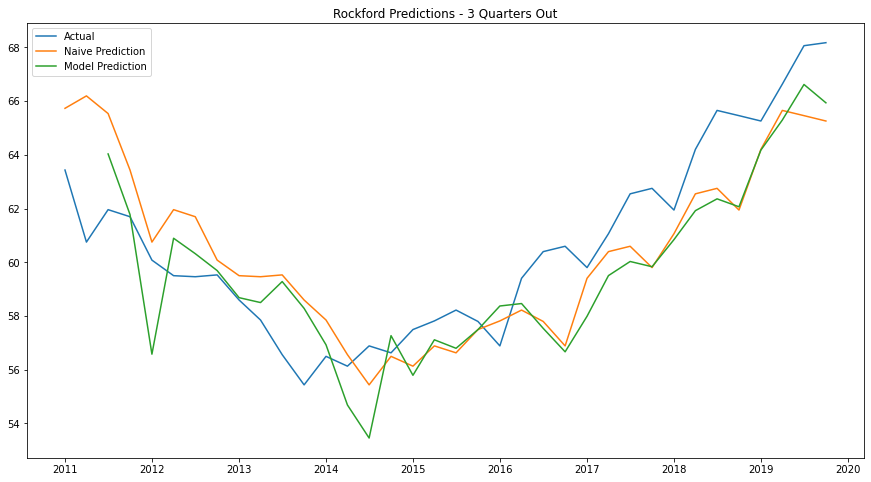

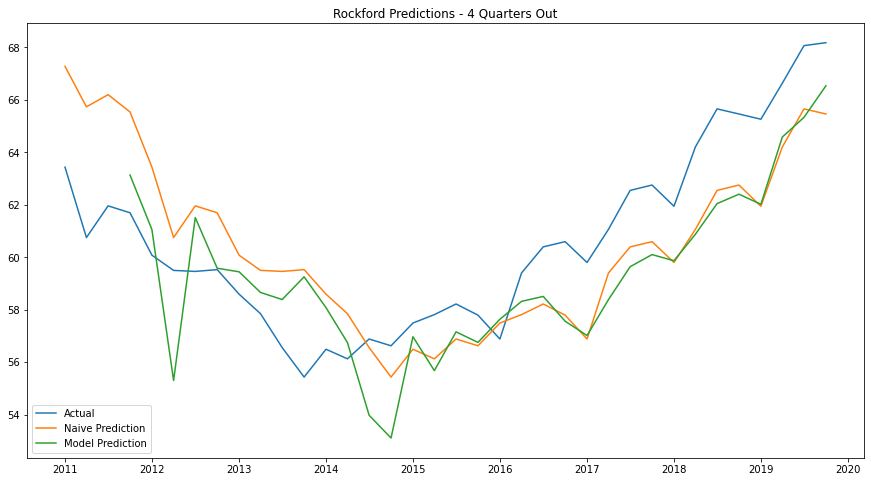

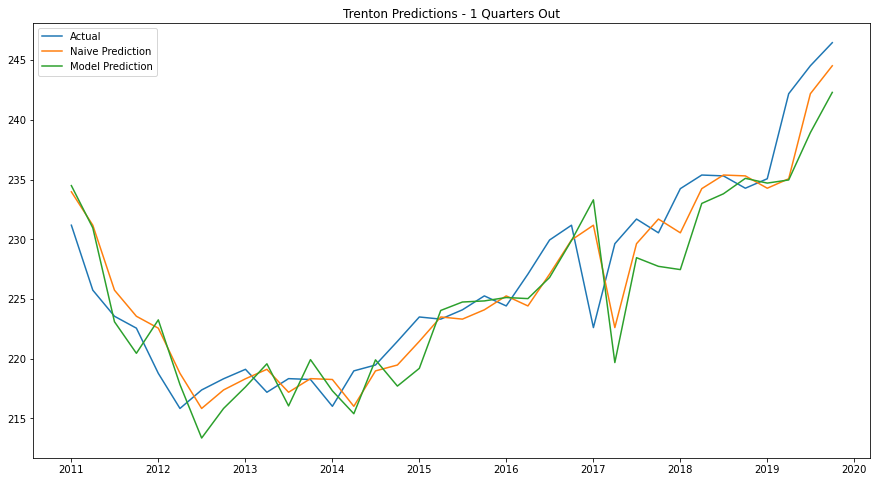

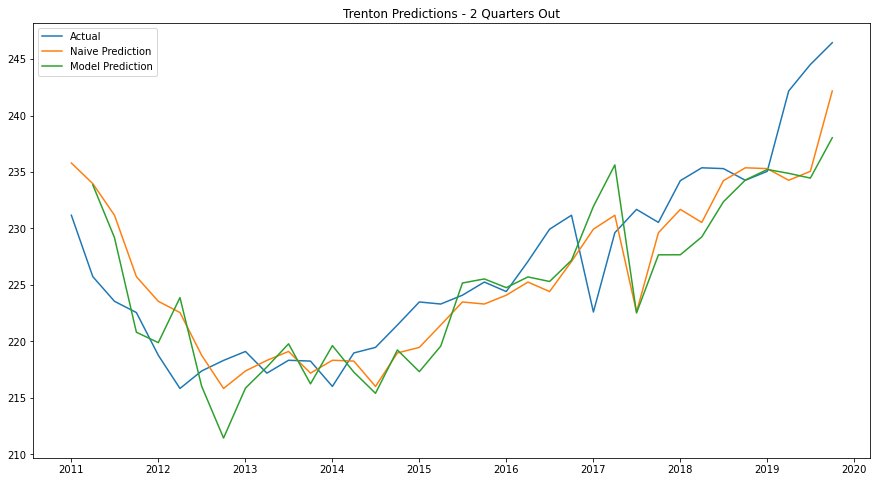

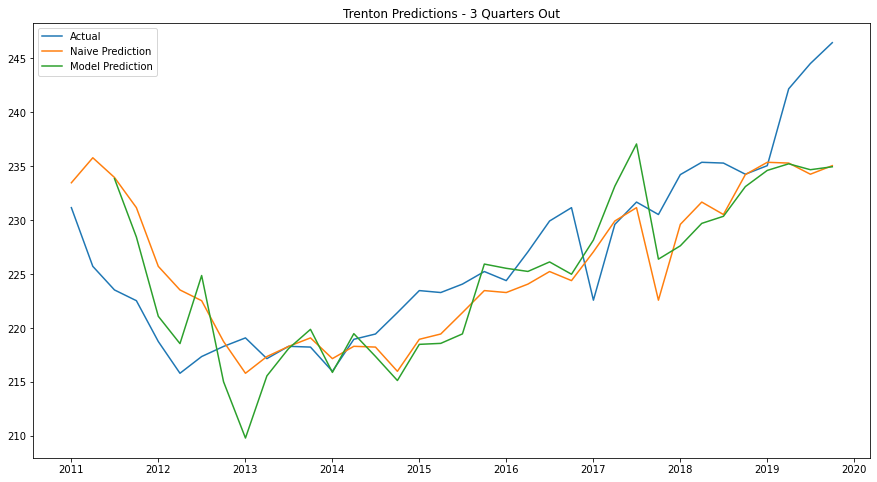

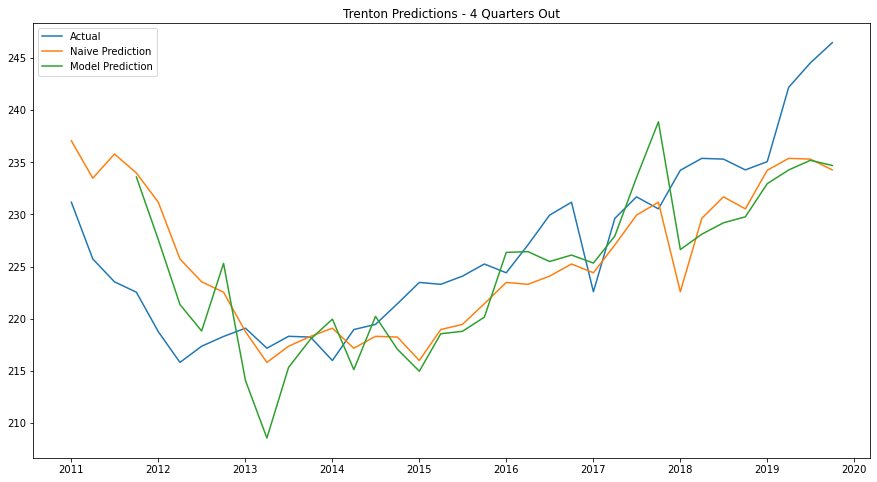

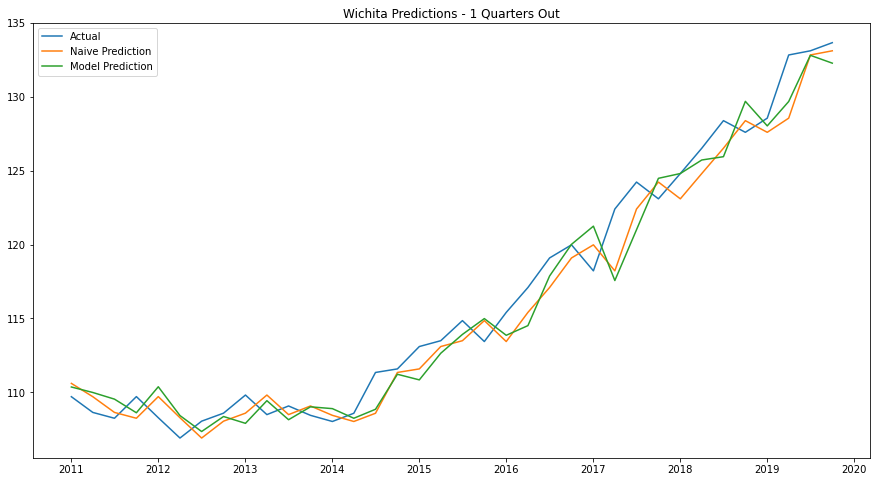

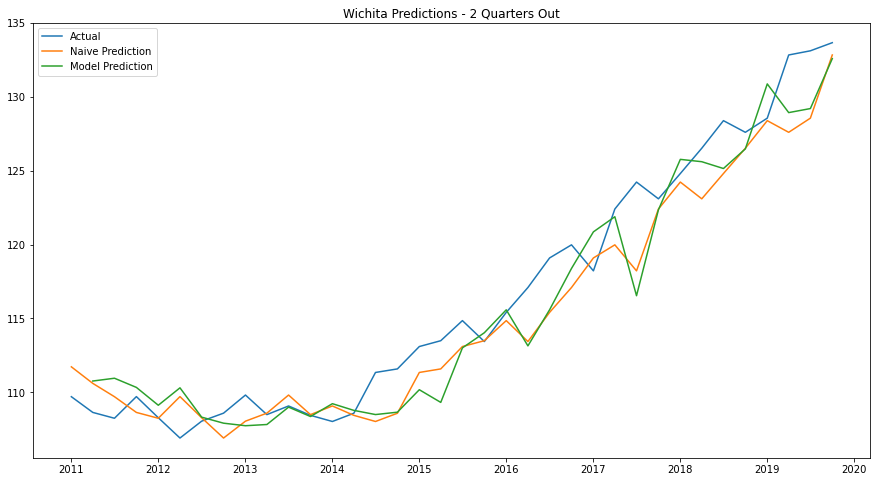

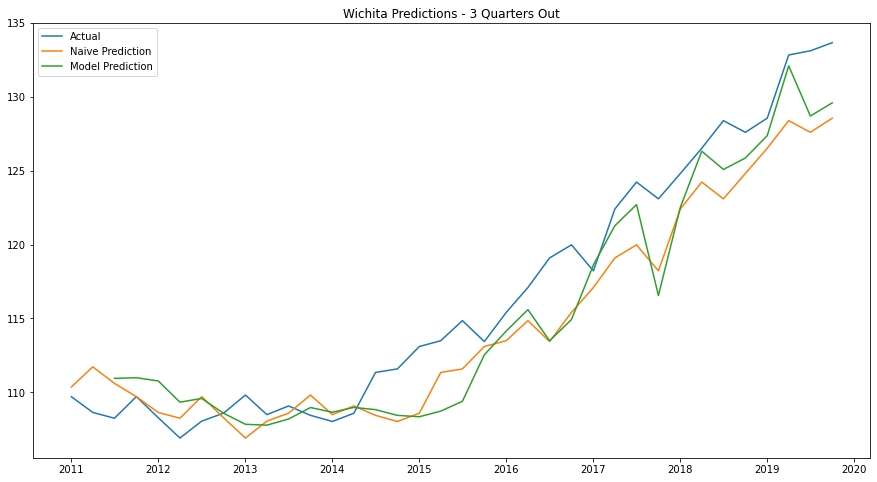

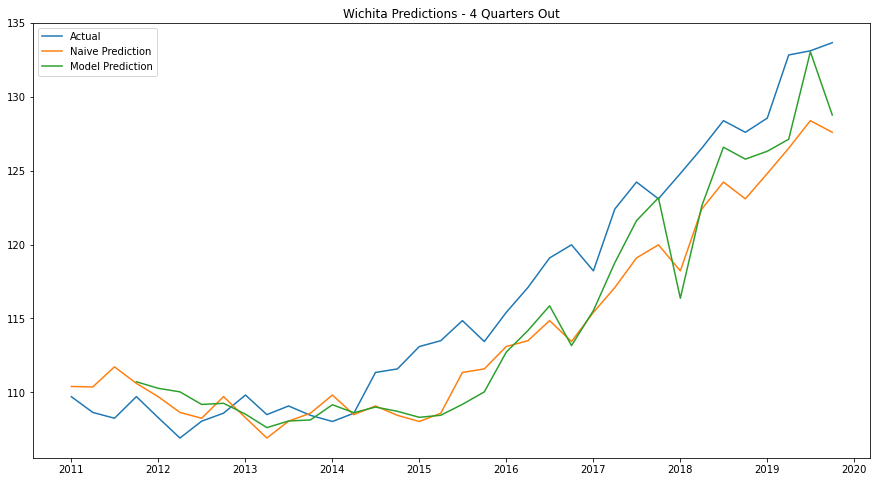

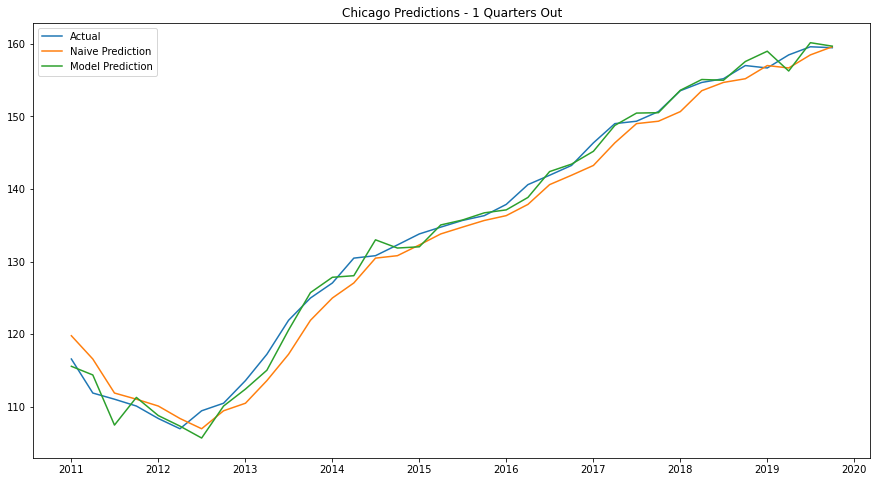

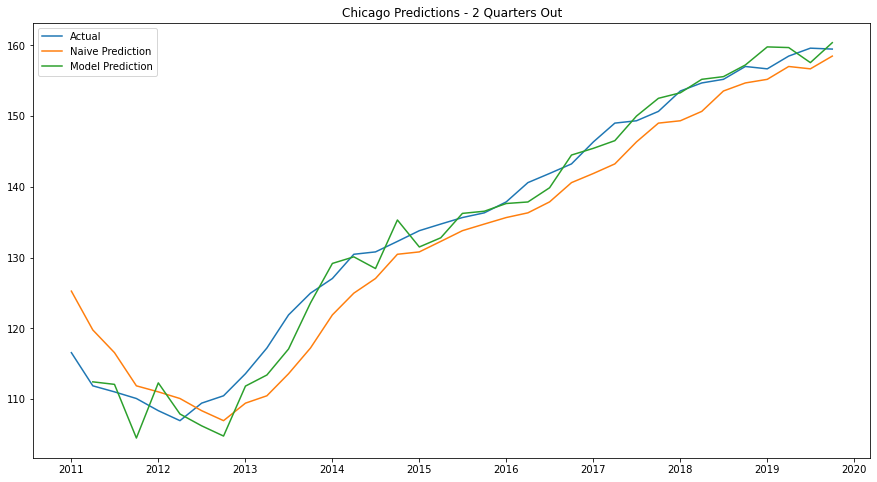

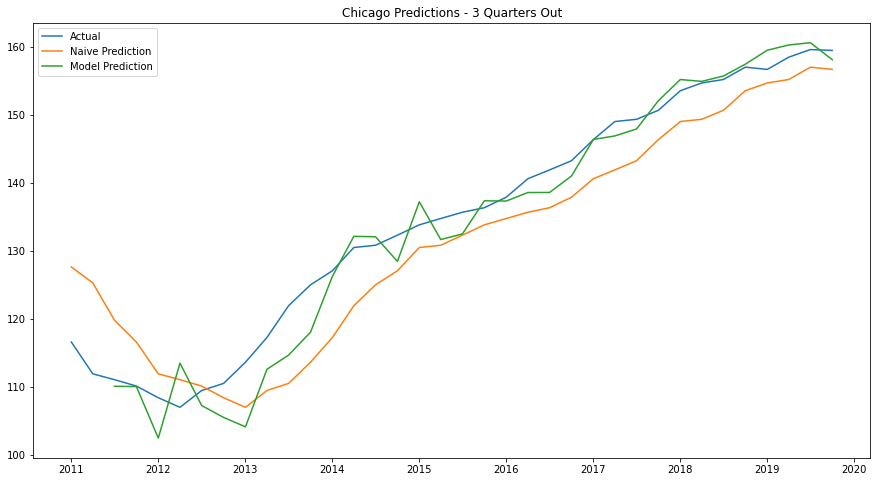

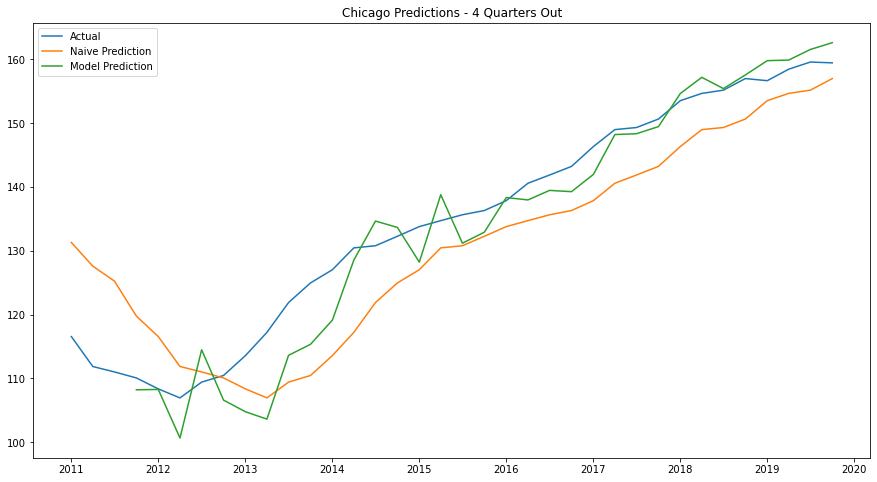

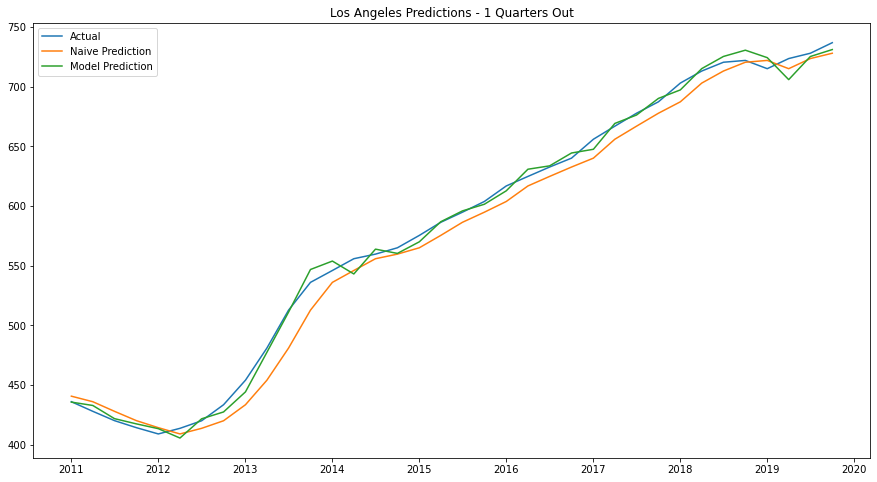

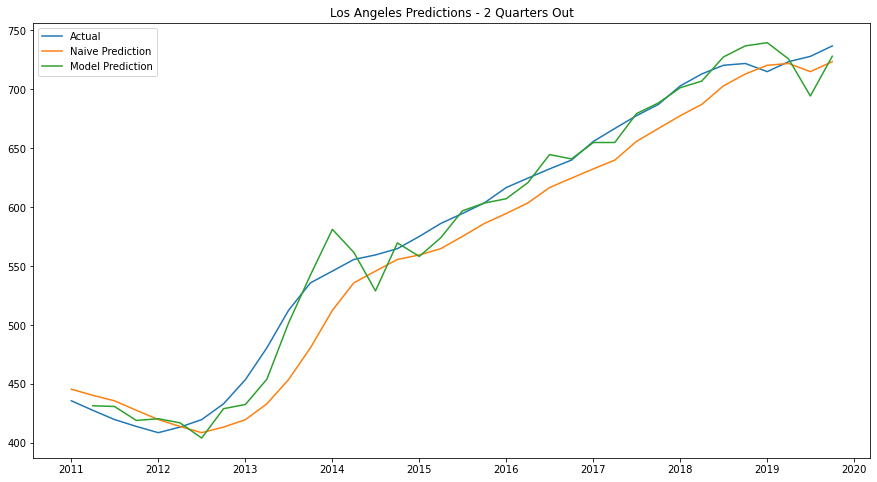

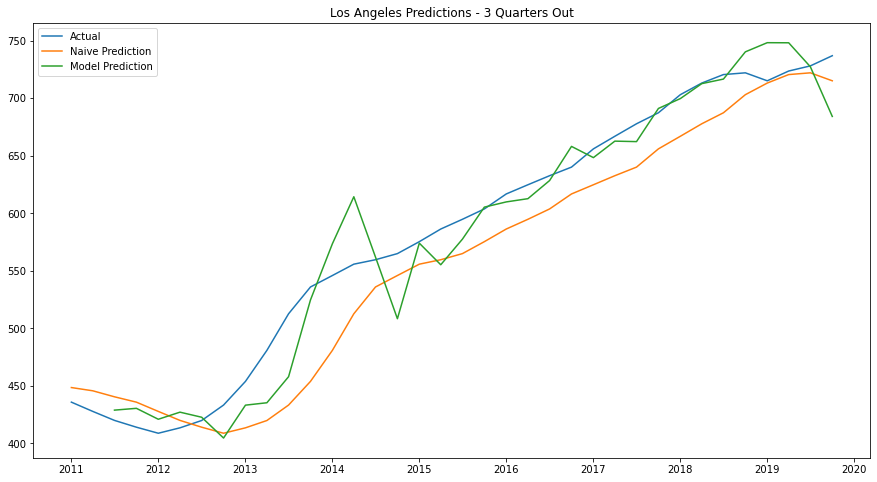

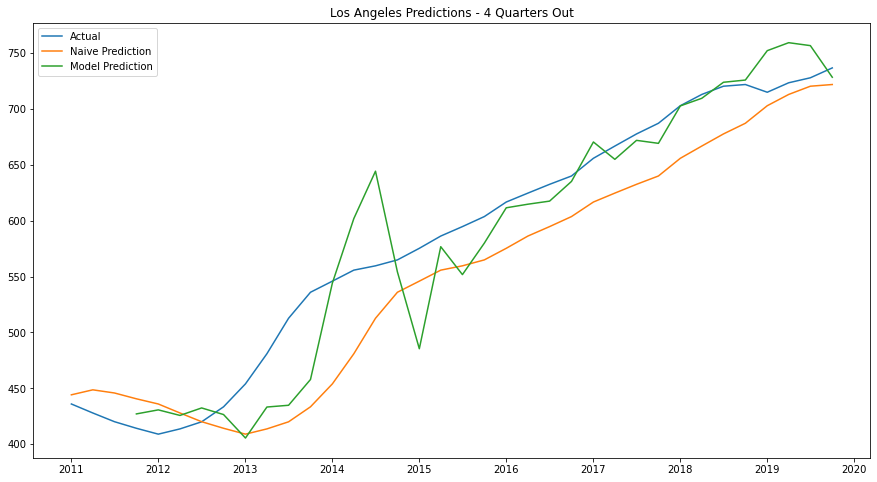

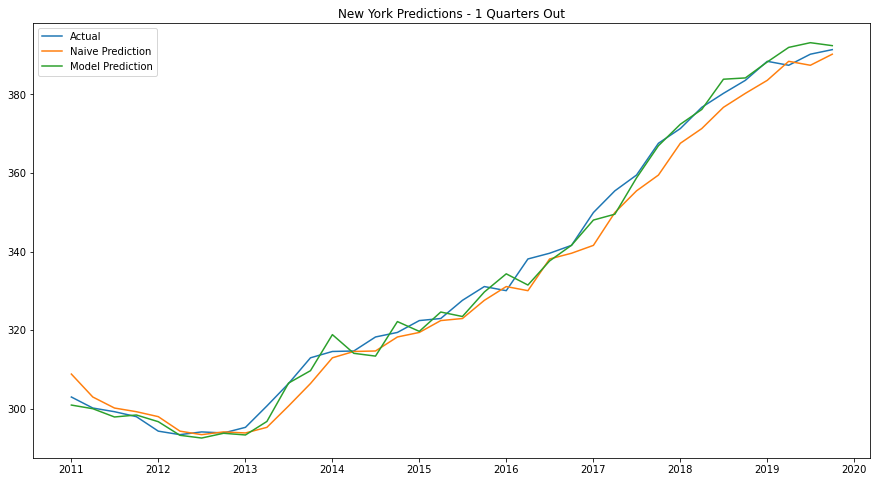

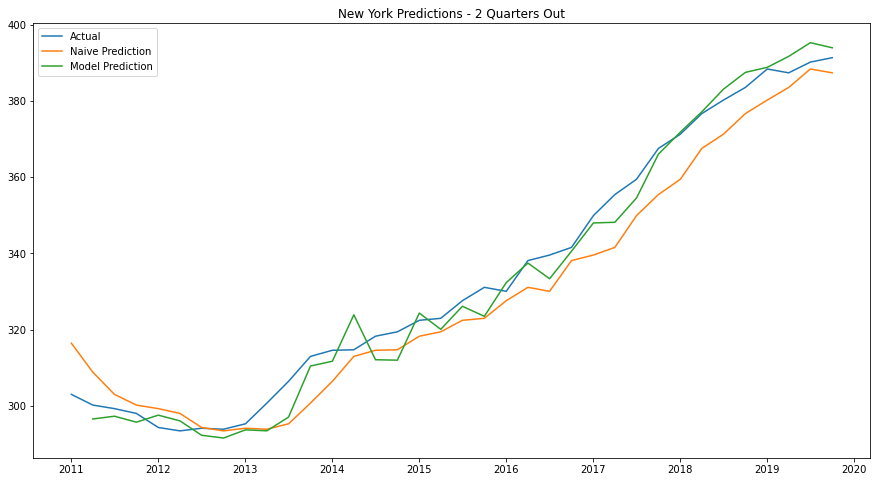

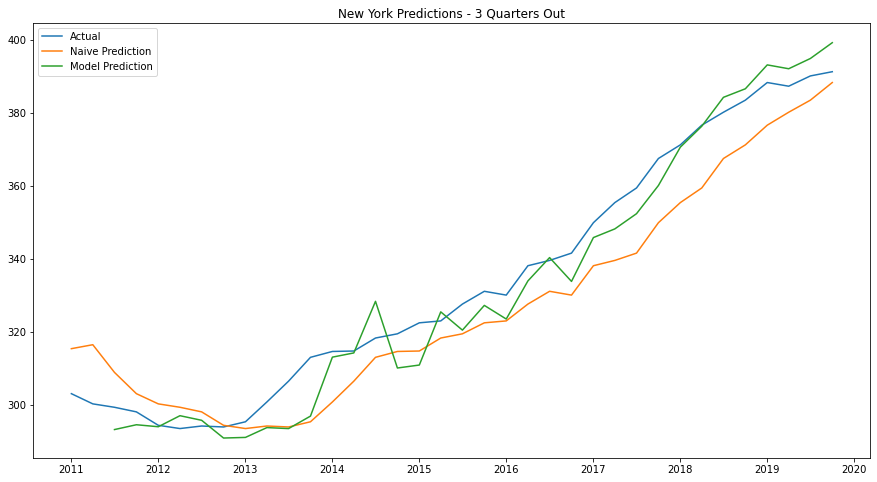

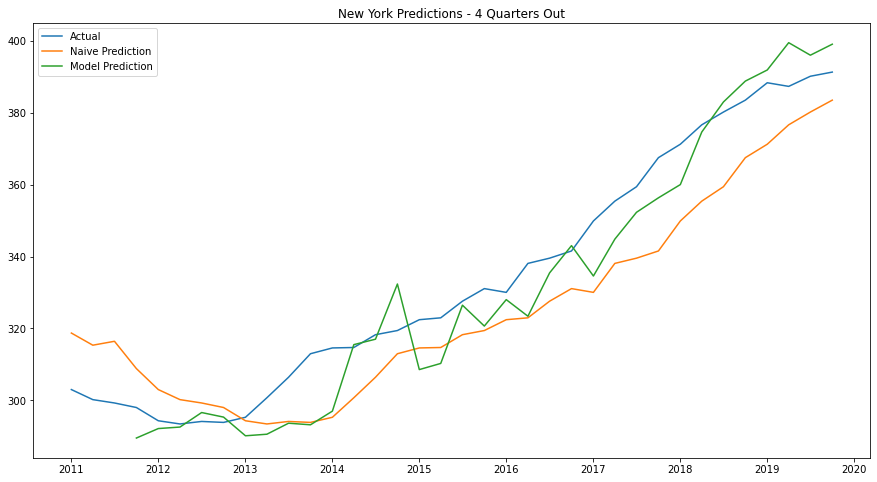

In [41]:
for city in best_model.city.unique():
    city_df = best_model[best_model.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(15,8))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.hpi, label='Actual')
        plt.plot(city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df[pred_col], label='Model Prediction')
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

Next Items on Agenda:
* Accounting for uncertainty
* FB Prophet
* Vector Methods
* Other Methods

#### Running Models - FB Prophet

In [55]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

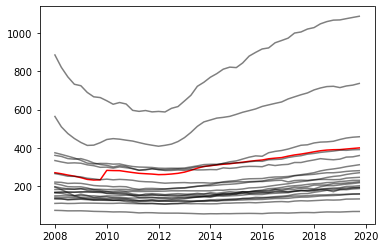

In [63]:
plt.plot(hpi.groupby(['date']).apply(w_avg, 'hpi', 'population'), color='red')
for city in hpi.city.unique():
    plt.plot(hpi[hpi.city == city].date, hpi[hpi.city == city].hpi, color='black', alpha=0.5)
    #print(hpi[hpi.city == city].hpi)

#### Prep for Modeling

In [3]:
metadata_cols = ['date', 'quarter', 'msa_state', 'year', 'city']
hpi_uni = hpi[['date', 'city', 'hpi']]

#### Functions

In [4]:
def AR_pred(data, city, lag, trend):
    
    # get data from one city and convert to array
    city_data = data[data.city == city].reset_index(drop=True)
    X = np.array(city_data.hpi)
    
    # set up df to store results
    results_df = city_data.set_index('date')['hpi'].to_frame()
    results_df = results_df.assign(pred_1=np.nan, pred_2=np.nan, pred_3=np.nan, pred_4=np.nan)
    
    # run predictions
    tscv = TimeSeriesSplit(n_splits=28, max_train_size=20, test_size=1)
    
    for train_index, test_index in tscv.split(X):
        X_train = X[train_index] # training set
        date = ny_uni.date[test_index[0]] # find date of first prediction
        ny_model = AutoReg(X_train, lags=lag, trend=trend).fit() # train model
        preds = ny_model.predict(X_train.shape[0], X_train.shape[0]+4) # predict 4 periods ahead
        
        # save results
        results_df.loc[date, 'pred_1'] = preds[0]
        results_df.loc[date, 'pred_2'] = preds[1]
        results_df.loc[date, 'pred_3'] = preds[2]
        results_df.loc[date, 'pred_4'] = preds[3]
        
    # shift predictions back to correct date
    results_df.pred_2 = results_df.pred_2.shift(1)
    results_df.pred_3 = results_df.pred_3.shift(2)
    results_df.pred_4 = results_df.pred_4.shift(3)
    
    # add in naive predictions (x_t+k = x_t for all k)
    results_df['naive_1'] = results_df.hpi.shift(1)
    results_df['naive_2'] = results_df.hpi.shift(2)
    results_df['naive_3'] = results_df.hpi.shift(3)
    results_df['naive_4'] = results_df.hpi.shift(4)

    return results_df[20:]

In [5]:
def evaluate_model(results_df, method='square'):
    
    # calculate diffs
    results_df = results_df.assign(diff_1=(results_df.pred_1-results_df.hpi)/results_df.hpi,
                  diff_2=(results_df.pred_2-results_df.hpi)/results_df.hpi,
                  diff_3=(results_df.pred_3-results_df.hpi)/results_df.hpi,
                  diff_4=(results_df.pred_4-results_df.hpi)/results_df.hpi,
                  diff_1_naive=(results_df.naive_1-results_df.hpi)/results_df.hpi,
                  diff_2_naive=(results_df.naive_2-results_df.hpi)/results_df.hpi,
                  diff_3_naive=(results_df.naive_3-results_df.hpi)/results_df.hpi,
                  diff_4_naive=(results_df.naive_4-results_df.hpi)/results_df.hpi)
    
    # list of difference columns
    diff_cols = [col for col in results_df.columns if 'diff' in col]                               
    
    # use square difference
    results_pos = results_df.copy()
    if method == 'square':
        results_pos[diff_cols] = results_pos[diff_cols] ** 2
        
    elif method == 'abs':
        results_pos[diff_cols] = np.abs(results_pos[diff_cols])
        
    else:
        raise ValueError('Choose a valid method for evaluation.')

    # calculate mse by city and lag value, caulculate winners
    mses = results_pos.groupby(['city', 'lag'])[diff_cols].mean().reset_index()

    mses = mses.assign(improve_1=(mses.diff_1_naive-mses.diff_1),
                 improve_2=(mses.diff_2_naive-mses.diff_2),
                 improve_3=(mses.diff_3_naive-mses.diff_3),
                 improve_4=(mses.diff_4_naive-mses.diff_4))


    mses = mses.assign(win_1=mses.improve_1 > 0,
                 win_2=mses.improve_2 > 0,
                 win_3=mses.improve_3 > 0,
                 win_4=mses.improve_4 > 0)
    
    
    # best lag by win rate
    win_cols = [col for col in mses.columns if 'win' in col]
    win_rate = mses.groupby(['lag'])[win_cols].sum().sum(axis=1)/mses.groupby(['lag'])[win_cols].count().sum(axis=1)
    
    # best lag by minimum error
    pred_cols = [col for col in mses.columns if 'diff' in col and 'naive' not in col]
    avg_mse = mses.groupby(['lag'])[pred_cols].mean().mean(axis=1)
    
    # best lag by max improvement
    improve_cols = [col for col in mses.columns if 'improve' in col]
    avg_improvement = mses.groupby(['lag'])[improve_cols].mean().mean(axis=1)
    
    # return all three metrics
    return win_rate, avg_mse, avg_improvement
    

In [6]:
def plot_model_eval(results_df, method='square'):
    win, error, improvement = evaluate_model(results_df, method=method)
    plt.figure(figsize=(10,6))
    plt.plot(win, label='Win Rate')
    plt.title('Win Rate')
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(error, label='MSE')
    plt.plot(improvement, label='Improvement over Naive')
    plt.title('Error Measures')
    plt.legend()
    plt.show()

In [95]:
hpi_no_overlap = hpi.copy()

In [96]:
hpi_no_overlap.loc[hpi_no_overlap.city != hpi_no_overlap.city.shift(1), 'hpi'] = np.nan

In [97]:
hpi_no_overlap[hpi_no_overlap.city != hpi_no_overlap.city.shift(1)].hpi

0     NaN
48    NaN
96    NaN
144   NaN
192   NaN
240   NaN
288   NaN
336   NaN
384   NaN
432   NaN
480   NaN
528   NaN
576   NaN
624   NaN
672   NaN
720   NaN
768   NaN
816   NaN
864   NaN
912   NaN
Name: hpi, dtype: float64

In [ ]:
hpi_error = 

In [118]:
ac_vals = []
pac_vals = []
for x in range (1, 21):
    ac_vals.append(hpi.groupby(['city'])['hpi'].apply(pd.Series.autocorr, lag=x).mean())
    pac_vals.append(hpi.groupby(['city'])['hpi'].apply(pacf, nlags=x).mean()[-1])

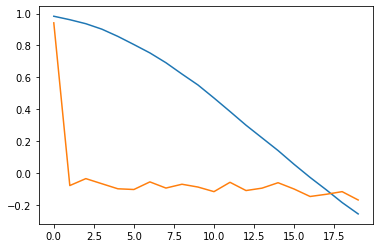

In [120]:
plt.plot(ac_vals)
plt.plot(pac_vals)

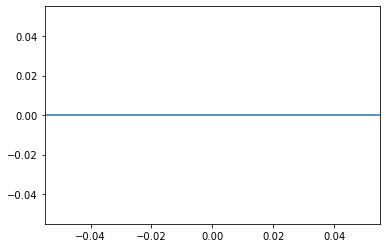

In [98]:
plt.acorr(hpi_no_overlap.hpi)
plt.show()

In [555]:
ar_results = pd.DataFrame()

for city in hpi_uni.city.unique():
    for lag in range(1, 9):
        func_result = AR_pred(hpi_uni, city, lag, 'ct')
        func_result['city'] = city
        func_result['lag'] = lag
        ar_results = pd.concat([ar_results, func_result])

In [614]:
win, error, improvement = evaluate_model(ar_results, method='abs')

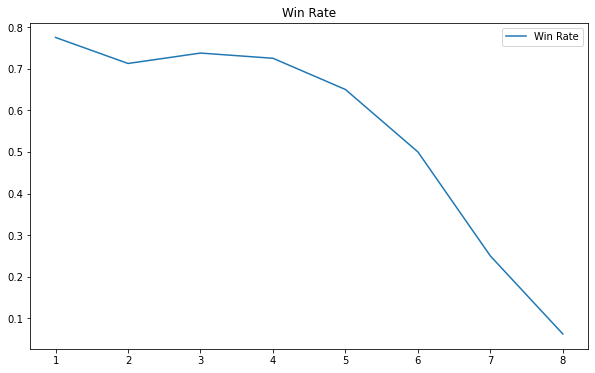

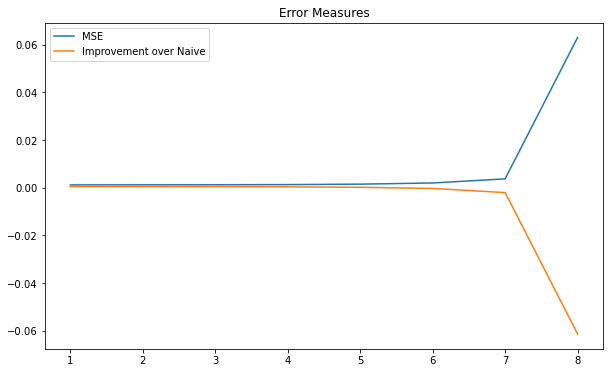

In [639]:
plot_model_eval(ar_results, method='square')

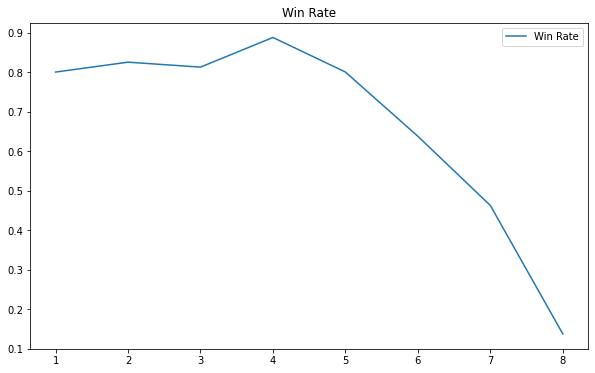

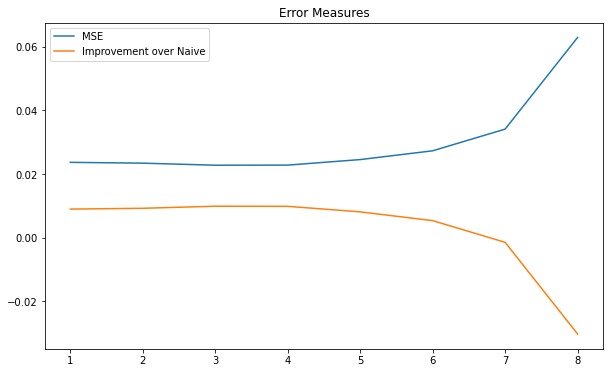

In [638]:
plot_model_eval(ar_results, method='abs')

#### Depending on loss metric, use lag 1 or 4

In [162]:
def ARIMA_pred(data, city, order=(1,1,1), trend='ct'):
    
    # get data from one city and convert to array
    city_data = data[data.city == city].reset_index(drop=True)
    X = np.array(city_data.hpi)
    
    # set up df to store results
    results_df = city_data.set_index('date')['hpi'].to_frame()
    results_df = results_df.assign(pred_1=np.nan, pred_2=np.nan, pred_3=np.nan, pred_4=np.nan)
    
    # run predictions
    tscv = TimeSeriesSplit(n_splits=28, max_train_size=20, test_size=1)
    
    for train_index, test_index in tscv.split(X):
        X_train = X[train_index] # training set
        date = city_data.date[test_index[0]] # find date of first prediction
        city_model = ARIMA(X_train, order=order, trend=trend).fit() # train model
        preds = city_model.predict(X_train.shape[0], X_train.shape[0]+4) # predict 4 periods ahead
        
        # save results
        results_df.loc[date, 'pred_1'] = preds[0]
        results_df.loc[date, 'pred_2'] = preds[1]
        results_df.loc[date, 'pred_3'] = preds[2]
        results_df.loc[date, 'pred_4'] = preds[3]
        results_df.loc[date, 'AIC'] = city_model.aic
        
    # shift predictions back to correct date
    results_df.pred_2 = results_df.pred_2.shift(1)
    results_df.pred_3 = results_df.pred_3.shift(2)
    results_df.pred_4 = results_df.pred_4.shift(3)
    
    # add in naive predictions (x_t+k = x_t for all k)
    results_df['naive_1'] = results_df.hpi.shift(1)
    results_df['naive_2'] = results_df.hpi.shift(2)
    results_df['naive_3'] = results_df.hpi.shift(3)
    results_df['naive_4'] = results_df.hpi.shift(4)

    return results_df[20:]

In [217]:
# get data from one city and convert to array
city = 'New York'
data=hpi
city_data = data[data.city == city].reset_index(drop=True)
order=(4,2,2)
trend='n'
X = np.array(city_data.hpi)

# set up df to store results
results_df = city_data.set_index('date')['hpi'].to_frame()
results_df = results_df.assign(pred_1=np.nan, pred_2=np.nan, pred_3=np.nan, pred_4=np.nan)

# run predictions
tscv = TimeSeriesSplit(n_splits=36, max_train_size=12, test_size=1)

for train_index, test_index in tscv.split(X):
    print(train_index, test_index)
    X_train = X[train_index] # training set
    date = city_data.date[test_index[0]] # find date of first prediction
    city_model = ARIMA(X_train, order=order, trend=trend).fit()
    print(city_model.aic)

[ 0  1  2  3  4  5  6  7  8  9 10 11] [12]
68.36890148748914
[ 1  2  3  4  5  6  7  8  9 10 11 12] [13]
1855940.4861201474
[ 2  3  4  5  6  7  8  9 10 11 12 13] [14]
72.74478811696306
[ 3  4  5  6  7  8  9 10 11 12 13 14] [15]
1896947.724950338
[ 4  5  6  7  8  9 10 11 12 13 14 15] [16]
12741878.801046176
[ 5  6  7  8  9 10 11 12 13 14 15 16] [17]
64.77025622413683
[ 6  7  8  9 10 11 12 13 14 15 16 17] [18]
104996.56674138068
[ 7  8  9 10 11 12 13 14 15 16 17 18] [19]
61.06700269354274
[ 8  9 10 11 12 13 14 15 16 17 18 19] [20]
61.028250779693806
[ 9 10 11 12 13 14 15 16 17 18 19 20] [21]
7436807.065645322
[10 11 12 13 14 15 16 17 18 19 20 21] [22]
54.73189795169934
[11 12 13 14 15 16 17 18 19 20 21 22] [23]
323841.82671829616
[12 13 14 15 16 17 18 19 20 21 22 23] [24]
416739.22180598584
[13 14 15 16 17 18 19 20 21 22 23 24] [25]
404772.41278368083
[14 15 16 17 18 19 20 21 22 23 24 25] [26]
467650.84109494404
[15 16 17 18 19 20 21 22 23 24 25 26] [27]
458178.7542287812
[16 17 18 19 20 

LinAlgError: LU decomposition error.

In [166]:
def evaluate_model(results_df, method='square'):
    
    # calculate diffs
    results_df = results_df.assign(diff_1=(results_df.pred_1-results_df.hpi)/results_df.hpi,
                  diff_2=(results_df.pred_2-results_df.hpi)/results_df.hpi,
                  diff_3=(results_df.pred_3-results_df.hpi)/results_df.hpi,
                  diff_4=(results_df.pred_4-results_df.hpi)/results_df.hpi,
                  diff_1_naive=(results_df.naive_1-results_df.hpi)/results_df.hpi,
                  diff_2_naive=(results_df.naive_2-results_df.hpi)/results_df.hpi,
                  diff_3_naive=(results_df.naive_3-results_df.hpi)/results_df.hpi,
                  diff_4_naive=(results_df.naive_4-results_df.hpi)/results_df.hpi)
    
    # list of difference columns
    diff_cols = [col for col in results_df.columns if 'diff' in col]                               
    
    # use square difference
    results_pos = results_df.copy()
    if method == 'square':
        results_pos[diff_cols] = results_pos[diff_cols] ** 2
        
    elif method == 'abs':
        results_pos[diff_cols] = np.abs(results_pos[diff_cols])
        
    else:
        raise ValueError('Choose a valid method for evaluation.')

    # calculate mse by city and lag value, caulculate winners
    mses = results_pos.groupby(['city', 'p', 'd', 'q'])[diff_cols].mean().reset_index()

    mses = mses.assign(improve_1=(mses.diff_1_naive-mses.diff_1),
                 improve_2=(mses.diff_2_naive-mses.diff_2),
                 improve_3=(mses.diff_3_naive-mses.diff_3),
                 improve_4=(mses.diff_4_naive-mses.diff_4))


    mses = mses.assign(win_1=mses.improve_1 > 0,
                 win_2=mses.improve_2 > 0,
                 win_3=mses.improve_3 > 0,
                 win_4=mses.improve_4 > 0)
    
    
    # best lag by win rate
    win_cols = [col for col in mses.columns if 'win' in col]
    win_rate = mses.groupby(['p', 'd', 'q'])[win_cols].sum().sum(axis=1)/mses.groupby(['p', 'd', 'q'])[win_cols].count().sum(axis=1)
    
    # best lag by minimum error
    pred_cols = [col for col in mses.columns if 'diff' in col and 'naive' not in col]
    avg_mse = mses.groupby(['p', 'd', 'q'])[pred_cols].mean().mean(axis=1)
    
    # best lag by max improvement
    improve_cols = [col for col in mses.columns if 'improve' in col]
    avg_improvement = mses.groupby(['p', 'd', 'q'])[improve_cols].mean().mean(axis=1)
    
    # best AIC
    AIC = results_df.groupby(['p', 'd', 'q']).AIC.mean()
    
    # return all three metrics
    return win_rate, avg_mse, avg_improvement, AIC
    

In [687]:
ma_results = pd.DataFrame()

for city in hpi_uni.city.unique():
    for lag in range(1, 9):
        func_result = ARIMA_pred(hpi_uni, city, (0,0,lag), 'ct')
        func_result['city'] = city
        func_result['lag'] = lag
        ma_results = pd.concat([ma_results, func_result])

In [22]:
arma_results = pd.DataFrame()

for city in hpi_uni.city.unique():
    for lag in range(1, 5):
        func_result = ARIMA_pred(hpi_uni, city, (lag,0,lag), 'ct')
        func_result['city'] = city
        func_result['lag'] = lag
        arma_results = pd.concat([arma_results, func_result])

In [24]:
win, error, improvement = evaluate_model(arma_results, method='square')

In [27]:
improvement

lag
1   -0.000430
2   -0.000568
3   -0.000247
4   -0.000207
dtype: float64

In [31]:
arima_results = pd.DataFrame()

for city in hpi_uni.city.unique():
    for lag in range(1, 4):
        func_result = ARIMA_pred(hpi_uni, city, (lag,lag,lag), trend='n')
        func_result['city'] = city
        func_result['lag'] = lag
        arima_results = pd.concat([arima_results, func_result])

In [177]:
arima_results2 = pd.DataFrame()

for city in hpi_uni.city.unique():
    for p in range(1,5):
        for d in range(1,3):
            for q in range(0, 2):
                try:
                    func_result = ARIMA_pred(hpi_uni, city, (p,d,q), trend='n')
                    func_result['city'] = city
                    func_result['p'] = p
                    func_result['d'] = d
                    func_result['q'] = q
                    arima_results2 = pd.concat([arima_results2, func_result])
                except:
                    pass

In [178]:
arima_results2

hpi      pred_1      pred_2      pred_3      pred_4  \
date                                                                     
2013-01-01  290.267204  290.811463         NaN         NaN         NaN   
2013-04-01  295.031844  290.340175  291.107317         NaN         NaN   
2013-07-01  301.581545  296.710335  290.368512  291.226866         NaN   
2013-10-01  302.708953  304.178117  297.301635  290.379517  291.275174   
2014-01-01  307.876238  303.238271  305.207505  297.509939  290.383790   
...                ...         ...         ...         ...         ...   
2018-10-01  383.538057  385.306797  387.981741  387.275470  393.251019   
2019-01-01  388.377299  387.580493  389.131734  393.754724  392.548314   
2019-04-01  387.369467  391.581722  390.758967  393.285617  400.220742   
2019-07-01  390.188390  390.928309  395.235726  393.896024  397.610994   
2019-10-01  391.347352  392.187374  392.843493  399.516972  397.530114   

                   AIC     naive_1     naive_2     naive_3     naive_4  \
date                                                                     
2013-01-01  128.441302  290.079303  288.267398  286.536022  286.710502   
2013-04-01  128.415591  290.267204  290.079303  288.267398  286.536022   
2013-07-01  126.404336  295.031844  290.267204  290.079303  288.267398   
2013-10-01  126.484474  301.581545  295.031844  290.267204  290.079303   
2014-01-01  125.074009  302.708953  301.581545  295.031844  290.267204   
...                ...         ...         ...         ...         ...   
2018-10-01   89.775575  380.226346  376.674261  371.271774  367.531294   
2019-01-01   90.190541  383.538057  380.226346  376.674261  371.271774   
2019-04-01   89.753558  388.377299  383.538057  380.226346  376.674261   
2019-07-01   92.204682  387.369467  388.377299  383.538057  380.226346   
2019-10-01   90.884514  390.188390  387.369467  388.377299  383.538057   

                  city  p  d  q  
date                             
2013-01-01  Charleston  1  1  0  
2013-04-01  Charleston  1  1  0  
2013-07-01  Charleston  1  1  0  
2013-10-01  Charleston  1  1  0  
2014-01-01  Charleston  1  1  0  
...                ... .. .. ..  
2018-10-01    New York  4  2  1  
2019-01-01    New York  4  2  1  
2019-04-01    New York  4  2  1  
2019-07-01    New York  4  2  1  
2019-10-01    New York  4  2  1  

[8932 rows x 14 columns]

In [179]:
win, error, improvement, AIC = evaluate_model(arima_results2, method='square')

In [189]:
AIC

p  d  q
1  1  0    98.036971
      1    97.172355
   2  0    95.885962
      1    92.457916
2  1  0    98.133408
      1    98.109564
   2  0    92.318722
      1    91.540822
3  1  0    96.730117
      1    97.257352
   2  0    92.138796
      1    92.360248
4  1  0    97.326221
      1    98.106087
   2  0    92.064252
      1    93.545830
Name: AIC, dtype: float64

In [192]:
error

p  d  q
1  1  0    0.001095
      1    0.000852
   2  0    0.000992
      1    0.000669
2  1  0    0.000938
      1    0.000851
   2  0    0.000660
      1    0.000603
3  1  0    0.000715
      1    0.000697
   2  0    0.000560
      1    0.000570
4  1  0    0.000676
      1    0.000686
   2  0    0.000547
      1    0.000579
dtype: float64

In [193]:
improvement

p  d  q
1  1  0    0.000608
      1    0.000851
   2  0    0.000712
      1    0.001034
2  1  0    0.000766
      1    0.000852
   2  0    0.001043
      1    0.001100
3  1  0    0.000989
      1    0.001006
   2  0    0.001144
      1    0.001133
4  1  0    0.001027
      1    0.001017
   2  0    0.001157
      1    0.001127
dtype: float64

In [188]:
improvement

p  d  q
1  1  0    0.000608
      1    0.000851
   2  0    0.000712
      1    0.001034
2  1  0    0.000766
      1    0.000852
   2  0    0.001043
      1    0.001100
3  1  0    0.000989
      1    0.001006
   2  0    0.001144
      1    0.001133
4  1  0    0.001027
      1    0.001017
   2  0    0.001157
      1    0.001127
dtype: float64

In [201]:
mean_aics = arima_results2.groupby(['city']).AIC.mean()

In [202]:
mean_pops = hpi.groupby(['city']).population.mean()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


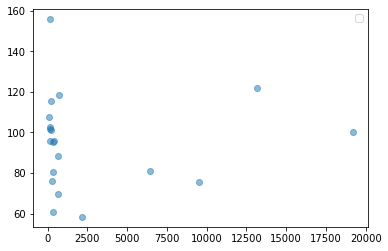

In [207]:
plt.scatter(x=mean_pops, y=mean_aics, alpha=0.5)
plt.legend()

In [138]:
win, error, improvement = evaluate_model(arima_results, method='square')

KeyError: 'p'

In [38]:
arima_2 = arima_results.query('lag==2')

In [194]:
best_model = arima_results2.query("p==2 & d==2&q==1")

In [42]:
arima_2_melt = arima_2.melt(id_vars=['city', 'lag'])

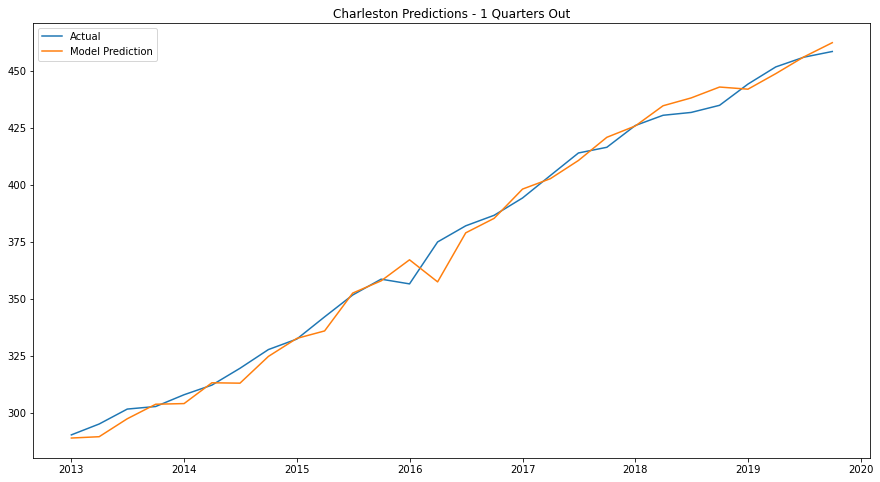

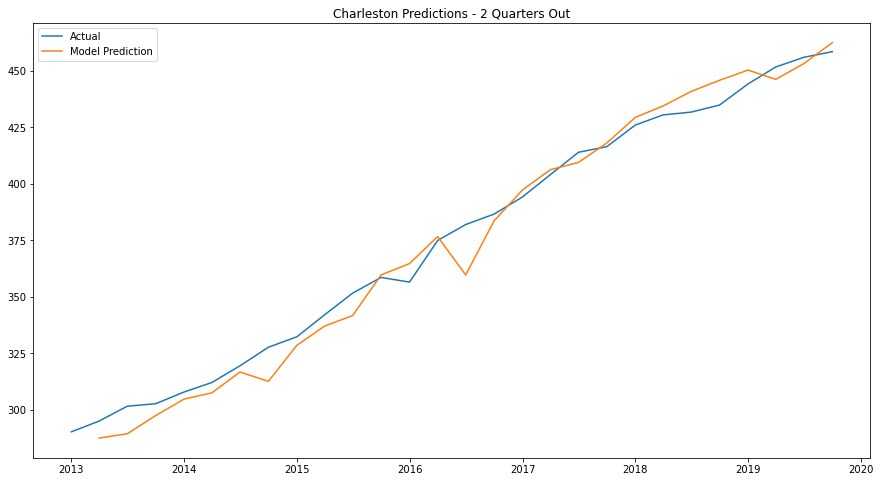

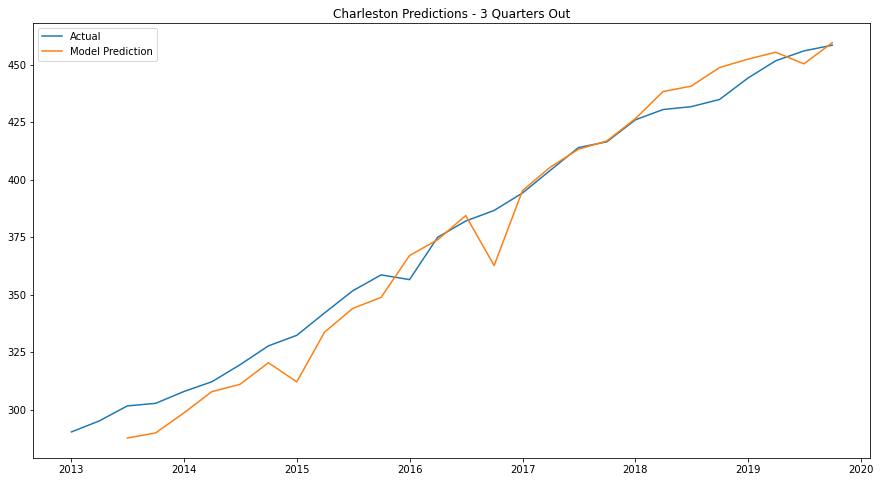

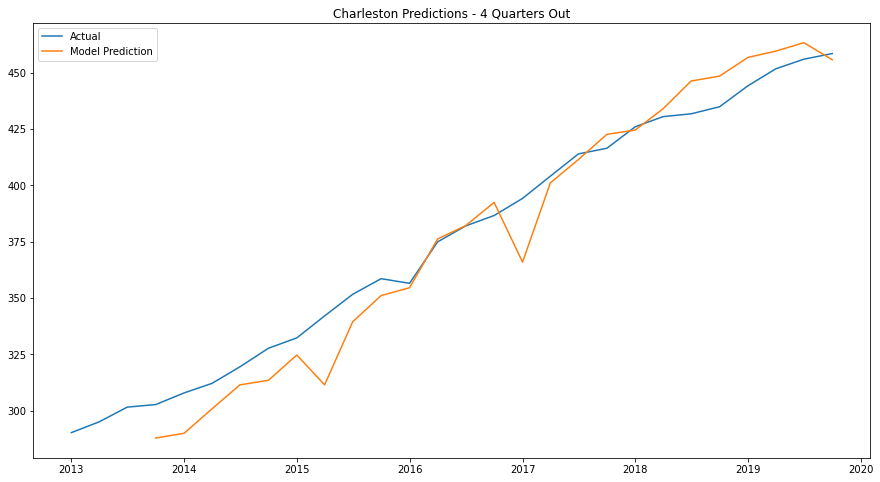

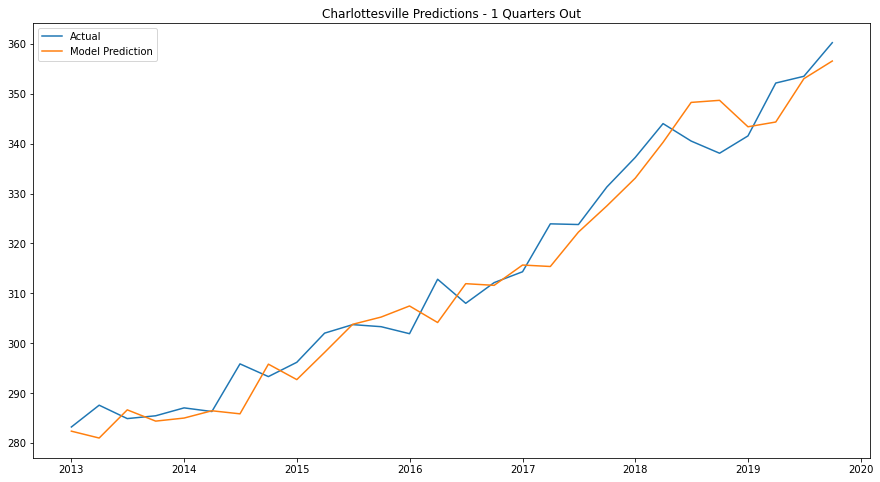

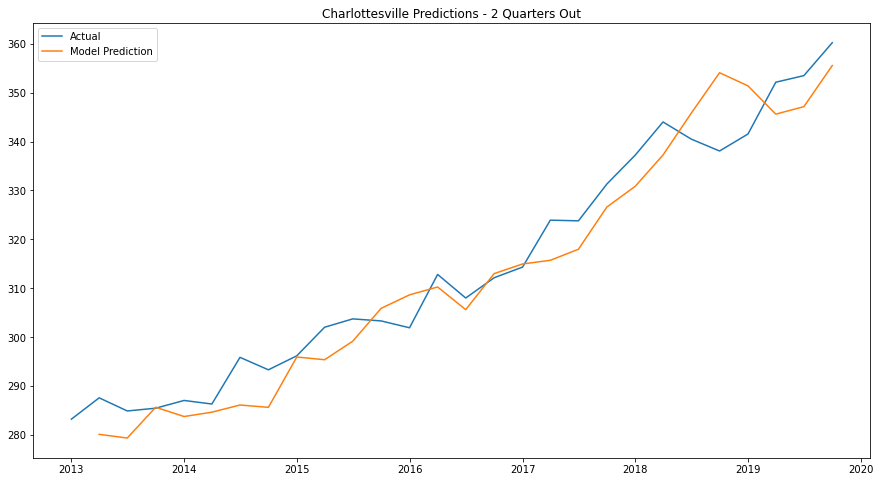

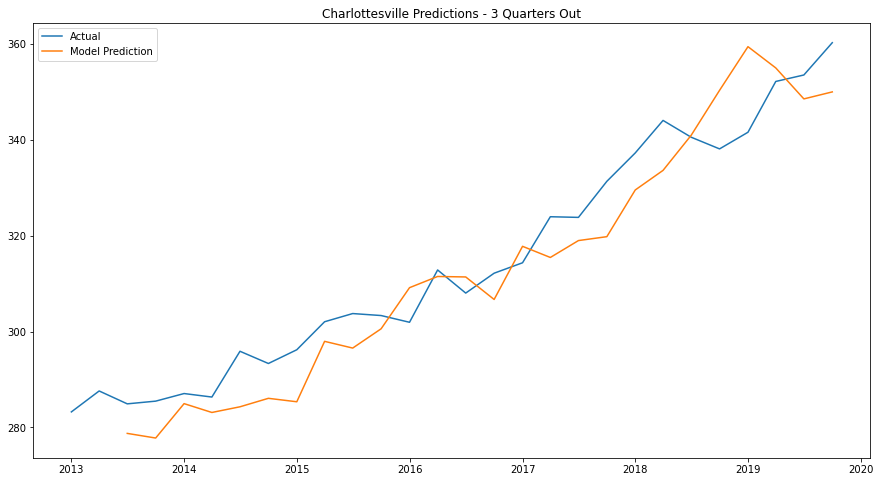

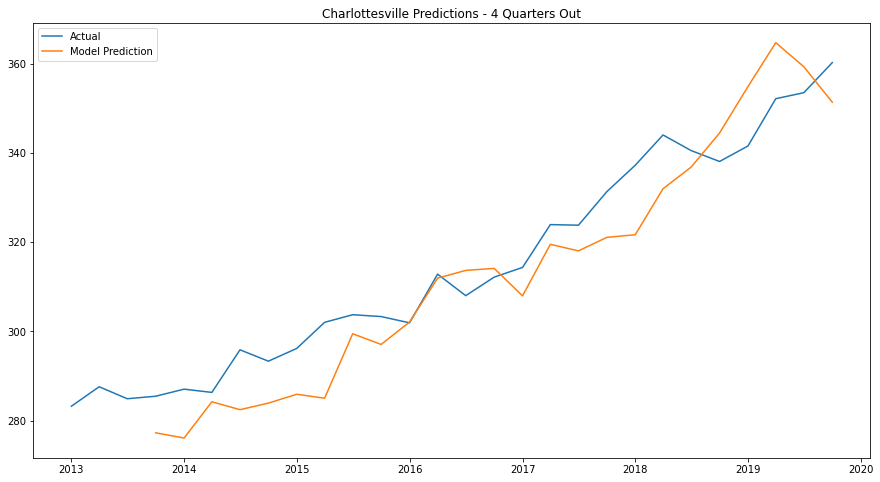

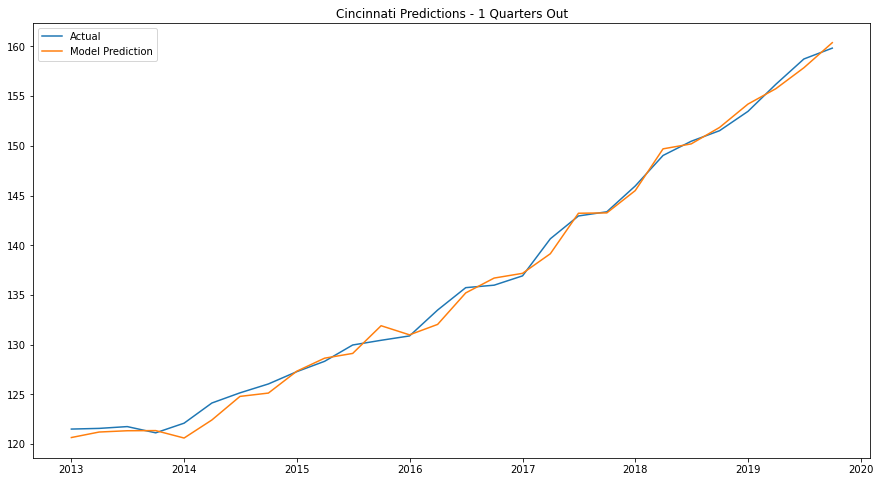

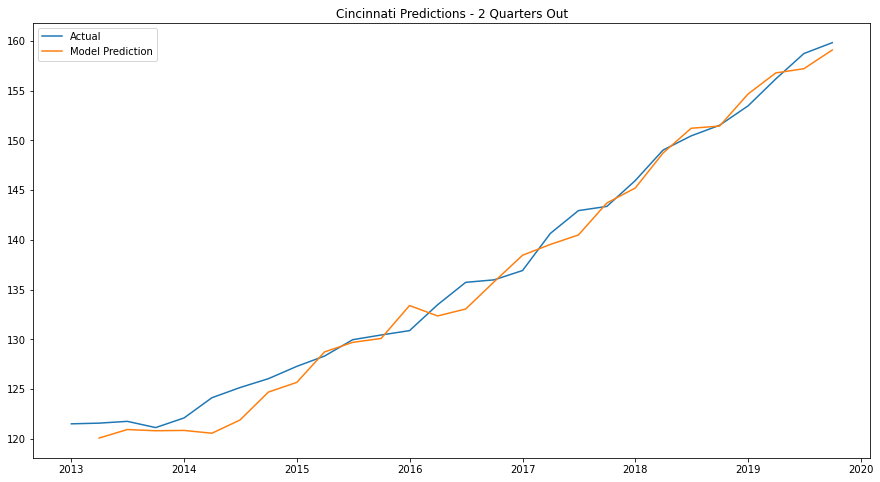

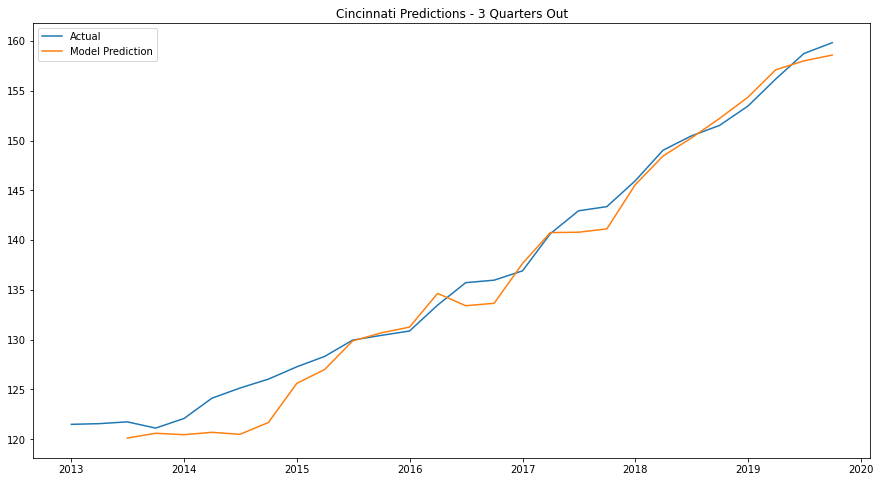

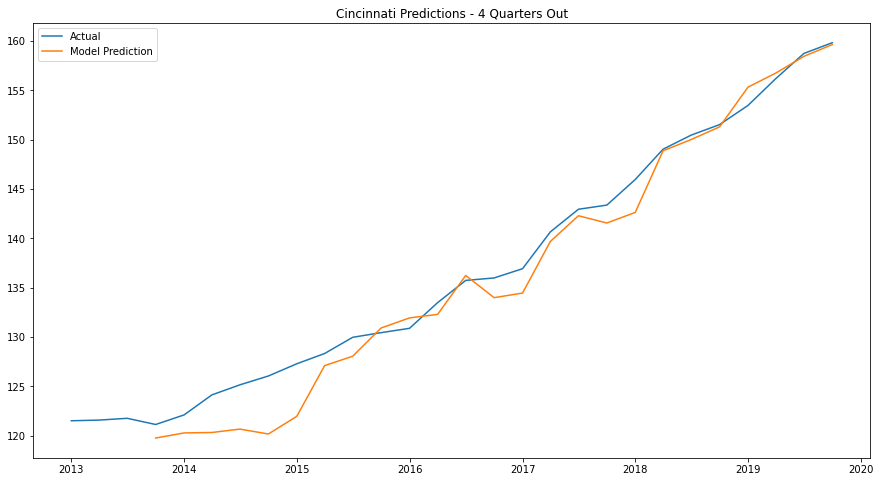

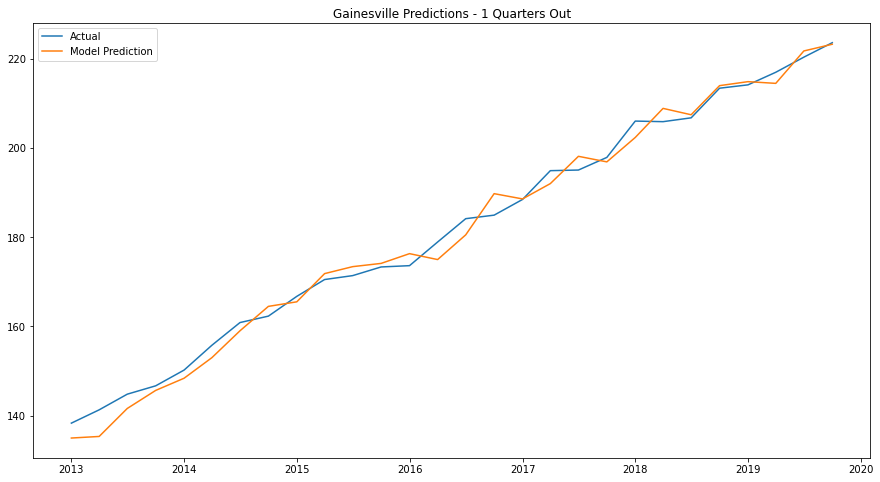

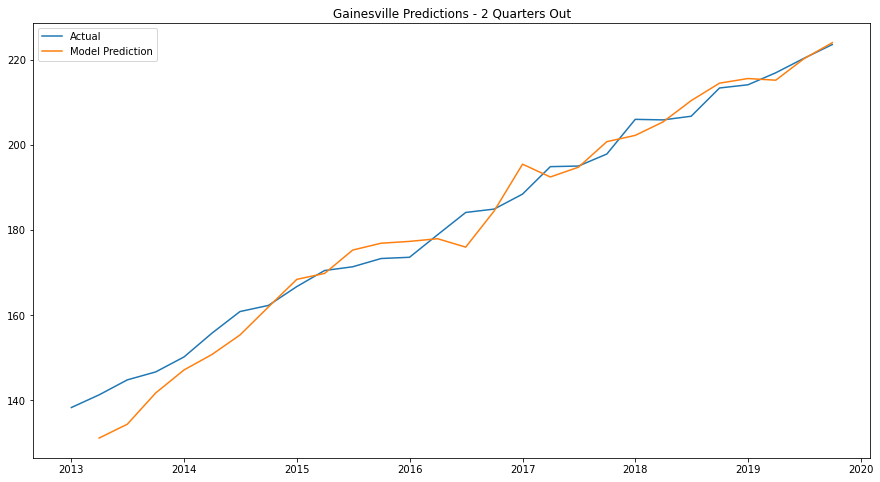

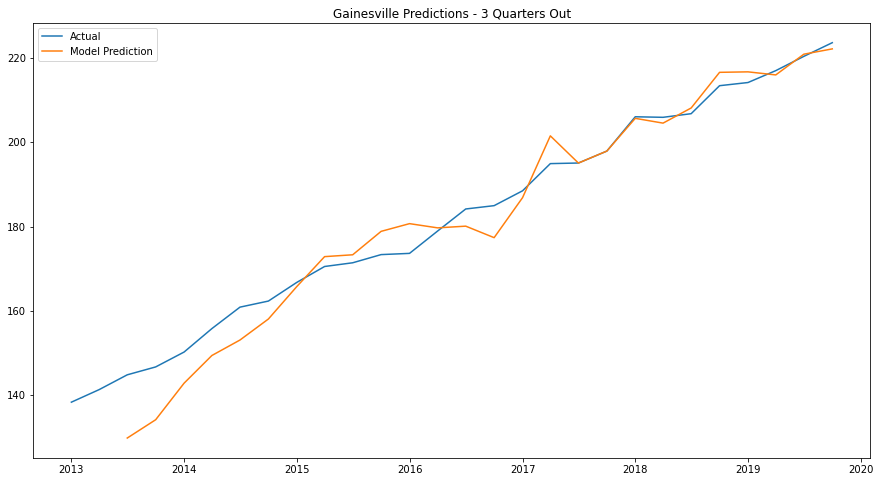

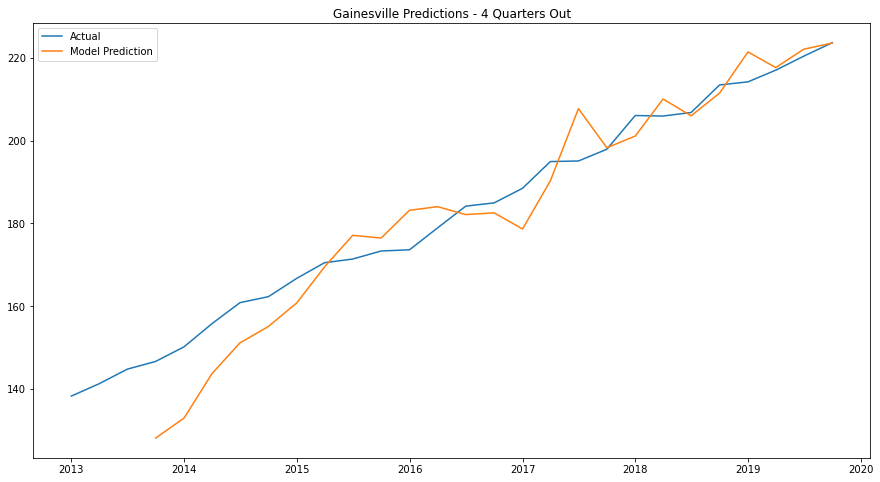

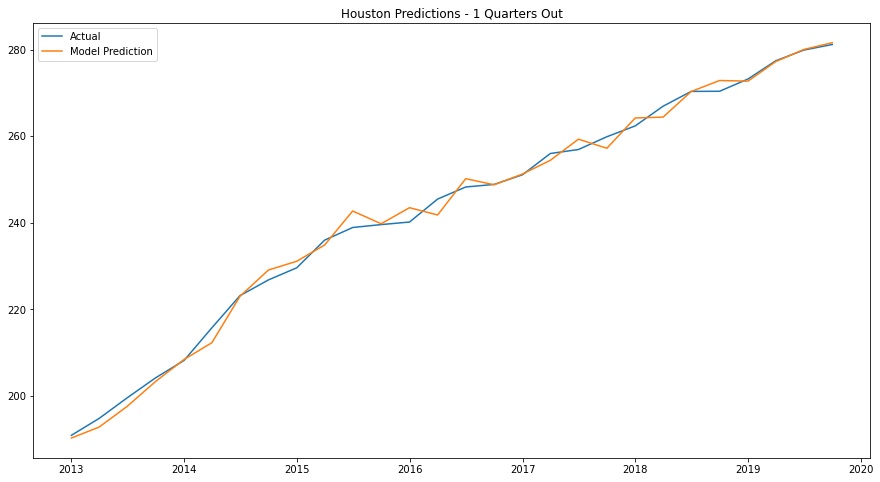

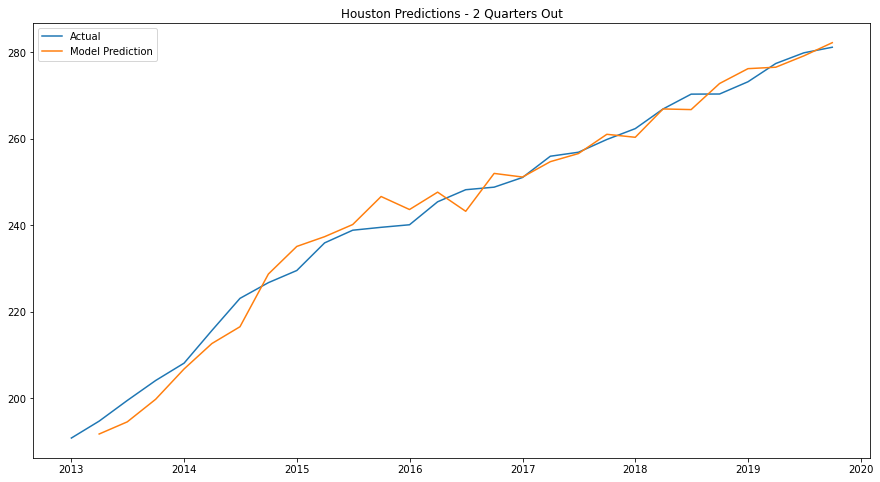

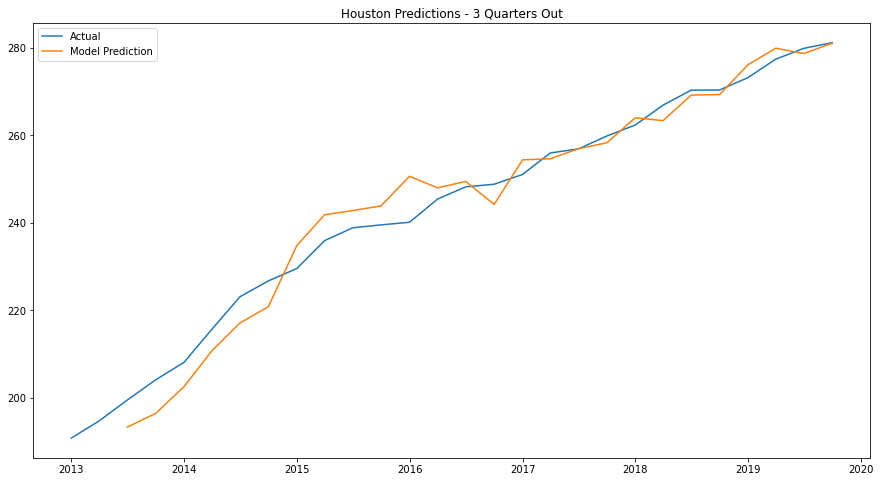

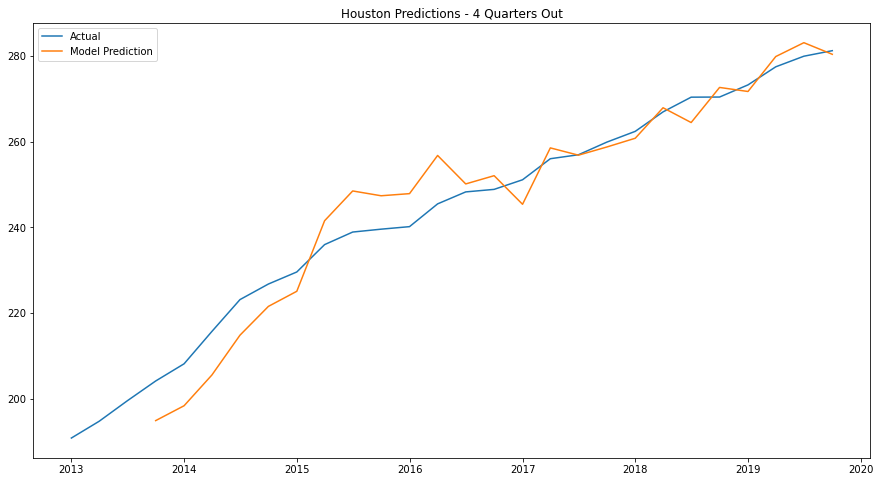

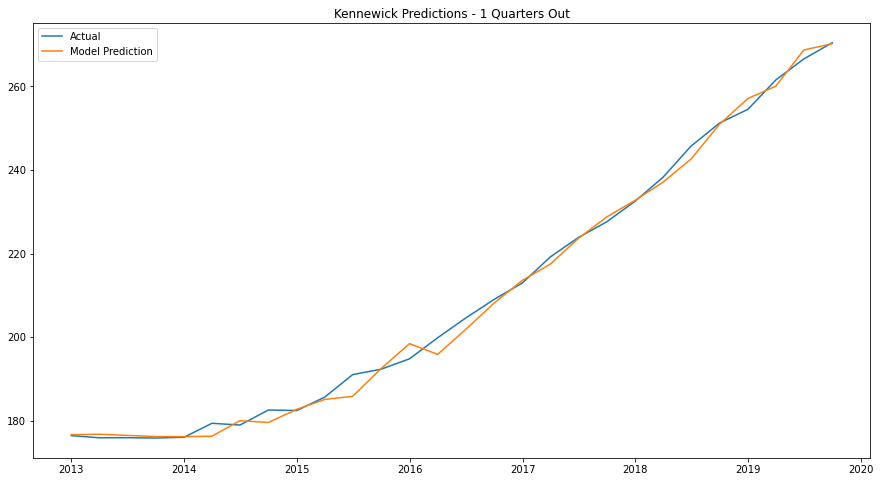

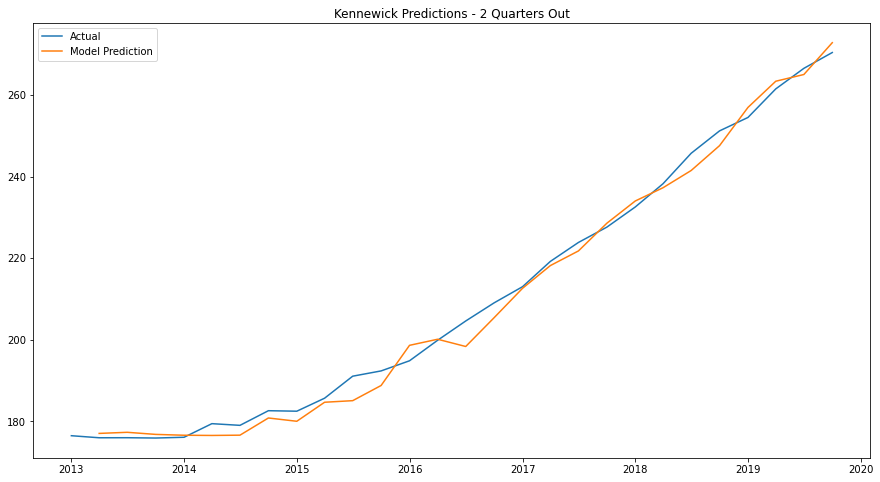

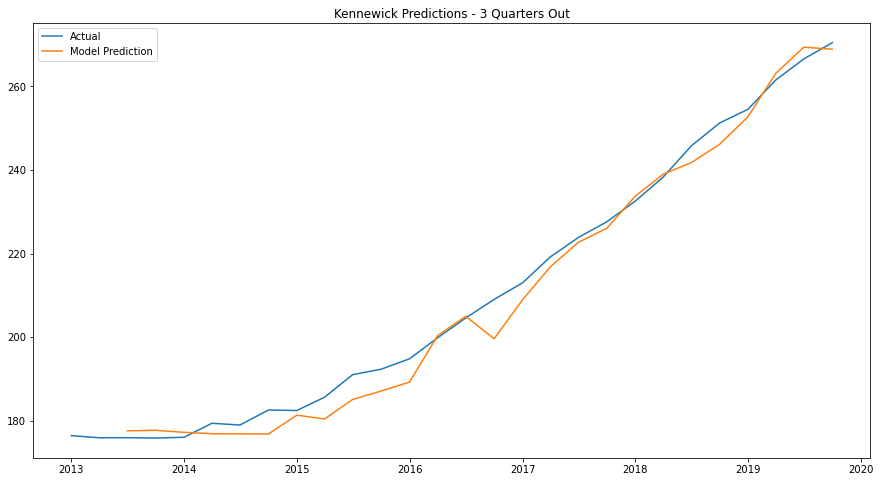

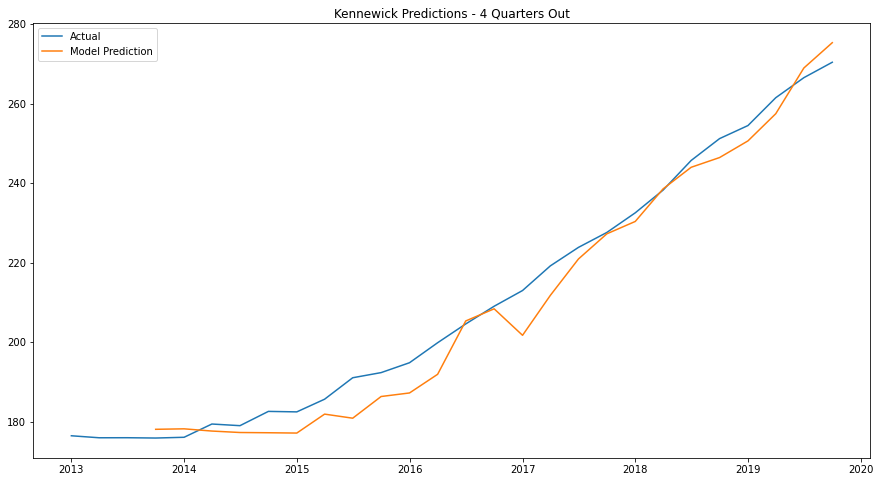

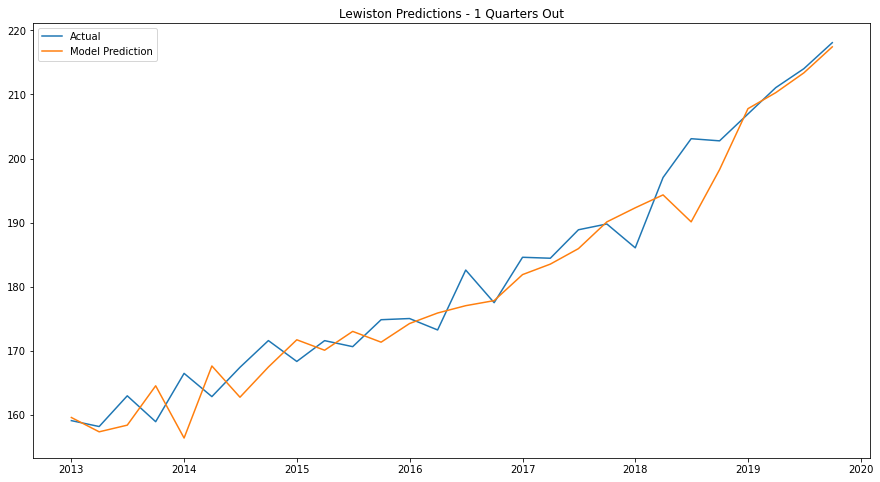

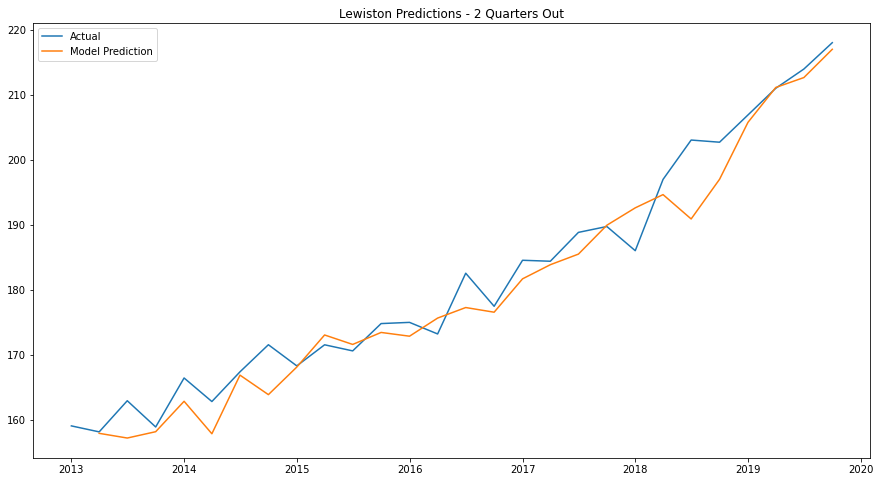

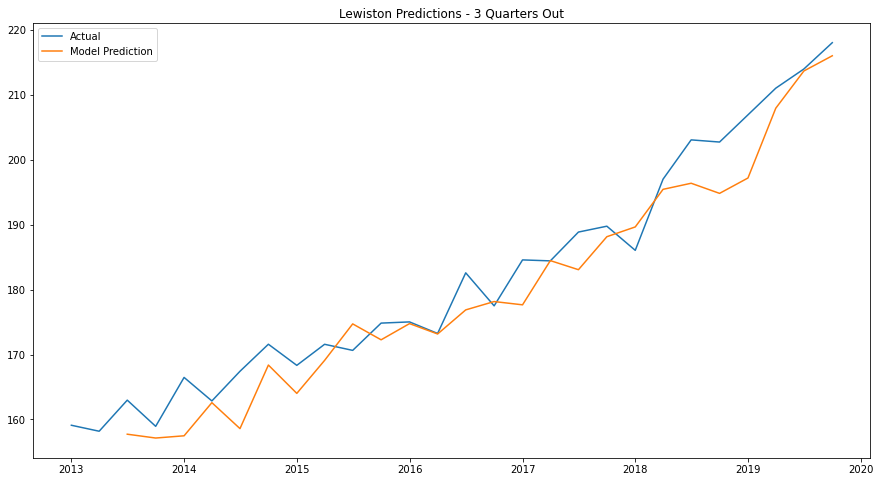

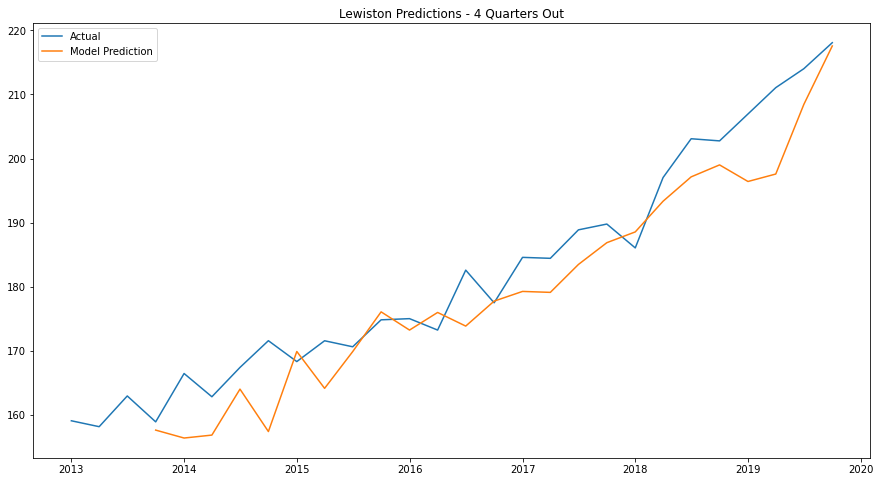

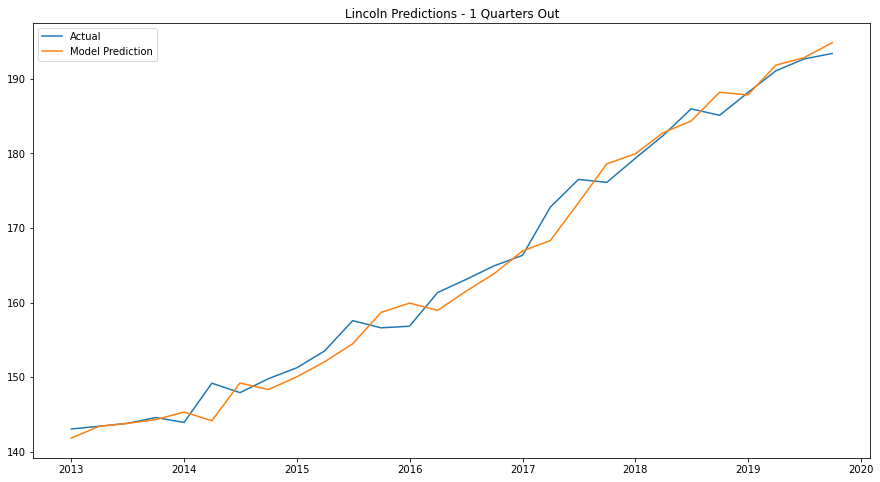

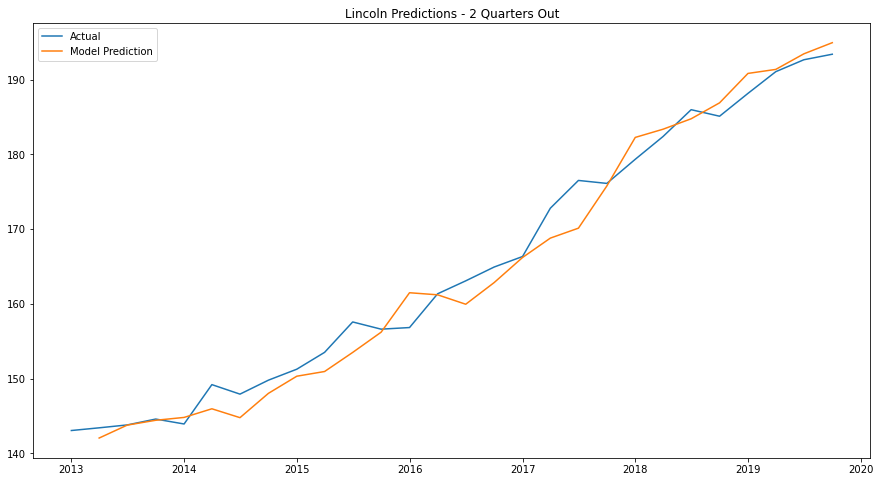

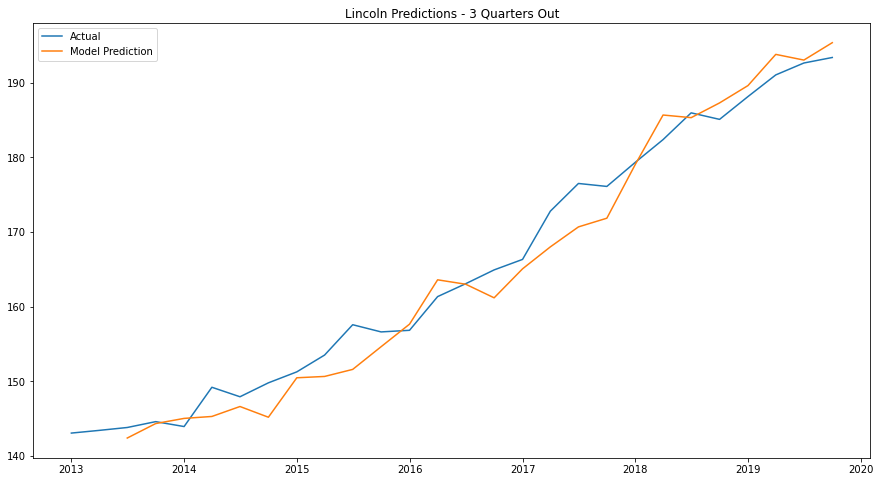

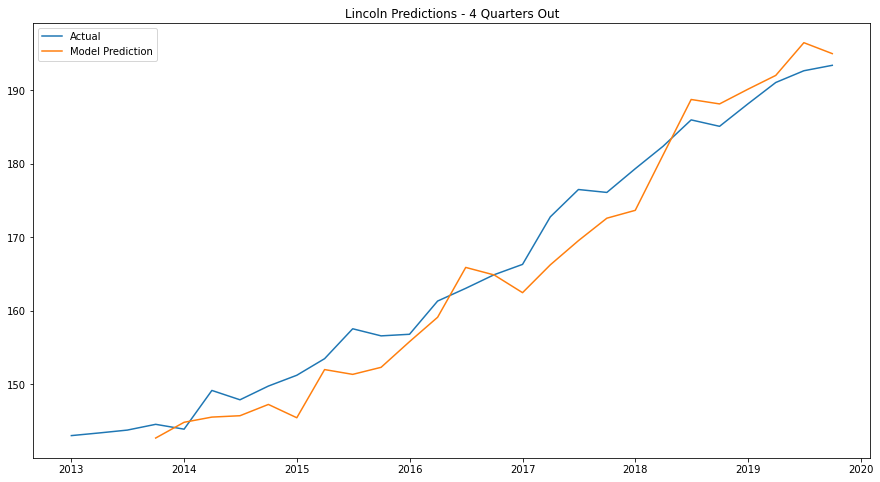

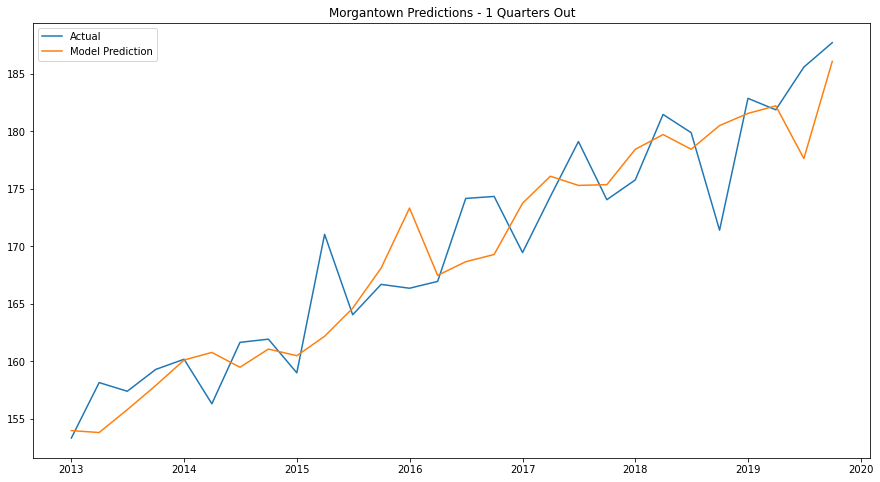

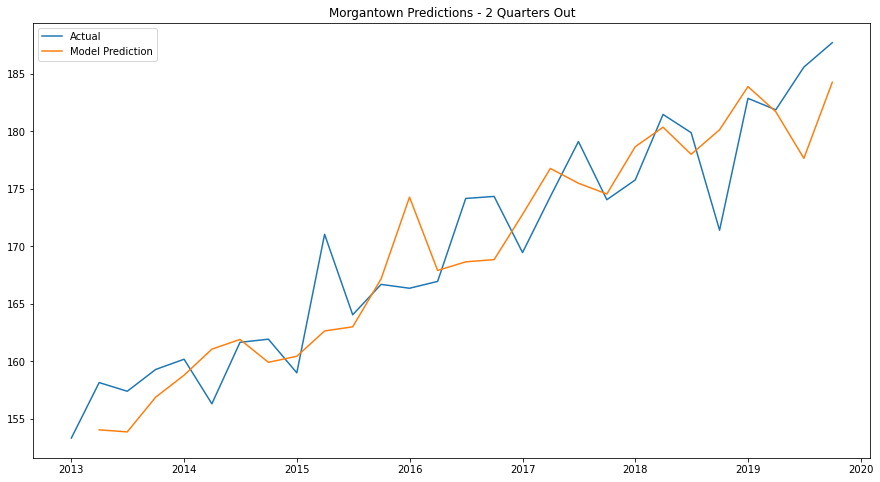

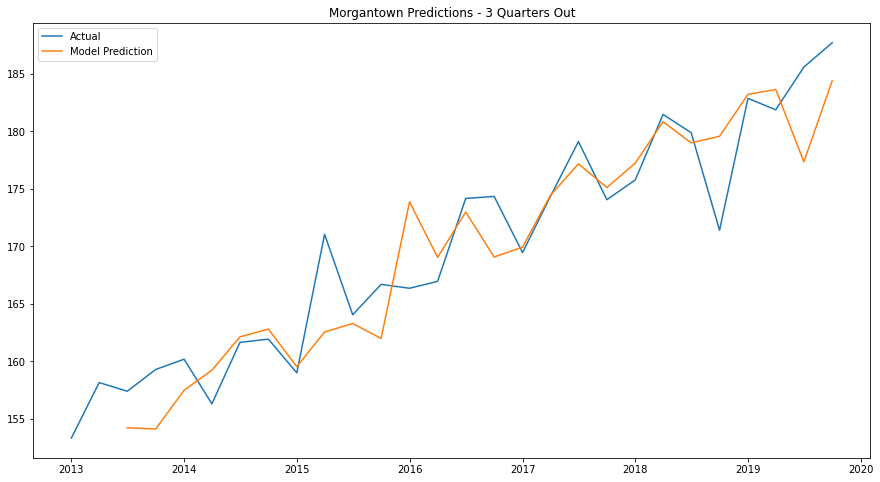

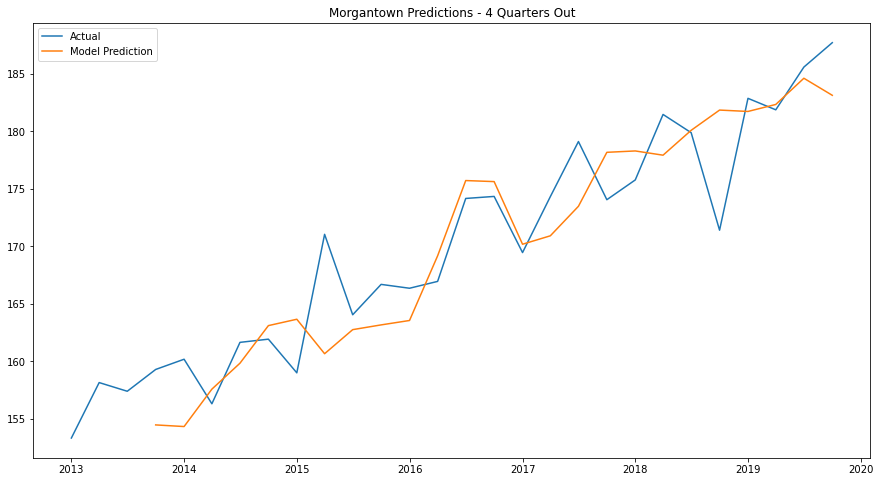

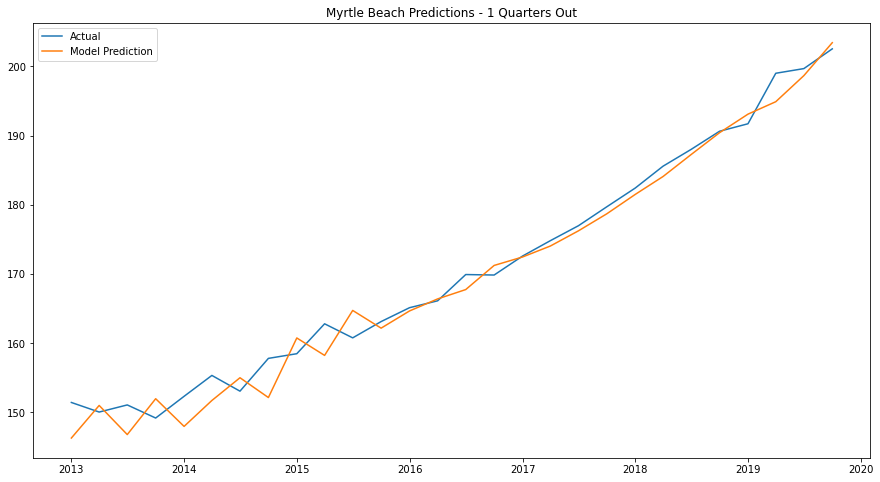

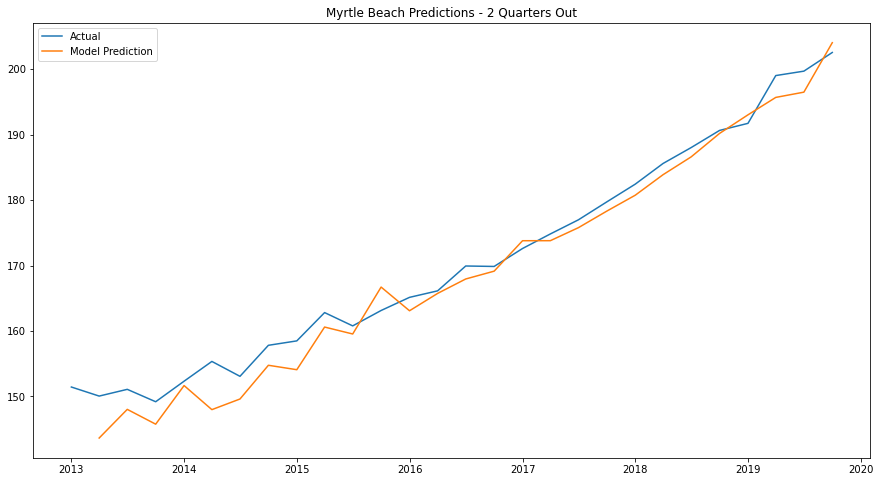

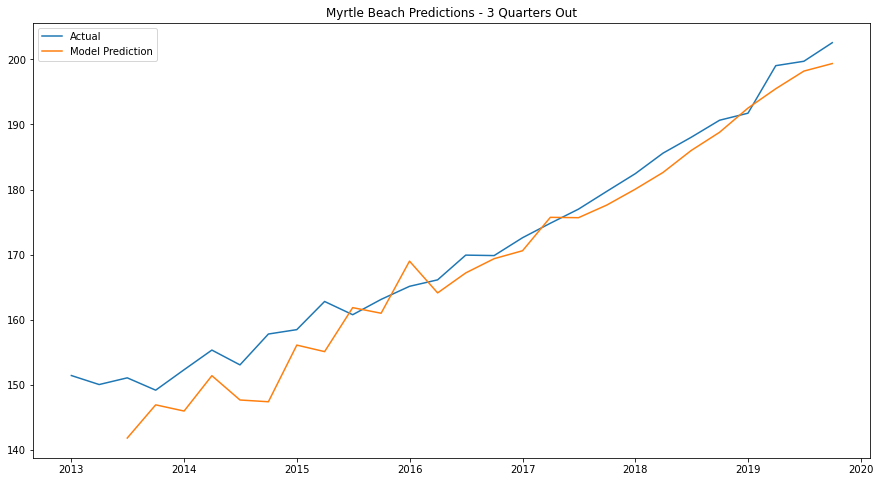

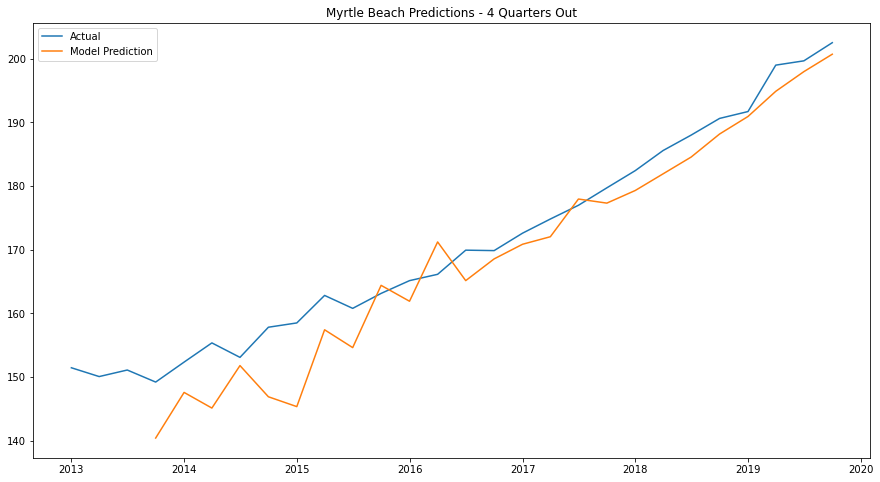

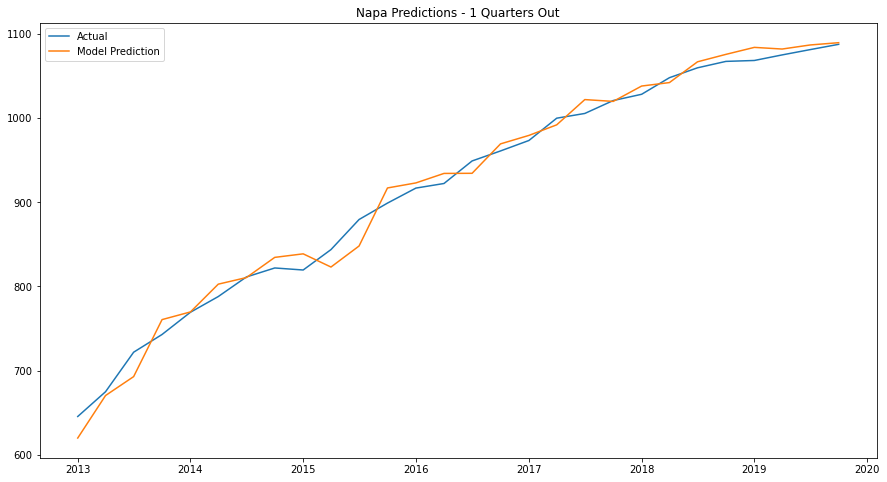

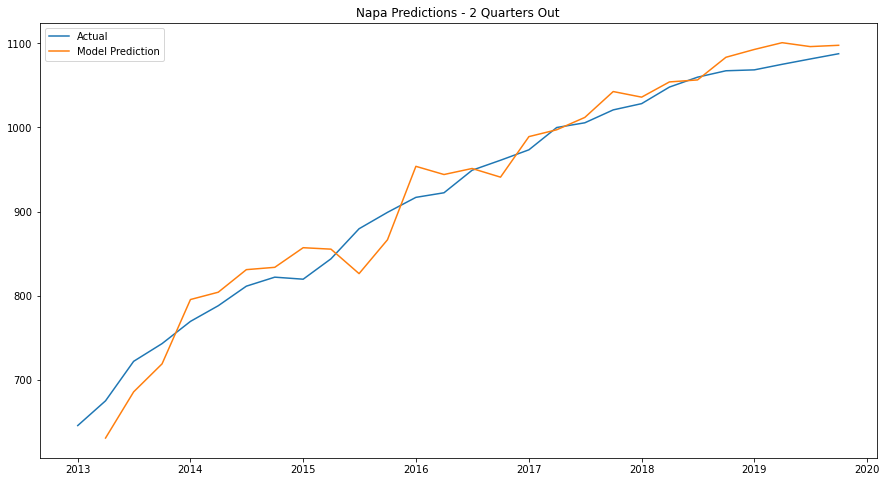

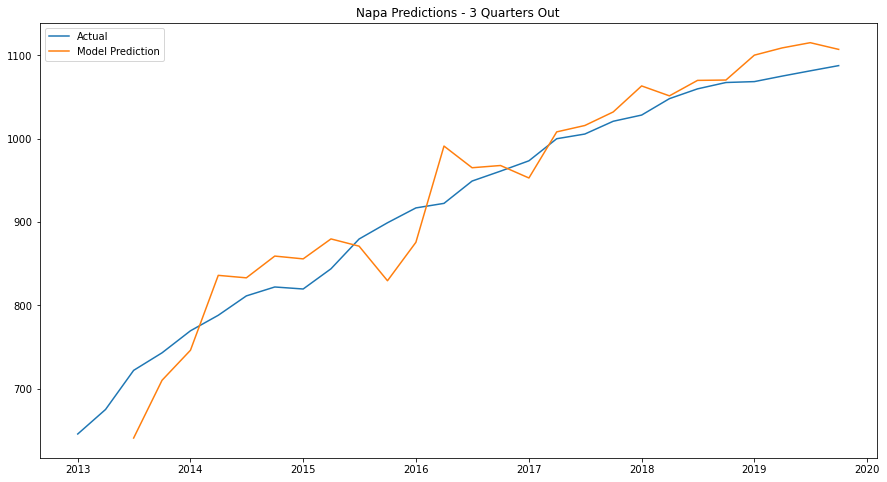

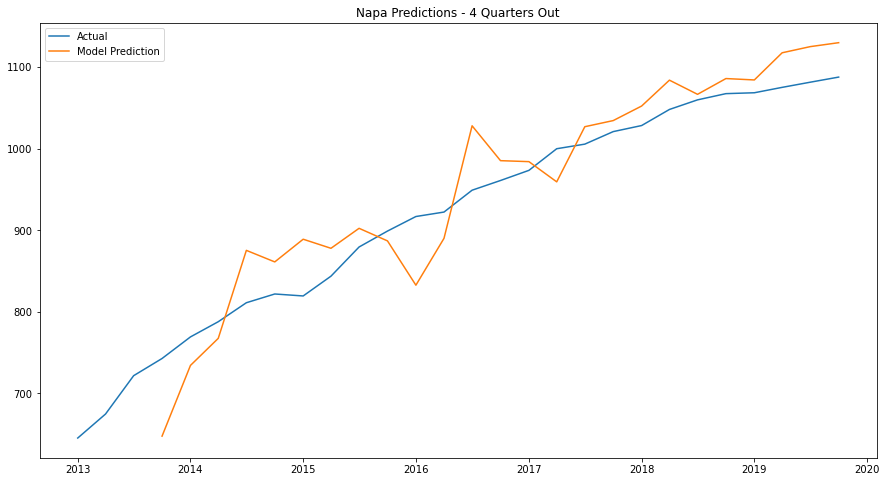

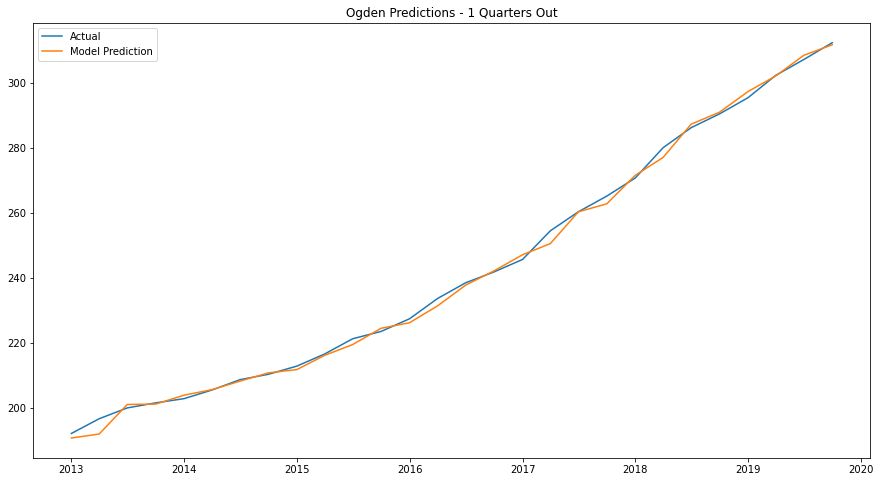

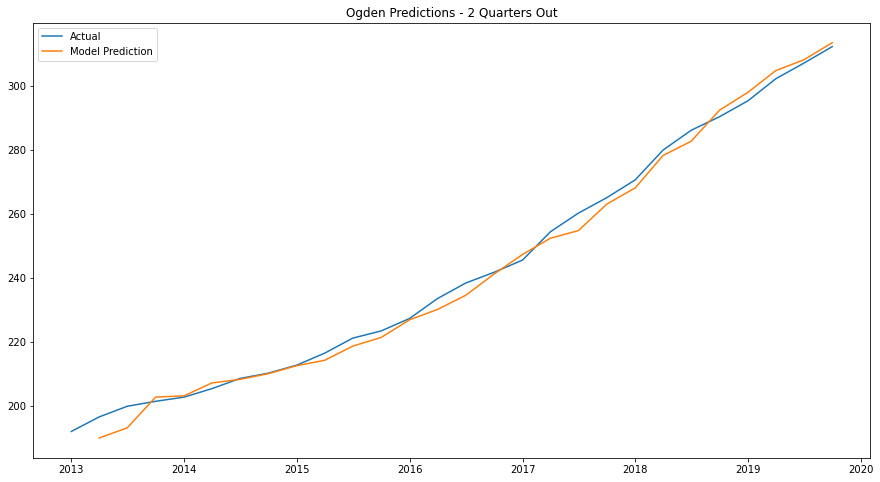

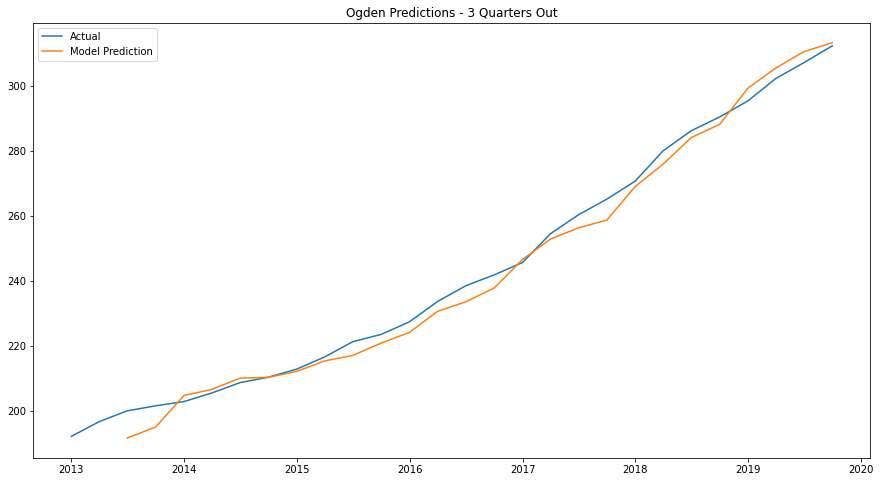

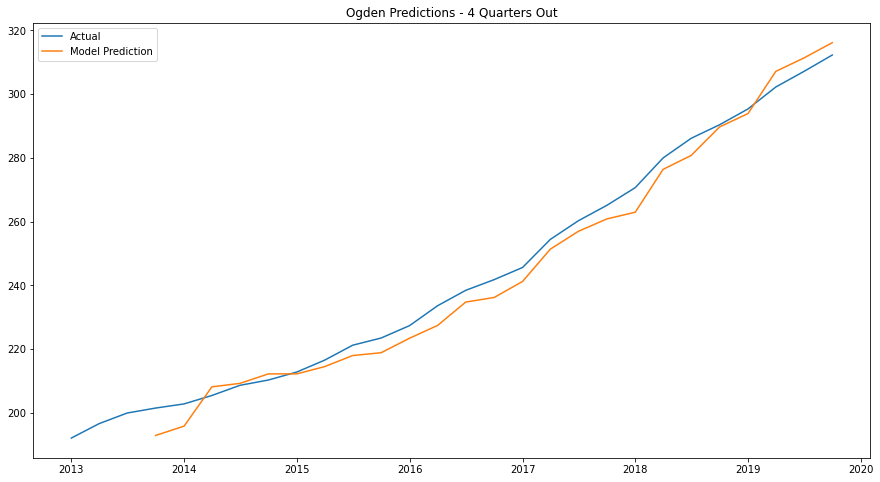

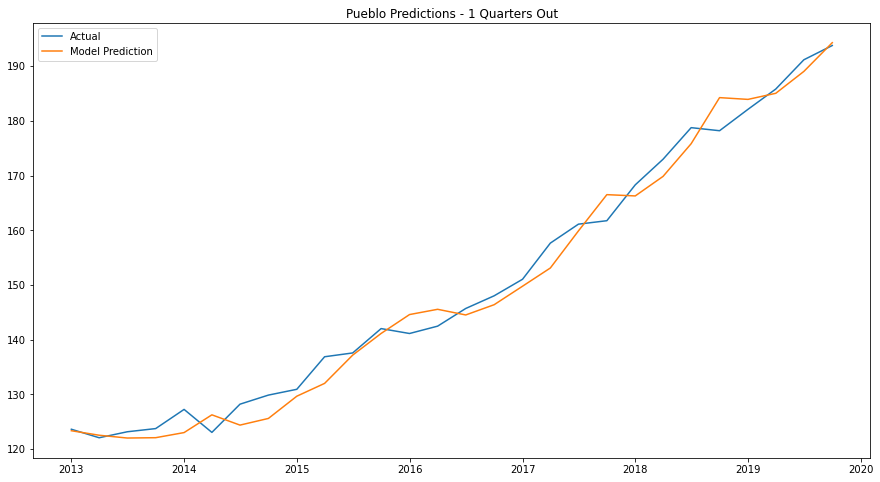

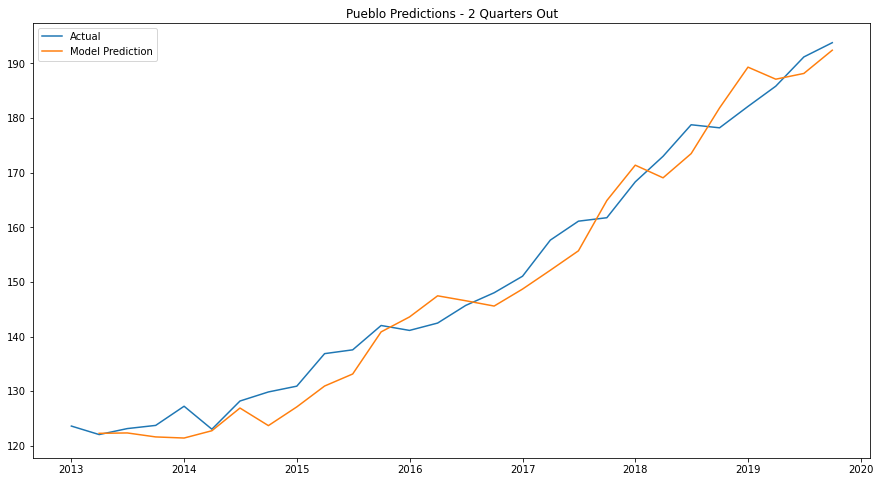

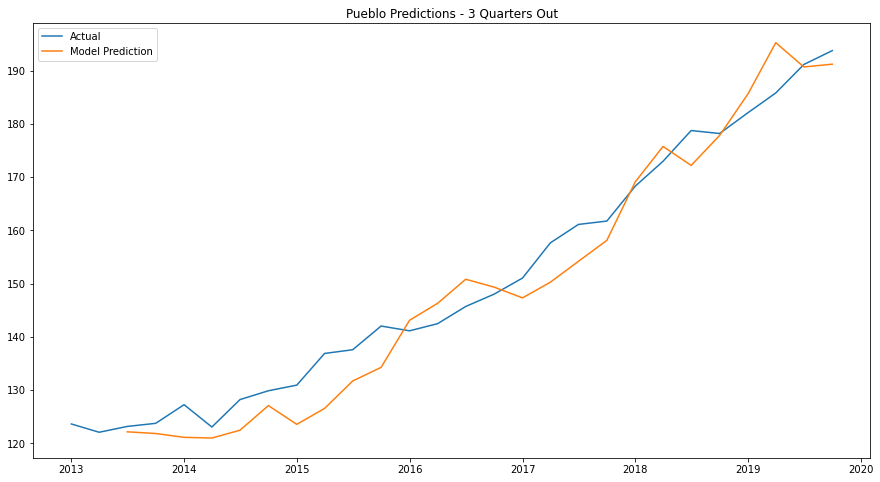

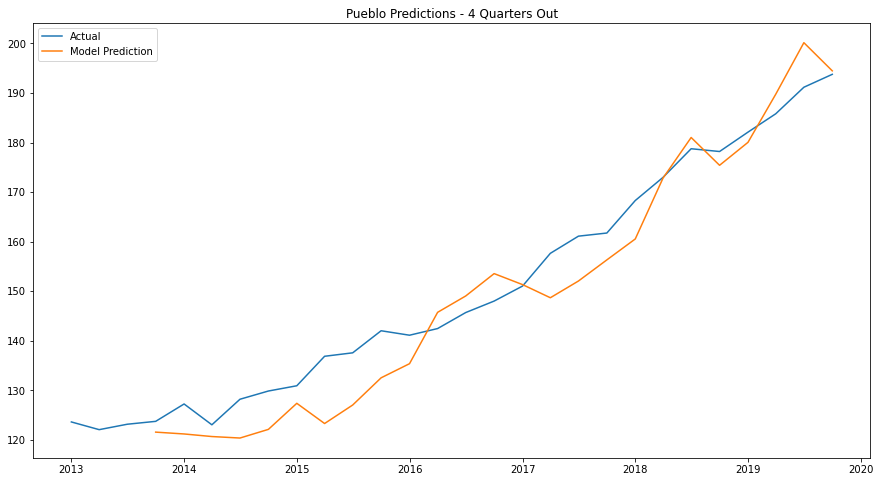

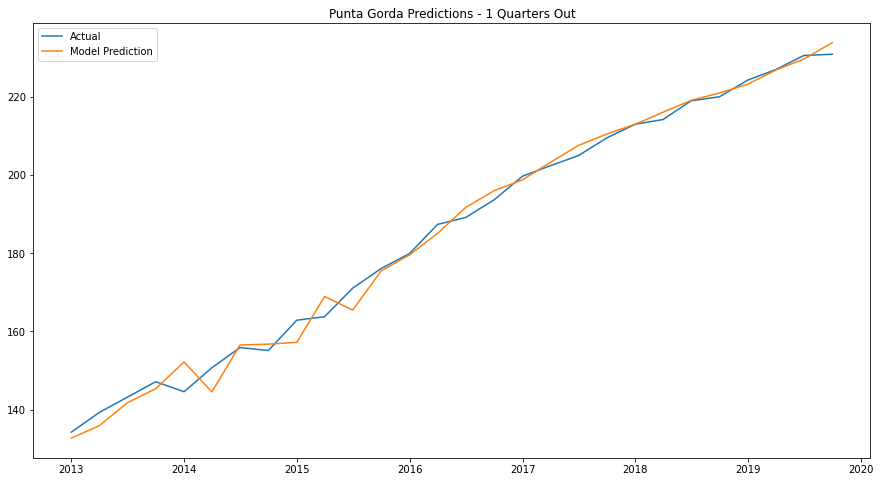

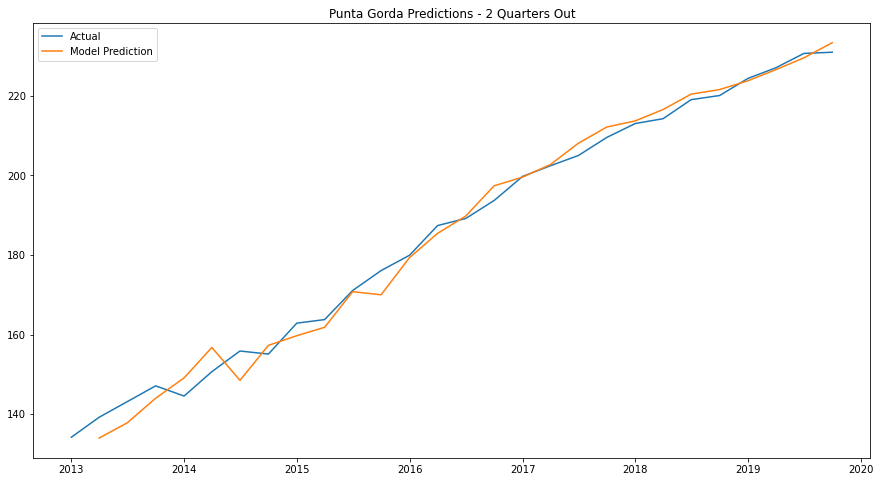

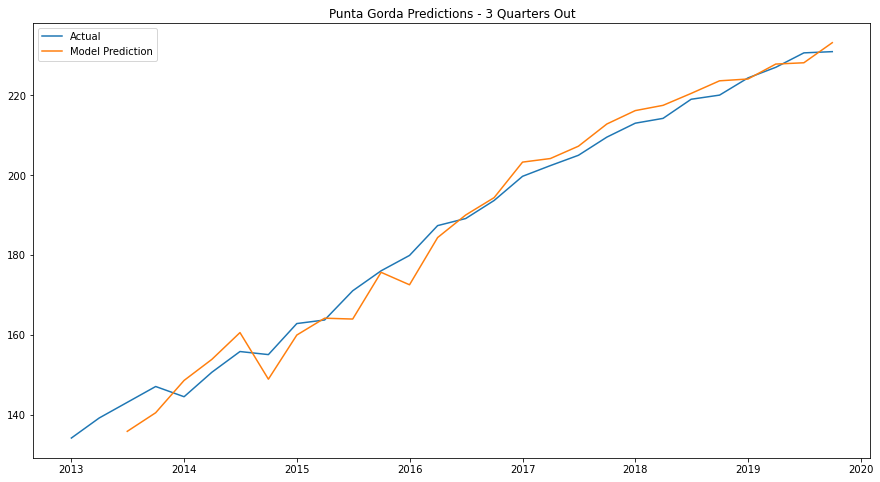

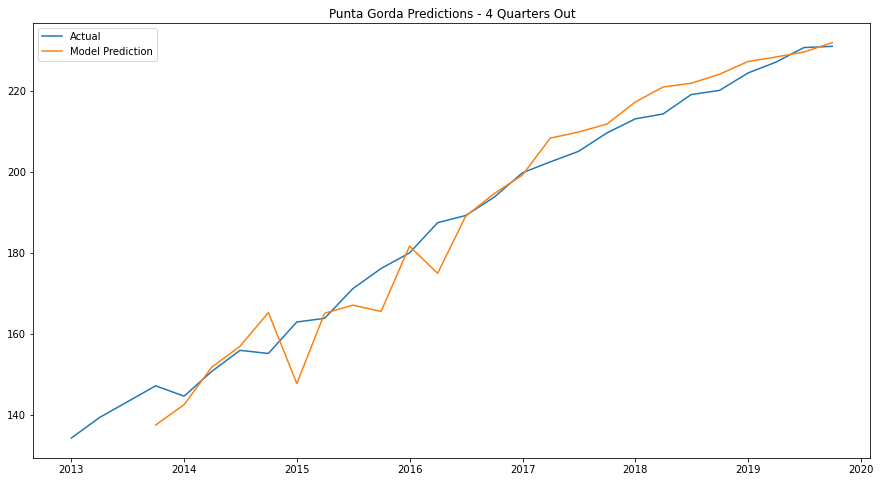

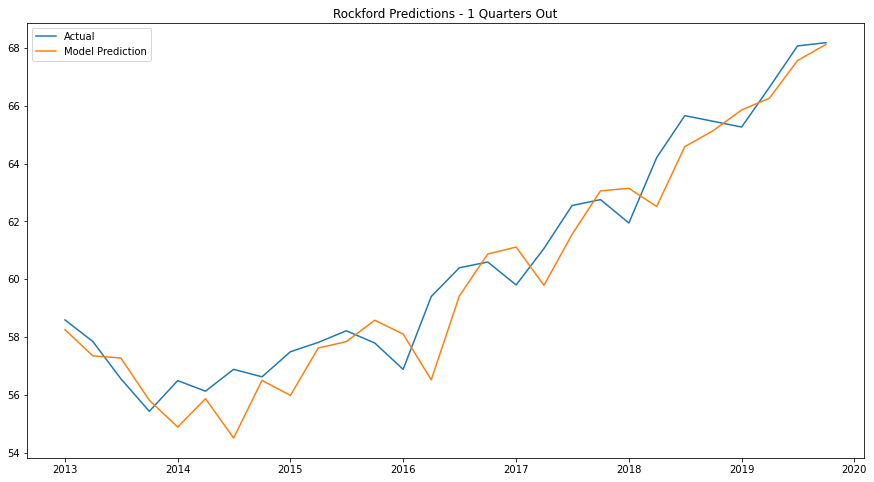

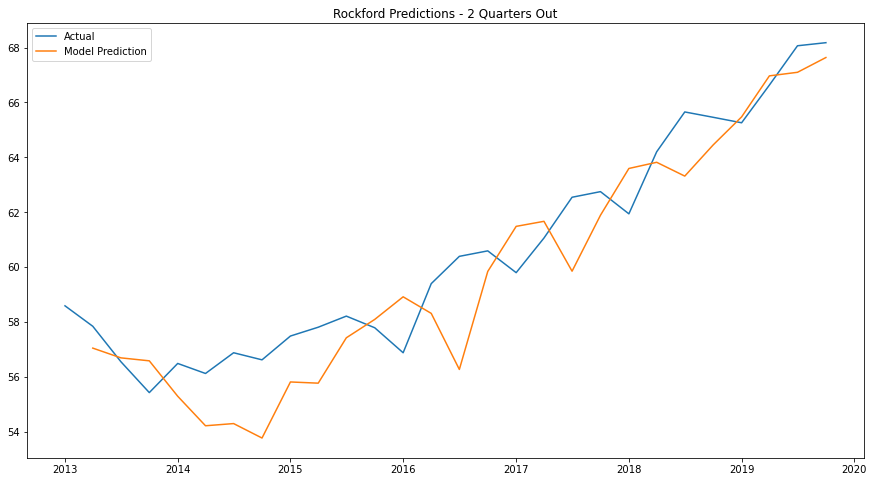

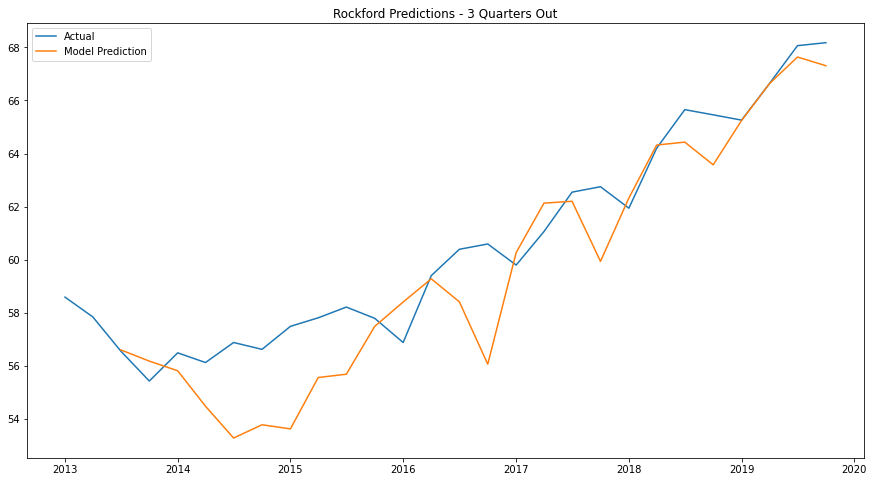

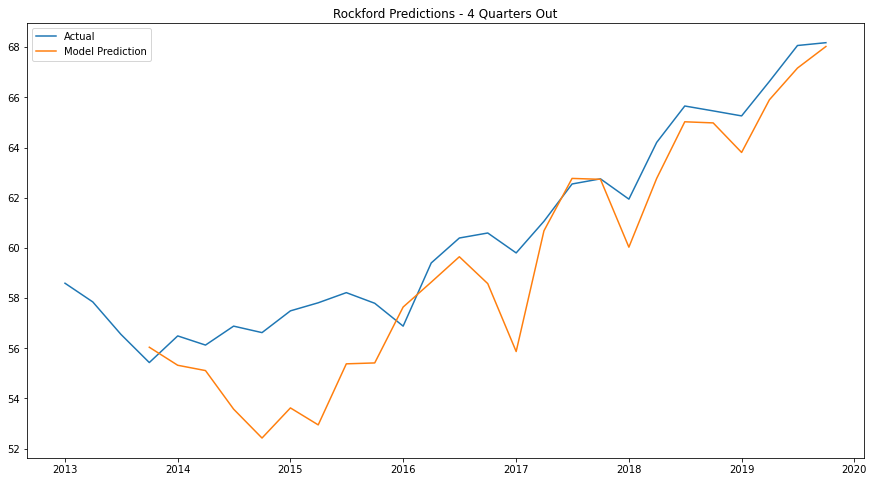

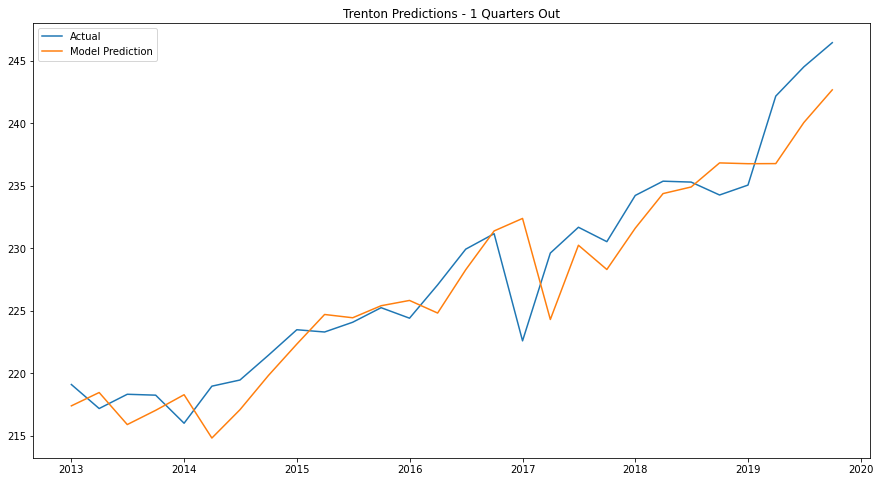

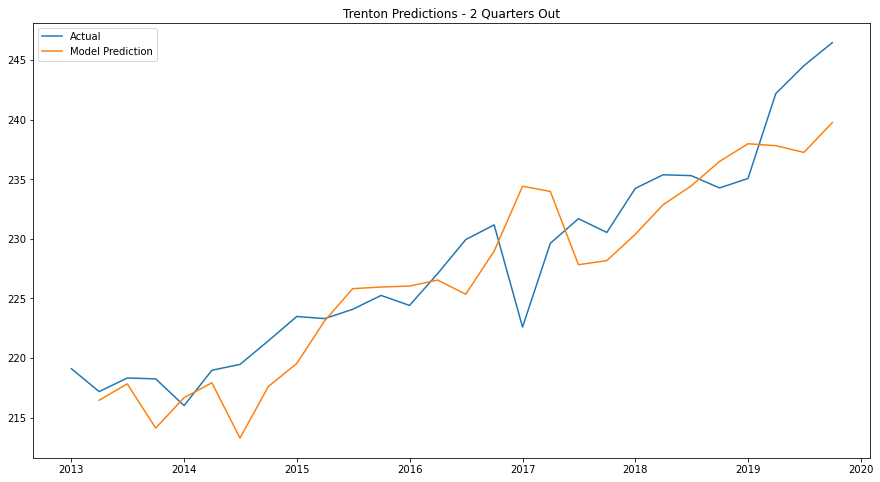

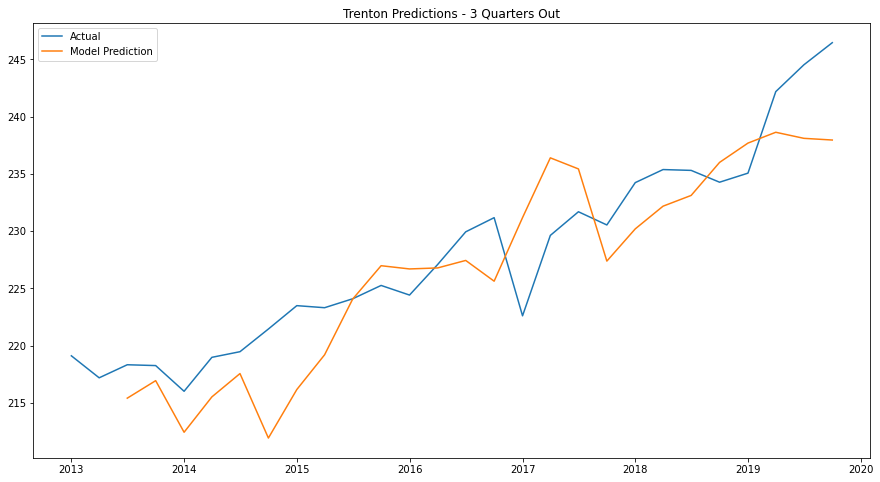

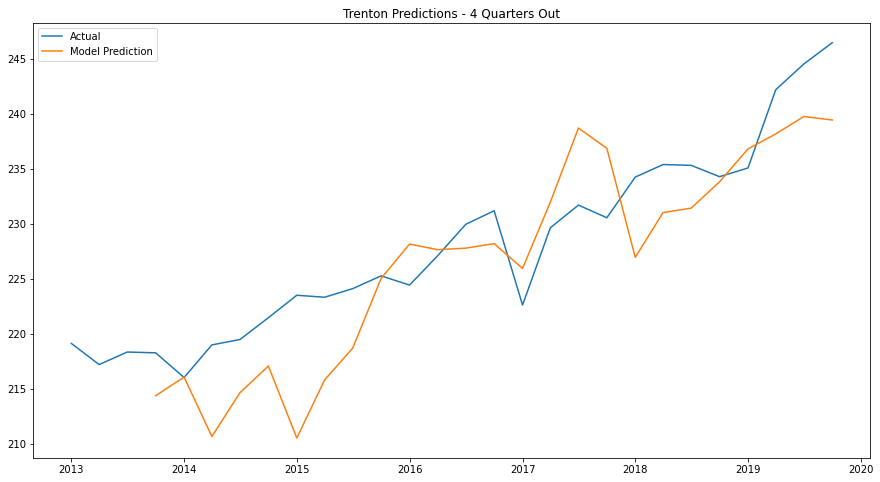

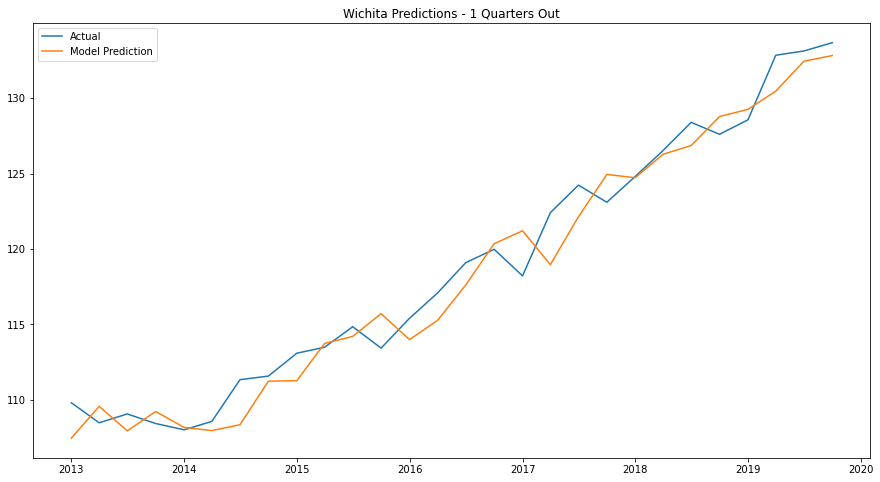

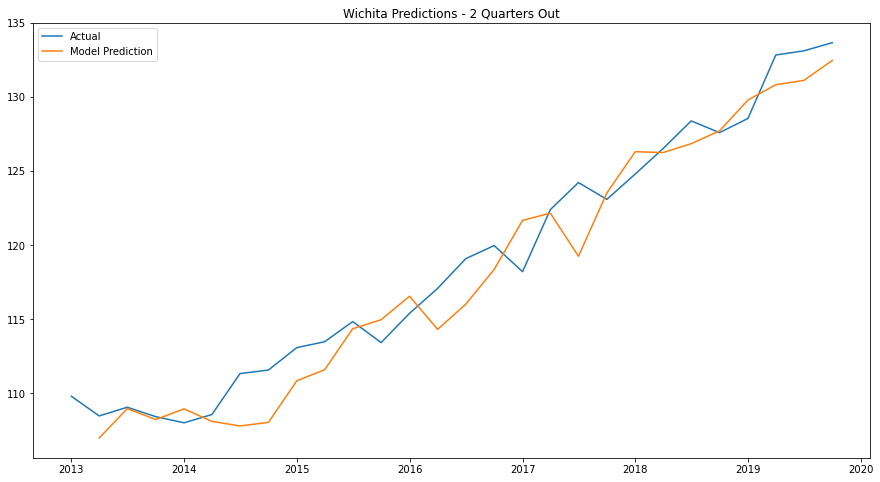

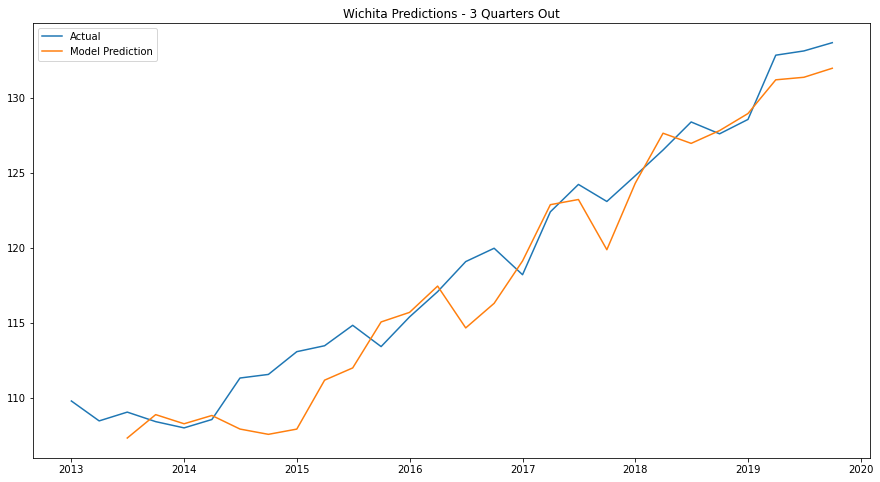

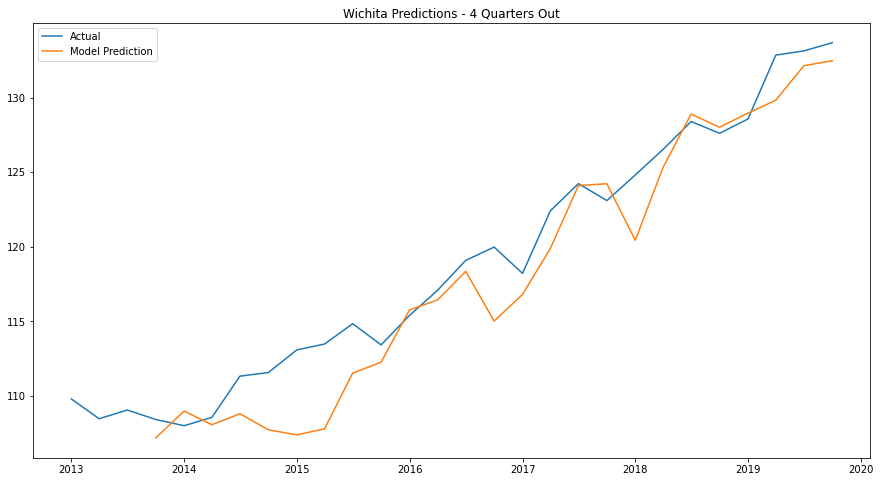

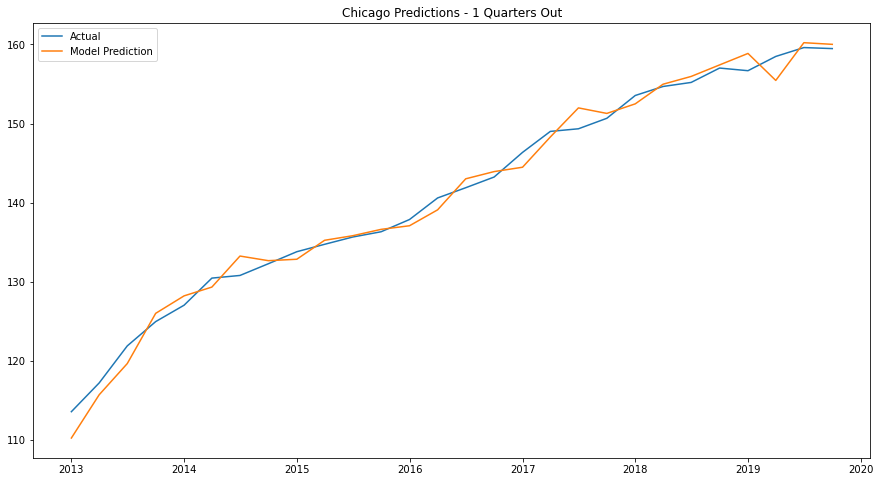

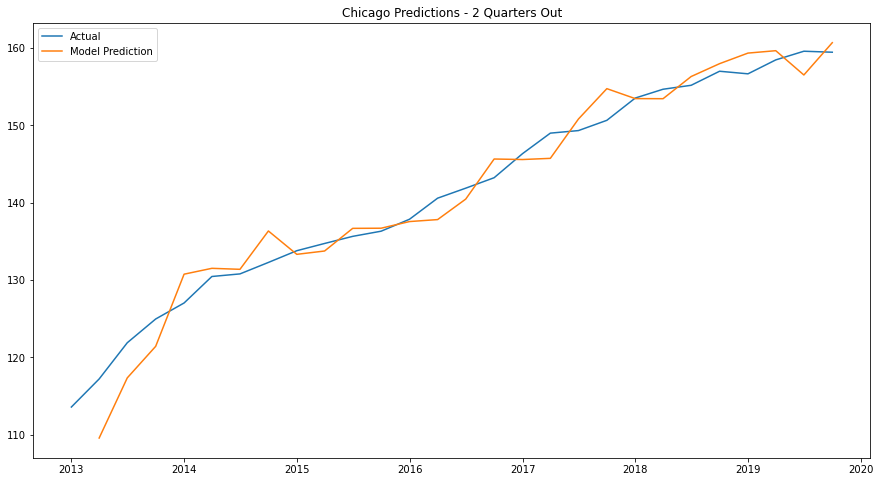

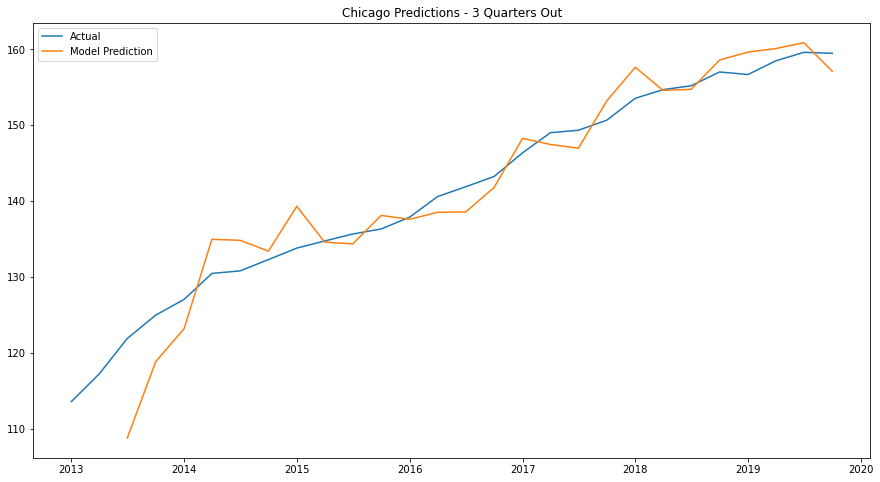

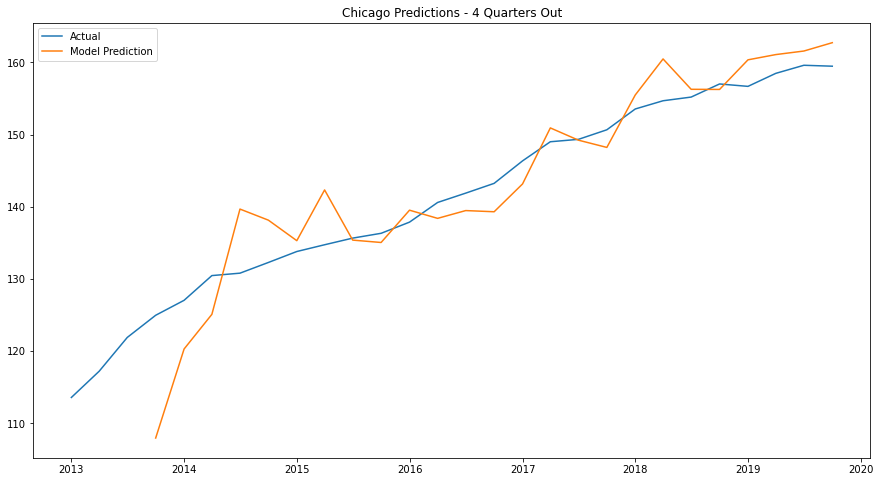

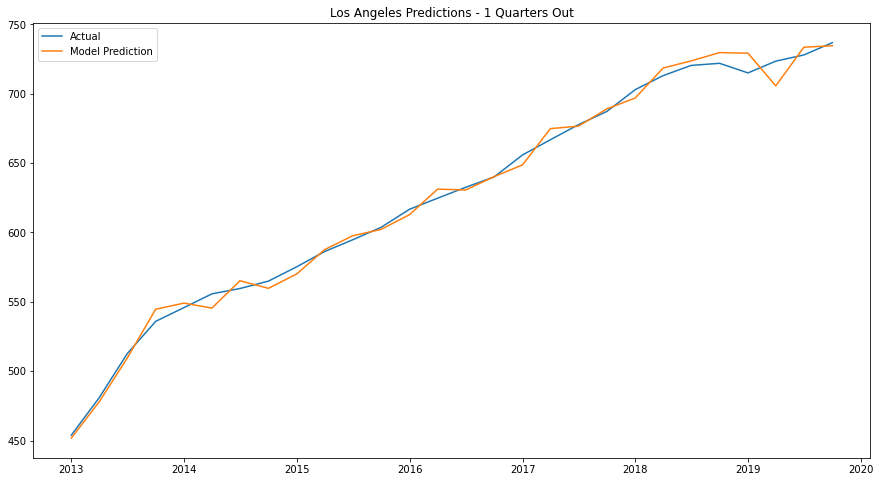

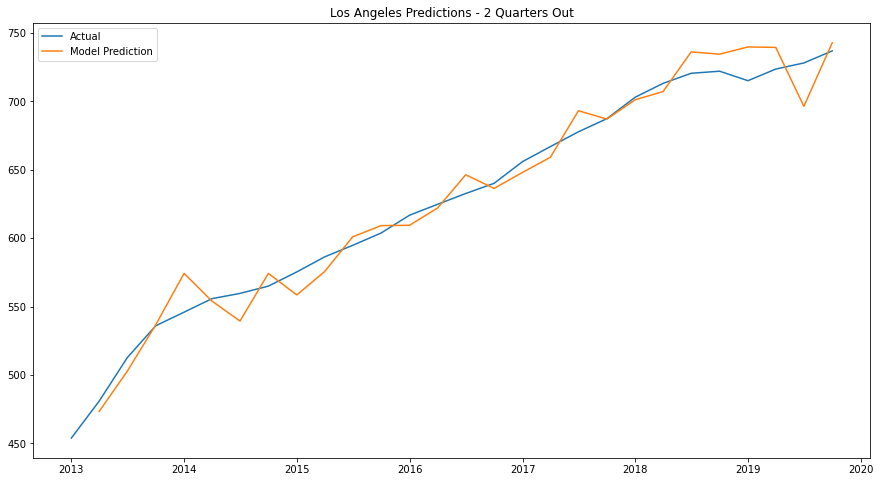

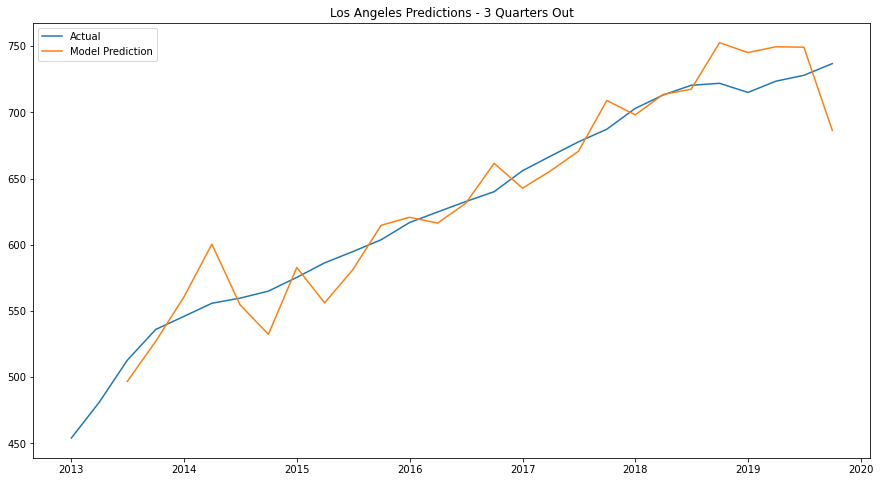

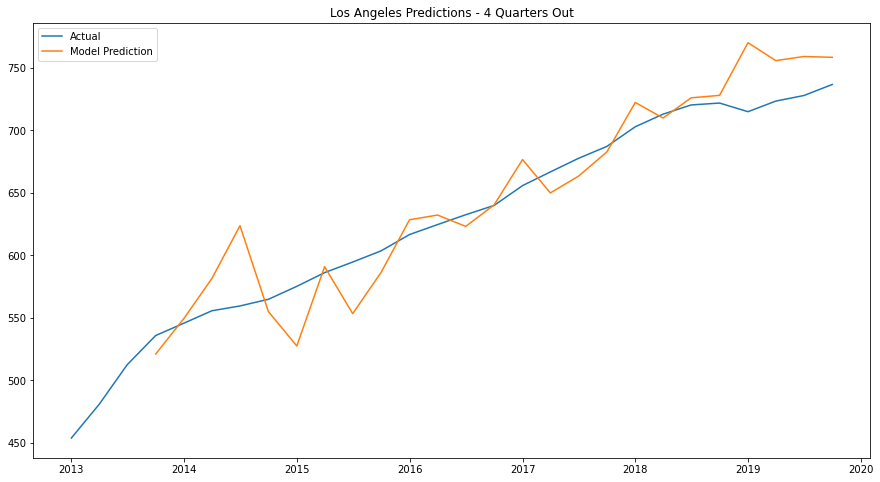

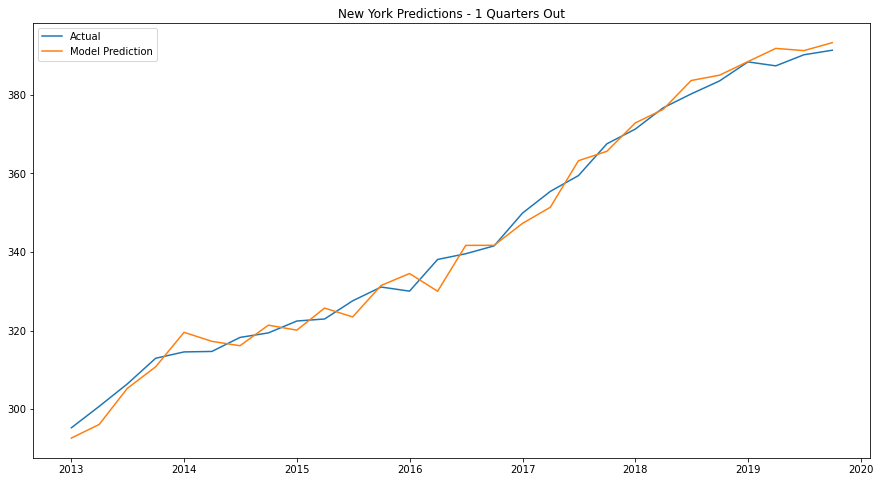

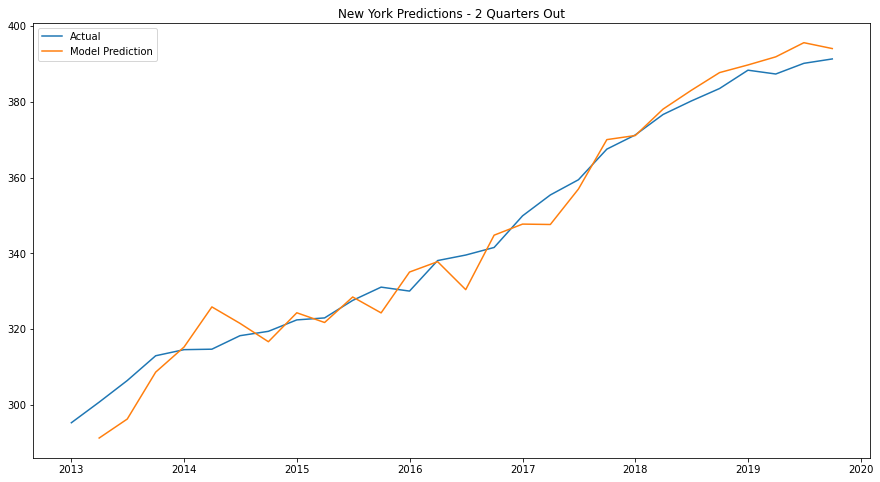

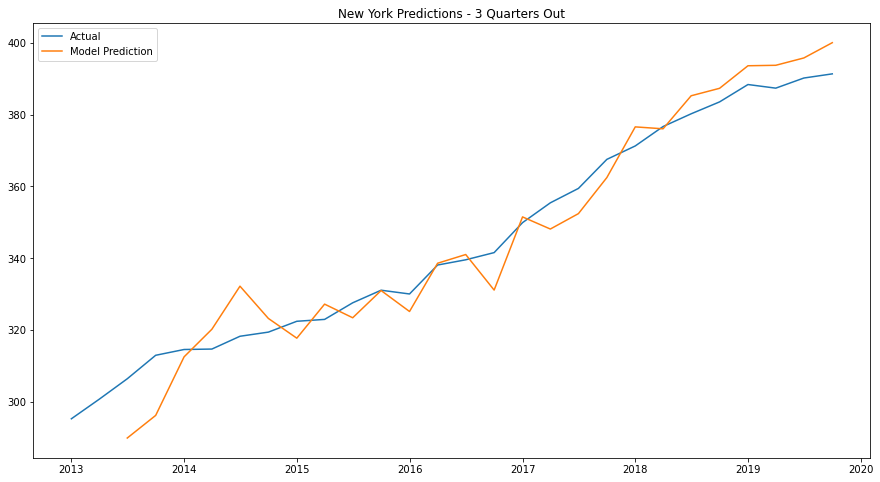

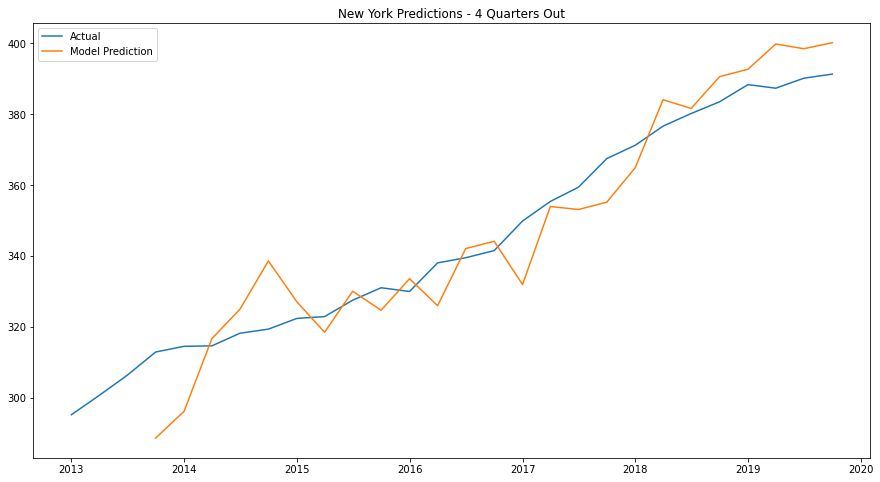

In [196]:
for city in best_model.city.unique():
    city_df = best_model[best_model.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(15,8))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.hpi, label='Actual')
        #plt.plot(city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df[pred_col], label='Model Prediction')
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

In [14]:
statsmodels.__version__

'0.12.2'

In [693]:
win, error, improvement = evaluate_model(ma_results, method='square')

In [684]:
(arima_results.query("city!='New York'") == ar_results.query("city!='New York'")).sum(axis=0)

hpi        4256
pred_1     4256
pred_2     4104
pred_3     3952
pred_4     3800
naive_1    4256
naive_2    4256
naive_3    4256
naive_4    4256
city       4256
lag        4256
dtype: int64

In [678]:
ar_results
#ar_results.query("lag==8").groupby(['city']).count()

hpi      pred_1      pred_2      pred_3      pred_4  \
date                                                                     
2013-01-01  290.267204  288.142594         NaN         NaN         NaN   
2013-04-01  295.031844  288.887341  286.331902         NaN         NaN   
2013-07-01  301.581545  295.789838  287.631354  284.629482         NaN   
2013-10-01  302.708953  304.704460  296.754111  286.480844  283.020087   
2014-01-01  307.876238  304.707341  308.216618  297.910371  285.420141   
...                ...         ...         ...         ...         ...   
2018-10-01  383.538057  406.706065  413.640901  402.357479  433.999577   
2019-01-01  388.377299  390.351978  418.653527  427.557330  423.315774   
2019-04-01  387.369467  392.649812  395.108941  444.647430  433.352424   
2019-07-01  390.188390  391.989528  398.316891  402.794743  447.764921   
2019-10-01  391.347352  395.999762  397.432344  406.245815  413.212832   

               naive_1     naive_2     naive_3     naive_4        city  lag  
date                                                                         
2013-01-01  290.079303  288.267398  286.536022  286.710502  Charleston    1  
2013-04-01  290.267204  290.079303  288.267398  286.536022  Charleston    1  
2013-07-01  295.031844  290.267204  290.079303  288.267398  Charleston    1  
2013-10-01  301.581545  295.031844  290.267204  290.079303  Charleston    1  
2014-01-01  302.708953  301.581545  295.031844  290.267204  Charleston    1  
...                ...         ...         ...         ...         ...  ...  
2018-10-01  380.226346  376.674261  371.271774  367.531294    New York    8  
2019-01-01  383.538057  380.226346  376.674261  371.271774    New York    8  
2019-04-01  388.377299  383.538057  380.226346  376.674261    New York    8  
2019-07-01  387.369467  388.377299  383.538057  380.226346    New York    8  
2019-10-01  390.188390  387.369467  388.377299  383.538057    New York    8  

[4480 rows x 11 columns]

In [676]:
arima_results.query("lag==8 & city=='New York'")
#.groupby(['city']).count() == ar_results.query("lag==8").groupby(['city']).count()

hpi      pred_1      pred_2      pred_3      pred_4  \
date                                                                     
2013-01-01  295.280784  292.959891         NaN         NaN         NaN   
2013-04-01  300.716214  299.950178  294.713713         NaN         NaN   
2013-07-01  306.426023  311.385551  306.287610  296.578974         NaN   
2013-10-01  312.966583  315.582178  325.533410  314.939063  298.310339   
2014-01-01  314.577647  324.109982  329.174311  347.143689  328.963578   
2014-04-01  314.700149  310.796118  340.063044  348.683168  382.604346   
2014-07-01  318.263899  314.363166  297.917926  360.071715  375.043607   
2014-10-01  319.419586  329.890423  315.225276  270.382748  385.250625   
2015-01-01  322.436689  330.823067  356.147363  318.235214  224.609204   
2015-04-01  322.959606  331.268414  351.753690  388.700956  321.695305   
2015-07-01  327.582909  327.550185  342.828449  372.358090  411.745486   
2015-10-01  331.088715  335.420569  338.268507  354.899745  393.767133   
2016-01-01  330.043270  336.735194  340.180378  342.807830  361.367080   
2016-04-01  338.105998  338.219085  336.427217  342.016773  345.923520   
2016-07-01  339.560661  339.570379  336.820061  341.547863  343.419279   
2016-10-01  341.564114  339.723618  340.880625  341.188719  340.502212   
2017-01-01  349.911176  341.280510  341.817499  342.182925  345.085166   
2017-04-01  355.429843  349.756076  345.742103  347.791038  346.188064   
2017-07-01  359.443931  363.816112  356.771321  355.116651  352.648715   
2017-10-01  367.531294  369.446578  371.845028  358.558974  344.767839   
2018-01-01  371.271774  383.856085  383.519414  391.452145  362.316934   
2018-04-01  376.674261  370.371200  389.246176  391.967862  410.124114   
2018-07-01  380.226346  393.094813  382.394786  403.108134  408.859120   
2018-10-01  383.538057  406.706065  413.640901  402.357479  433.999577   
2019-01-01  388.377299  390.351978  418.653527  427.557330  423.315774   
2019-04-01  387.369467  392.649812  395.108941  444.647430  433.352424   
2019-07-01  390.188390  391.989528  398.316891  402.794743  447.764921   
2019-10-01  391.347352  395.999762  397.432344  406.245815  413.212832   
2013-01-01  295.280784  290.635179         NaN         NaN         NaN   
2013-04-01  300.716214  294.677577  286.380289         NaN         NaN   
2013-07-01  306.426023  301.474763  290.183400  280.650678         NaN   
2013-10-01  312.966583  306.312455  297.983764  283.355474  272.876710   
2014-01-01  314.577647  317.045257  303.383545  293.717224  275.989288   
2014-04-01  314.700149  317.168248  318.538889  300.418208  287.431825   
2014-07-01  318.263899  314.268894  321.651954  318.469413  296.383631   
2014-10-01  319.419586  320.159758  312.044027  323.914629  318.804335   
2015-01-01  322.436689  319.415963  321.092614  310.233773  327.163815   
2015-04-01  322.959606  322.188403  317.054889  318.590467  306.608215   
2015-07-01  327.582909  319.792864  317.607553  314.089504  315.637786   
2015-10-01  331.088715  328.260912  316.991962  314.431193  311.307699   
2016-01-01  330.043270  330.162499  325.084249  311.285212  309.657888   
2016-04-01  338.105998  330.442518  330.208978  322.616650  307.805480   
2016-07-01  339.560661  340.846893  329.637205  328.803410  319.687103   
2016-10-01  341.564114  340.575028  342.295676  331.503938  328.913962   
2017-01-01  349.911176  346.347681  344.061669  343.907033  331.936645   
2017-04-01  355.429843  348.480829  347.028858  344.693068  343.599240   
2017-07-01  359.443931  356.705189  350.490228  351.005358  348.583031   
2017-10-01  367.531294  358.943864  354.263831  352.421614  350.626933   
2018-01-01  371.271774  373.812783  363.505813  357.034659  352.833095   
2018-04-01  376.674261  372.425109  375.699874  366.337771  358.765691   
2018-07-01  380.226346  382.658006  376.619172  380.613520  365.328418   
2018-10-01  383.538057  384.137163  386.468748  378.829165  385.254662   
2019-01-01  388.377299 

In [675]:
ar_results.query("lag==8 & city=='New York'")

hpi      pred_1      pred_2      pred_3      pred_4  \
date                                                                     
2013-01-01  295.280784  292.959891         NaN         NaN         NaN   
2013-04-01  300.716214  299.950178  294.713713         NaN         NaN   
2013-07-01  306.426023  311.385551  306.287610  296.578974         NaN   
2013-10-01  312.966583  315.582178  325.533410  314.939063  298.310339   
2014-01-01  314.577647  324.109982  329.174311  347.143689  328.963578   
2014-04-01  314.700149  310.796118  340.063044  348.683168  382.604346   
2014-07-01  318.263899  314.363166  297.917926  360.071715  375.043607   
2014-10-01  319.419586  329.890423  315.225276  270.382748  385.250625   
2015-01-01  322.436689  330.823067  356.147363  318.235214  224.609204   
2015-04-01  322.959606  331.268414  351.753690  388.700956  321.695305   
2015-07-01  327.582909  327.550185  342.828449  372.358090  411.745486   
2015-10-01  331.088715  335.420569  338.268507  354.899745  393.767133   
2016-01-01  330.043270  336.735194  340.180378  342.807830  361.367080   
2016-04-01  338.105998  338.219085  336.427217  342.016773  345.923520   
2016-07-01  339.560661  339.570379  336.820061  341.547863  343.419279   
2016-10-01  341.564114  339.723618  340.880625  341.188719  340.502212   
2017-01-01  349.911176  341.280510  341.817499  342.182925  345.085166   
2017-04-01  355.429843  349.756076  345.742103  347.791038  346.188064   
2017-07-01  359.443931  363.816112  356.771321  355.116651  352.648715   
2017-10-01  367.531294  369.446578  371.845028  358.558974  344.767839   
2018-01-01  371.271774  383.856085  383.519414  391.452145  362.316934   
2018-04-01  376.674261  370.371200  389.246176  391.967862  410.124114   
2018-07-01  380.226346  393.094813  382.394786  403.108134  408.859120   
2018-10-01  383.538057  406.706065  413.640901  402.357479  433.999577   
2019-01-01  388.377299  390.351978  418.653527  427.557330  423.315774   
2019-04-01  387.369467  392.649812  395.108941  444.647430  433.352424   
2019-07-01  390.188390  391.989528  398.316891  402.794743  447.764921   
2019-10-01  391.347352  395.999762  397.432344  406.245815  413.212832   

               naive_1     naive_2     naive_3     naive_4      city  lag  
date                                                                       
2013-01-01  293.853242  294.119712  293.421867  294.312399  New York    8  
2013-04-01  295.280784  293.853242  294.119712  293.421867  New York    8  
2013-07-01  300.716214  295.280784  293.853242  294.119712  New York    8  
2013-10-01  306.426023  300.716214  295.280784  293.853242  New York    8  
2014-01-01  312.966583  306.426023  300.716214  295.280784  New York    8  
2014-04-01  314.577647  312.966583  306.426023  300.716214  New York    8  
2014-07-01  314.700149  314.577647  312.966583  306.426023  New York    8  
2014-10-01  318.263899  314.700149  314.577647  312.966583  New York    8  
2015-01-01  319.419586  318.263899  314.700149  314.577647  New York    8  
2015-04-01  322.436689  319.419586  318.263899  314.700149  New York    8  
2015-07-01  322.959606  322.436689  319.419586  318.263899  New York    8  
2015-10-01  327.582909  322.959606  322.436689  319.419586  New York    8  
2016-01-01  331.088715  327.582909  322.959606  322.436689  New York    8  
2016-04-01  330.043270  331.088715  327.582909  322.959606  New York    8  
2016-07-01  338.105998  330.043270  331.088715  327.582909  New York    8  
2016-10-01  339.560661  338.105998  330.043270  331.088715  New York    8  
2017-01-01  341.564114  339.560661  338.105998  330.043270  New York    8  
2017-04-01  349.911176  341.564114  339.560661  338.105998  New York    8  
2017-07-01  355.429843  349.911176  341.564114  339.560661  New York    8  
2017-10-01  359.443931  355.429843  349.911176  341.564114  New York    8  
2018-01-01  367.531294  359.443931  355.429843  349.911176  New York    8  
2018-04-01  371.271774  367.531294  359.443931  35

In [603]:
# use square difference
results_square = results_df.copy()
#results_square[diff_cols] = results_square[diff_cols] ** 2
results_square[diff_cols] = np.abs(results_square[diff_cols])

# calculate mse by city and lag value, caulculate winners
mses = results_square.groupby(['city', 'lag'])[diff_cols].mean().reset_index()

mses = mses.assign(improve_1=(mses.diff_1_naive-mses.diff_1),
             improve_2=(mses.diff_2_naive-mses.diff_2),
             improve_3=(mses.diff_3_naive-mses.diff_3),
             improve_4=(mses.diff_4_naive-mses.diff_4))


mses = mses.assign(win_1=mses.improve_1 > 0,
             win_2=mses.improve_2 > 0,
             win_3=mses.improve_3 > 0,
             win_4=mses.improve_4 > 0)

In [604]:
# best lag by win rate
win_cols = [col for col in mses.columns if 'win' in col]
win_rate = mses.groupby(['lag'])[win_cols].sum().sum(axis=1)/mses.groupby(['lag'])[win_cols].count().sum(axis=1)

# best lag by minimum error
pred_cols = [col for col in mses.columns if 'diff' in col and 'naive' not in col]
avg_mse = mses.groupby(['lag'])[pred_cols].mean().mean(axis=1)

# best lag by max improvement
improve_cols = [col for col in mses.columns if 'improve' in col]
avg_improvement = mses.groupby(['lag'])[improve_cols].mean().mean(axis=1)

In [605]:
avg_mse

lag
1    0.023646
2    0.023390
3    0.022743
4    0.022779
5    0.024515
6    0.027273
7    0.034083
8    0.062874
dtype: float64

In [455]:
diff_cols = [col for col in ar_results.columns if 'diff' in col]

In [549]:
ar_abs = ar_results.copy()
#ar_abs[diff_cols] = np.abs(ar_abs[diff_cols])

In [551]:
ar_results[diff_cols]**2

diff_1    diff_2    diff_3    diff_4  diff_1_naive  \
date                                                               
2013-01-01  0.000054       NaN       NaN       NaN  4.190477e-07   
2013-04-01  0.000434  0.000870       NaN       NaN  2.608088e-04   
2013-07-01  0.000369  0.002140  0.003160       NaN  4.716648e-04   
2013-10-01  0.000043  0.000387  0.002874  0.004230  1.387112e-05   
2014-01-01  0.000106  0.000001  0.001048  0.005320  2.816907e-04   
...              ...       ...       ...       ...           ...   
2018-10-01  0.003649  0.006160  0.002408  0.017310  7.455694e-05   
2019-01-01  0.000026  0.006077  0.010177  0.008093  1.552555e-04   
2019-04-01  0.000186  0.000399  0.021864  0.014091  6.769012e-06   
2019-07-01  0.000021  0.000434  0.001044  0.021774  5.219365e-05   
2019-10-01  0.000141  0.000242  0.001449  0.003122  8.770284e-06   

            diff_2_naive  diff_3_naive  diff_4_naive  
date                                                  
2013-01-01      0.000047      0.000165      0.000150  
2013-04-01      0.000282      0.000526      0.000829  
2013-07-01      0.001408      0.001455      0.001949  
2013-10-01      0.000643      0.001689      0.001741  
2014-01-01      0.000418      0.001741      0.003271  
...                  ...           ...           ...  
2018-10-01      0.000320      0.001023      0.001742  
2019-01-01      0.000440      0.000908      0.001940  
2019-04-01      0.000098      0.000340      0.000762  
2019-07-01      0.000022      0.000290      0.000652  
2019-10-01      0.000103      0.000058      0.000398  

[4480 rows x 8 columns]

In [506]:
avg_diffs = ar_abs.groupby(['city', 'lag'])[diff_cols].mean().reset_index()

In [507]:
lag_results = avg_diffs.groupby(['lag'])[diff_cols].mean().reset_index()

In [520]:
avg_diffs = avg_diffs.assign(win_1=(avg_diffs.diff_1_naive-avg_diffs.diff_1) > 0,
                 win_2=(avg_diffs.diff_2_naive-avg_diffs.diff_2) > 0,
                 win_3=(avg_diffs.diff_3_naive-avg_diffs.diff_3) > 0,
                 win_4=(avg_diffs.diff_4_naive-avg_diffs.diff_4) > 0)

In [547]:
win_cols = [col for col in avg_diffs.columns if 'win' in col]
win_rate = avg_diffs.groupby(['lag'])[win_cols].sum().sum(axis=1)/avg_diffs.groupby(['lag'])[win_cols].count().sum(axis=1)

lag
1    0.8000
2    0.8250
3    0.8125
4    0.8875
5    0.8000
6    0.6375
7    0.4625
8    0.1375
dtype: float64

In [530]:
pred_cols = [col for col in avg_diffs.columns if 'diff' in col and 'naive' not in col]

In [548]:
avg_diffs.groupby(['lag'])[pred_cols].mean().mean(axis=1)

lag
1    0.023646
2    0.023390
3    0.022743
4    0.022779
5    0.024515
6    0.027273
7    0.034083
8    0.062874
dtype: float64

In [524]:
avg_diffs.groupby(['lag'])[diff_cols].mean()

diff_1    diff_2    diff_3    diff_4  diff_1_naive  diff_2_naive  \
lag                                                                       
1    0.012878  0.020100  0.026759  0.034848      0.015773      0.026938   
2    0.012861  0.019703  0.026555  0.034442      0.015773      0.026938   
3    0.012861  0.019066  0.025490  0.033556      0.015773      0.026938   
4    0.012737  0.018707  0.025750  0.033923      0.015773      0.026938   
5    0.013544  0.019600  0.027878  0.037036      0.015773      0.026938   
6    0.015203  0.021464  0.030888  0.041537      0.015773      0.026938   
7    0.017771  0.025845  0.038354  0.054362      0.015773      0.026938   
8    0.025520  0.040817  0.067400  0.117761      0.015773      0.026938   

     diff_3_naive  diff_4_naive  
lag                              
1        0.038206      0.049513  
2        0.038206      0.049513  
3        0.038206      0.049513  
4        0.038206      0.049513  
5        0.038206      0.049513  
6        0.038206      0.049513  
7        0.038206      0.049513  
8        0.038206      0.049513

In [509]:
lag_2 = avg_diffs[avg_diffs.lag == 2]

In [483]:
bins=np.arange(0, 0.1, 0.005)

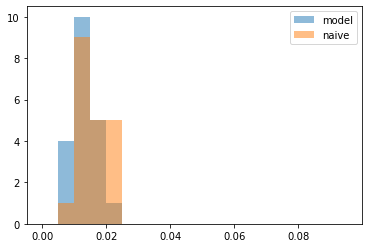

In [510]:
plt.hist(lag_2.diff_1, label='model', bins=bins, alpha=0.5)
plt.hist(lag_2.diff_1_naive, label='naive', bins=bins, alpha=0.5)
plt.legend()
plt.show()

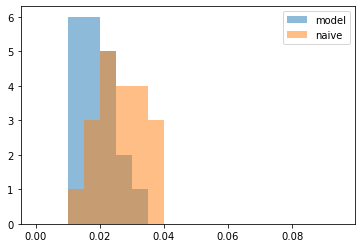

In [511]:
plt.hist(lag_2.diff_2, label='model', bins=bins, alpha=0.5)
plt.hist(lag_2.diff_2_naive, label='naive', bins=bins, alpha=0.5)
plt.legend()
plt.show()

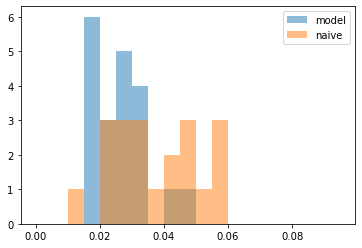

In [514]:
plt.hist(lag_2.diff_3, label='model', bins=bins, alpha=0.5)
plt.hist(lag_2.diff_3_naive, label='naive', bins=bins, alpha=0.5)
plt.legend()
plt.show()

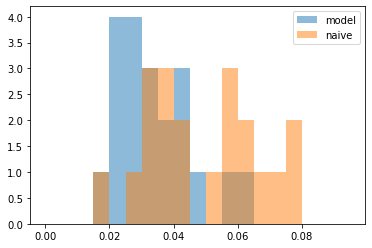

In [515]:
plt.hist(lag_2.diff_4, label='model', bins=bins, alpha=0.5)
plt.hist(lag_2.diff_4_naive, label='naive', bins=bins, alpha=0.5)
plt.legend()
plt.show()

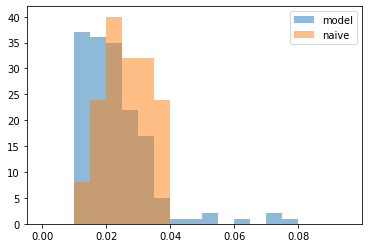

In [487]:
plt.hist(avg_diffs.diff_2, label='model', bins=bins, alpha=0.5)
plt.hist(avg_diffs.diff_2_naive, label='naive', bins=bins, alpha=0.5)
plt.legend()
plt.show()

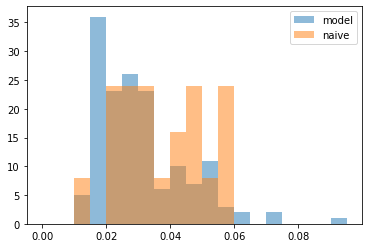

In [488]:
plt.hist(avg_diffs.diff_3, label='model', bins=bins, alpha=0.5)
plt.hist(avg_diffs.diff_3_naive, label='naive', bins=bins, alpha=0.5)
plt.legend()
plt.show()

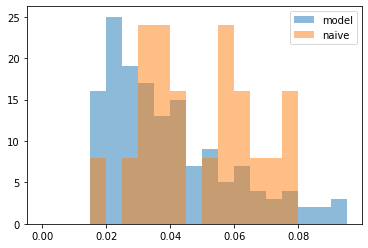

In [489]:
plt.hist(avg_diffs.diff_4, label='model', bins=bins, alpha=0.5)
plt.hist(avg_diffs.diff_4_naive, label='naive', bins=bins, alpha=0.5)
plt.legend()
plt.show()

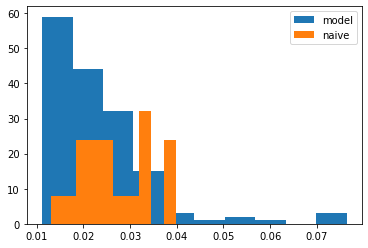

In [478]:
plt.hist(avg_diffs.diff_2, label='model')
plt.hist(avg_diffs.diff_2_naive, label='naive')
plt.legend()
plt.show()

In [ ]:
plt.hist(avg_diffs.diff_1, label='model')
plt.hist(avg_diffs.diff_1_naive, label='naive')
plt.legend()
plt.show()

In [447]:
pred_cols = [col for col in ar_results.columns if 'pred' in col]

In [450]:
ar_results[pred_cols]
#/ar_results.hpi

pred_1      pred_2      pred_3      pred_4
date                                                      
2013-01-01  288.142594         NaN         NaN         NaN
2013-04-01  288.887341  286.331902         NaN         NaN
2013-07-01  295.789838  287.631354  284.629482         NaN
2013-10-01  304.704460  296.754111  286.480844  283.020087
2014-01-01  304.707341  308.216618  297.910371  285.420141
...                ...         ...         ...         ...
2018-10-01  406.706065  413.640901  402.357479  433.999577
2019-01-01  390.351978  418.653527  427.557330  423.315774
2019-04-01  392.649812  395.108941  444.647430  433.352424
2019-07-01  391.989528  398.316891  402.794743  447.764921
2019-10-01  395.999762  397.432344  406.245815  413.212832

[4480 rows x 4 columns]

In [436]:
np.linalg.norm(func_result.hpi - func_result.naive_4)/len(func_result.hpi - func_result.naive_4)

2.7988480378009055

In [437]:
np.linalg.norm((func_result.hpi - func_result.pred_4)[(func_result.hpi - func_result.pred_4).notnull()])/(func_result.hpi - func_result.pred_4).notnull().sum()

3.736095406353062

In [412]:
np.linalg.norm(func_result.hpi - func_result.pred_2)

nan

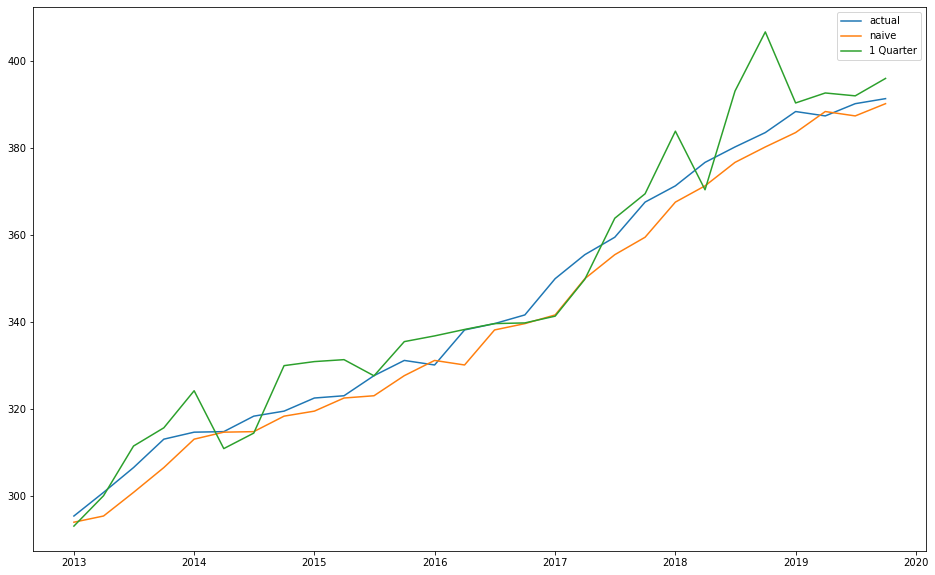

In [404]:
plt.figure(figsize=(16, 10))
plt.plot(func_result.hpi, label='actual')
plt.plot(func_result.naive, label='naive')
plt.plot(func_result.pred_1, label='1 Quarter')
#plt.plot(func_result.pred_2, label='2 Quarters')
#plt.plot(func_result.pred_3, label='3 Quarters')
#plt.plot(func_result.pred_4, label='4 Quarters')
plt.legend()
plt.show()

In [285]:
ny_uni = hpi_uni.query("city == 'New York'").reset_index(drop=True)

In [286]:
X = np.array(ny_uni.hpi)

In [287]:
results_df = ny_uni.set_index('date')['hpi'].to_frame()

In [288]:
results_df = results_df.assign(pred_1=np.nan, pred_2=np.nan, pred_3=np.nan, pred_4=np.nan)

In [358]:
tscv = TimeSeriesSplit(n_splits=28, max_train_size=20, test_size=1)

In [360]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    date = ny_uni.date[test_index[0]]
    ny_model = AutoReg(X_train, lags=8, trend='ct').fit()
    preds = ny_model.predict(16, 16+4)
    #print(ny_model.params)
    results_df.loc[date, 'pred_1'] = preds[0]
    results_df.loc[date, 'pred_2'] = preds[1]
    results_df.loc[date, 'pred_3'] = preds[2]
    results_df.loc[date, 'pred_4'] = preds[3]

In [346]:
results_df = results_df.loc[dt.datetime(2012, 1, 1):, :]

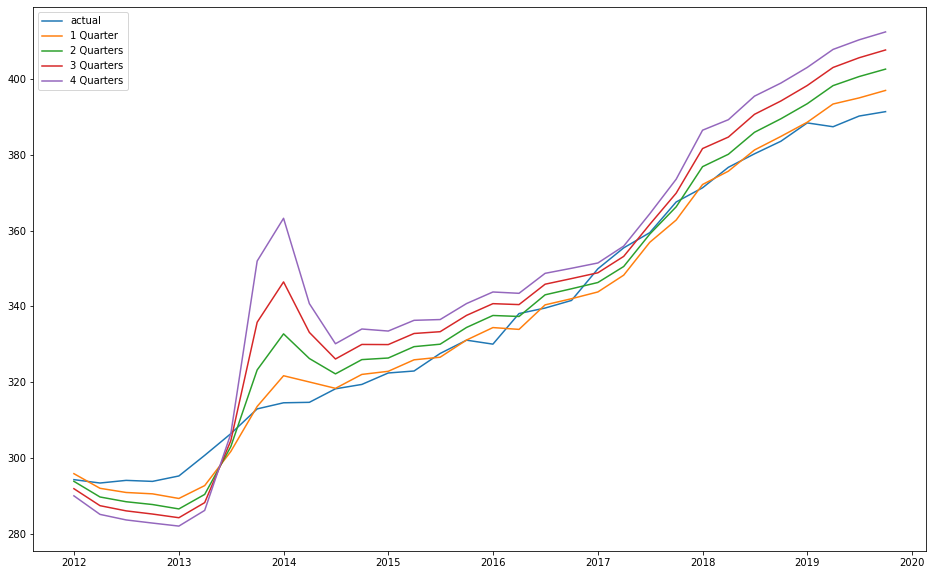

In [347]:
plt.figure(figsize=(16, 10))
plt.plot(results_df.hpi, label='actual')
plt.plot(results_df.pred_1, label='1 Quarter')
plt.plot(results_df.pred_2, label='2 Quarters')
plt.plot(results_df.pred_3, label='3 Quarters')
plt.plot(results_df.pred_4, label='4 Quarters')
plt.legend()
plt.show()

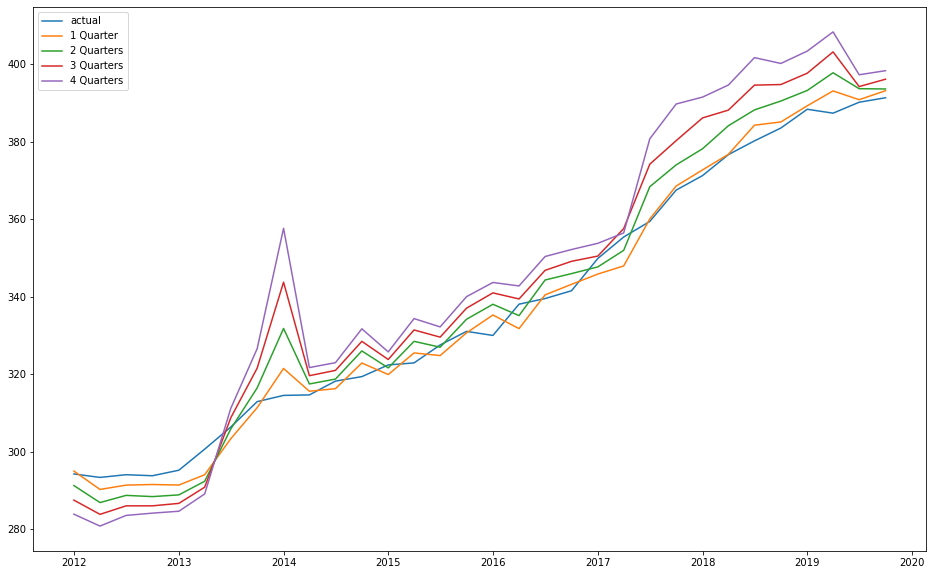

In [341]:
plt.figure(figsize=(16, 10))
plt.plot(results_df.hpi, label='actual')
plt.plot(results_df.pred_1, label='1 Quarter')
plt.plot(results_df.pred_2, label='2 Quarters')
plt.plot(results_df.pred_3, label='3 Quarters')
plt.plot(results_df.pred_4, label='4 Quarters')
plt.legend()
plt.show()

In [315]:
results_df

hpi      pred_1  pred_2  pred_3  pred_4
date                                                      
2008-01-01  374.639963         NaN     NaN     NaN     NaN
2008-04-01  366.206529         NaN     NaN     NaN     NaN
2008-07-01  356.932738         NaN     NaN     NaN     NaN
2008-10-01  347.441398         NaN     NaN     NaN     NaN
2009-01-01  335.360296         NaN     NaN     NaN     NaN
2009-04-01  320.871993         NaN     NaN     NaN     NaN
2009-07-01  316.358583         NaN     NaN     NaN     NaN
2009-10-01  319.060722         NaN     NaN     NaN     NaN
2010-01-01  318.722635         NaN     NaN     NaN     NaN
2010-04-01  315.342603         NaN     NaN     NaN     NaN
2010-07-01  316.428513         NaN     NaN     NaN     NaN
2010-10-01  308.831168         NaN     NaN     NaN     NaN
2011-01-01  302.994753         NaN     NaN     NaN     NaN
2011-04-01  300.193672         NaN     NaN     NaN     NaN
2011-07-01  299.260942         NaN     NaN     NaN     NaN
2011-10-01  297.999550         NaN     NaN     NaN     NaN
2012-01-01  294.312399  295.061283     NaN     NaN     NaN
2012-04-01  293.421867  286.935190     NaN     NaN     NaN
2012-07-01  294.119712  286.087439     NaN     NaN     NaN
2012-10-01  293.853242  284.209420     NaN     NaN     NaN
2013-01-01  295.280784  282.664040     NaN     NaN     NaN
2013-04-01  300.716214  285.532475     NaN     NaN     NaN
2013-07-01  306.426023  317.735497     NaN     NaN     NaN
2013-10-01  312.966583  346.544266     NaN     NaN     NaN
2014-01-01  314.577647  463.492020     NaN     NaN     NaN
2014-04-01  314.700149  334.784819     NaN     NaN     NaN
2014-07-01  318.263899  338.693362     NaN     NaN     NaN
2014-10-01  319.419586  359.331901     NaN     NaN     NaN
2015-01-01  322.436689  345.909133     NaN     NaN     NaN
2015-04-01  322.959606  365.044377     NaN     NaN     NaN
2015-07-01  327.582909  361.908514     NaN     NaN     NaN
2015-10-01  331.088715  377.842050     NaN     NaN     NaN
2016-01-01  330.043270  388.244103     NaN     NaN     NaN
2016-04-01  338.105998  386.456706     NaN     NaN     NaN
2016-07-01  339.560661  404.160110     NaN     NaN     NaN
2016-10-01  341.564114  405.483764     NaN     NaN     NaN
2017-01-01  349.911176  404.837681     NaN     NaN     NaN
2017-04-01  355.429843  415.690807     NaN     NaN     NaN
2017-07-01  359.443931  568.697273     NaN     NaN     NaN
2017-10-01  367.531294  608.584554     NaN     NaN     NaN
2018-01-01  371.271774  560.286101     NaN     NaN     NaN
2018-04-01  376.674261  548.531101     NaN     NaN     NaN
2018-07-01  380.226346  567.210807     NaN     NaN     NaN
2018-10-01  383.538057  547.370904     NaN     NaN     NaN
2019-01-01  388.377299  551.579555     NaN     NaN     NaN
2019-04-01  387.369467  574.731637     NaN     NaN     NaN
2019-07-01  390.188390  446.964448     NaN     NaN     NaN
2019-10-01  391.347352  445.705066     NaN     NaN     NaN

In [73]:
from pandas.plotting import autocorrelation_plot

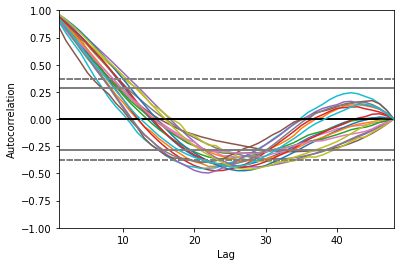

In [77]:
for city in hpi.city.unique():
    autocorrelation_plot(hpi_uni[hpi_uni.city == city].hpi)

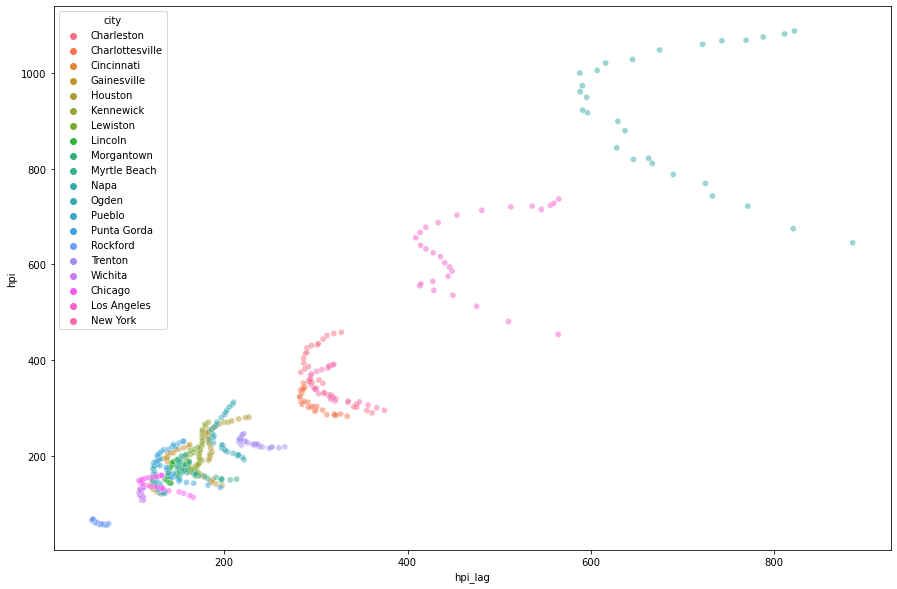

In [53]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='hpi_lag', y='hpi', hue='city', data=hpi_uni, alpha=0.5)
plt.show()

In [14]:
tscv = TimeSeriesSplit(n_splits=15, max_train_size=5, test_size=3)

In [15]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0 1 2] TEST: [3 4 5]
TRAIN: [1 2 3 4 5] TEST: [6 7 8]
TRAIN: [4 5 6 7 8] TEST: [ 9 10 11]
TRAIN: [ 7  8  9 10 11] TEST: [12 13 14]
TRAIN: [10 11 12 13 14] TEST: [15 16 17]
TRAIN: [13 14 15 16 17] TEST: [18 19 20]
TRAIN: [16 17 18 19 20] TEST: [21 22 23]
TRAIN: [19 20 21 22 23] TEST: [24 25 26]
TRAIN: [22 23 24 25 26] TEST: [27 28 29]
TRAIN: [25 26 27 28 29] TEST: [30 31 32]
TRAIN: [28 29 30 31 32] TEST: [33 34 35]
TRAIN: [31 32 33 34 35] TEST: [36 37 38]
TRAIN: [34 35 36 37 38] TEST: [39 40 41]
TRAIN: [37 38 39 40 41] TEST: [42 43 44]
TRAIN: [40 41 42 43 44] TEST: [45 46 47]
